In [ ]:
#########################################################################
#   PROJET 4 - Segmentez des clients d'un site e-commerce               #
#-----------------------------------------------------------------------#
#   ANALYSE EXPLORATOIRE : cleaning, feature engineering, exploration   #
#########################################################################
# Données : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In [ ]:
#!pip install geopy

In [ ]:
#############################################################################
# PLAN CODE :                                                               #
#############################################################################
# 1. LISTE DES VARIABLES
#    1.1. ETUDE DES N DATAFRAMES
#    1.2. CREATION D'UN DATAFRAME UNIQUE
#    1.3. MESURES STATISTIQUES
#
# 2. NETTOYAGE
#    2.1. ERREUR DE FORMATAGE (TYPE)
#    2.2. VALEURS MANQUANTES (LIGNES & COLONNES)
#    2.3. DOUBLONS
#    2.4. VALEURS ABERRANTES / OUTLIERS
#         2.4.1. VALEURS ABERRANTES / OUTLIERS (NUMERIQUES)
#                2.4.1.1. ANALYSE UNIVARIEE
#         2.4.2. VALEURS ABERRANTES / OUTLIERS (STRING)
#                2.4.2.1. ANALYSE UNIVARIEE
#
# 3. VISUALISATION
#    3.1. ANALYSE BIVARIEE
#         3.1.1. Graphique croisant 2 variables catégorielles
#         3.1.2. Graphique croisant une variable numérique et une catégorielle
#         3.1.3. Graphique croisant 2 variables numériques
#
# 4. FEATURE ENGINEERING (DATAFRAME COMMANDE CENTRE)
#    4.1. DISTANCE CLIENT-VENDEUR
#    4.2. VOLUME PRODUIT
#    4.3. DELAIS COMMANDE / ETAPE (APPROBATION, LIVRAISON ESTIMEE, LIVRAISON REELLE, AVIS)
#    4.4. RAYON PRODUIT
#    4.5. DESCRIPTION PRODUIT
#    4.6. AVIS CLIENT
#
# 5. CONVERSION EN TYPES NUMERIQUES
#    5.1. BOOLEEN --> INTEGER
#    5.2. ENUMERE --> INTEGER
#
# 6. DATAFRAME CLIENT CENTRE
#    6.1. CREATION DATAFRAME A PARTIR DU DATAFRAME DES COMMANDES

In [1]:
# built-in (librairie par défaut avec python)
import os
import math
import statistics

# Data
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# Dates
from datetime import date
import time

# Visualisation
import matplotlib.pyplot as plt

# geocoding web services. https://pypi.org/project/geopy/
from geopy.distance import geodesic

# 1. LISTE DES VARIABLES

# 1.1. ETUDE DES N DATAFRAMES

In [2]:
# Constantes
C_DATASET_SOURCE  = './data/source/'
C_DATASET_CLEANED = './data/cleaned/'

In [3]:
# Liste des fichiers fournis
os.listdir(C_DATASET_SOURCE)

['olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv']

In [4]:
# Chargement des données dans des dataframes
df_customers   = pd.read_csv(C_DATASET_SOURCE + 'olist_customers_dataset.csv')
df_geolocation = pd.read_csv(C_DATASET_SOURCE + 'olist_geolocation_dataset.csv')
df_orders      = pd.read_csv(C_DATASET_SOURCE + 'olist_orders_dataset.csv')
df_item        = pd.read_csv(C_DATASET_SOURCE + 'olist_order_items_dataset.csv')
df_order_pay   = pd.read_csv(C_DATASET_SOURCE + 'olist_order_payments_dataset.csv')
df_reviews     = pd.read_csv(C_DATASET_SOURCE + 'olist_order_reviews_dataset.csv')
df_products    = pd.read_csv(C_DATASET_SOURCE + 'olist_products_dataset.csv')
df_sellers     = pd.read_csv(C_DATASET_SOURCE + 'olist_sellers_dataset.csv')
df_category    = pd.read_csv(C_DATASET_SOURCE + 'product_category_name_translation.csv')

In [ ]:
###############################################################################################
#   olist_customers_dataset.csv -------> Jeu de données clients.                              #
###############################################################################################
#
# Cet ensemble de données contient des informations sur le client et son emplacement. Utilisez-le pour identifier les
# clients uniques dans le jeu de données des commandes et pour trouver le lieu de livraison des commandes.
# Dans notre système, chaque commande est attribuée à un customer_id unique. Cela signifie qu’un même client obtiendra des
# identifiants différents pour différentes commandes. Le but d’avoir un customer_unique_id sur l’ensemble de données est 
# de vous permettre d’identifier les clients qui ont effectué des rachats en magasin. Sinon, vous constateriez que chaque 
# commande avait un client différent associé.
# 
#     - customer_id              = clé du jeu de données des commandes. Chaque commande a une customer_id unique.
#     - customer_unique_id       = identifiant unique d’un client.
#     - customer_zip_code_prefix = les cinq premiers chiffres du code postal du client.
#     - customer_city            = nom de la ville du client.
#     - customer_state           = état du client.

In [ ]:
###############################################################################################
#   olist_geolocation_dataset.csv -------> Jeu de données de géolocalisation.                 #
###############################################################################################
# 
# Cet ensemble de données contient des informations sur les codes postaux brésiliens et ses coordonnées lat/lng. 
# Utilisez-le pour tracer des cartes et trouver des distances entre les vendeurs et les clients.
#
#    - geolocalisation_zip_code_prefix = cinq premiers chiffres du code postal.
#    - geolocalisation_lat             = latitude.
#    - geolocalisation_lng             = longitude.
#    - geolocalisation_city            = nom de la ville.
#    - geolocalisation_state           = état.

In [ ]:
###############################################################################################
#   olist_order_items_dataset.csv -------> Jeu de données des articles de commande.           #
###############################################################################################
#
# Cet ensemble de données comprend des données sur les articles achetés dans le cadre de chaque commande.
#
# Exemple:
# Le order_id = comporte 3 articles (même produit). Chaque article a le fret calculé en fonction de ses mesures et de son poids.
# Pour obtenir la valeur totale du fret pour chaque commande, il vous suffit de additionner.00143d0f86d6fbd9f9b38ab440ac16f5
# La valeur totale order_item est de : 21.33 * 3 = 63.99
# La valeur totale du fret est de : 15.10 * 3 = 45.30
# La valeur totale de la commande (produit + fret) est de : 45.30 + 63.99 = 109.29
#
#    - order_id            = identificateur unique de commande.
#    - order_item_id       = numéro séquentiel identifiant le nombre d’articles inclus dans la même commande.
#    - product_id          = identificateur unique de produit.
#    - seller_id           = identificateur unique du vendeur.
#    - shipping_limit_date = affiche la date limite d’expédition du vendeur pour le traitement de la commande au 
#                            partenaire logistique.
#
# Attention :
#    - Une commande peut avoir plusieurs articles.
#    - Chaque objet peut être traité par un vendeur distinct.

In [ ]:
###############################################################################################
#   olist_order_payments_dataset.csv  -------> Jeu de données sur les paiements.              #
###############################################################################################
#
# Cet ensemble de données comprend des données sur les options de paiement des commandes.
#
#    - order_id             = identificateur unique de commande.
#    - payement_sequential  = un client peut payer une commande avec plus d’un mode de paiement. 
#                             S’il le fait, une séquence sera créée pour accueillir tous.
#    - payment_type         = mode de paiement choisi par le client.
#    - payment_installments = nombre de versements choisis par le client.
#    - payment_value        = valeur transactionnelle.

In [ ]:
###############################################################################################
#   olist_order_reviews_dataset.csv -------> Jeu de données sur les avis de commande.         #
###############################################################################################
#
# Cet ensemble de données comprend des données sur les avis effectués par les clients.
#
# Une fois qu’un client achète le produit chez Olist Store, un vendeur est averti pour exécuter cette commande. 
# Une fois que le client reçoit le produit, ou que la date de livraison estimée est due, le client reçoit une enquête 
# de satisfaction par e-mail où il peut donner une note pour l’expérience d’achat et écrire quelques commentaires.
#
#    - review_id              = identificateur d’avis unique.
#    - order_id               = identifiant de commande unique.
#    - review_score           = note allant de 1 à 5 donnée par le client sur une enquête de satisfaction.
#    - review_comment_title   = titre du commentaire de l’avis laissé par le client, en portugais.
#    - review_comment_message = message de commentaire de l’avis laissé par le client, en portugais.

In [ ]:
###############################################################################################
#   olist_orders_dataset.csv -------> Jeu de données sur les commandes.                       #
###############################################################################################
#
# Il s’agit de l’ensemble de données de base. De chaque commande, vous pouvez trouver toutes les autres informations.
#
#    - order_id                 = identifiant de commande unique.
#    - customer_id              = clé de l’ensemble de données client. Chaque commande a une customer_id unique.
#    - order_status             = référence à l’état de la commande (livrée, expédiée, etc.).
#    - order_purchase_timestamp = affiche l’horodatage d’achat.
#    - order_approved_at        = affiche l’horodatage d’approbation du paiement.

In [ ]:
###############################################################################################
#   olist_products_dataset.csv -------> Ensemble de données sur les produits.                 #
###############################################################################################
#
# Ensemble de données sur les produits.
# Cet ensemble de données comprend des données sur les produits vendus par Olist.
#
#    - product_id                 = identificateur de produit unique.
#    - product_category_name      = catégorie racine du produit, en portugais.
#    - product_name_length        = nombre de caractères extraits du nom du produit.
#    - product_description_lenght = nombre de caractères extraits de la description du produit.
#    - product_photos_qty         = nombre de photos de produits publiées.

In [ ]:
###############################################################################################
#   olist_sellers_dataset.csv -------> Jeu de données des vendeurs.                           #
###############################################################################################
#
# Cet ensemble de données comprend des données sur les vendeurs qui ont exécuté les commandes passées chez Olist. 
# Utilisez-le pour trouver l’emplacement du vendeur et identifier quel vendeur a rempli chaque produit.
#
#    - seller_id              = identificateur unique du vendeur.
#    - seller_zip_code_prefix = 5 premiers chiffres du code postal du vendeur.
#    - seller_city            = nom de la ville du vendeur.
#    - seller_state           = état du vendeur.

In [ ]:
###############################################################################################
#   product_category_name_translation.csv -------> Traduction du nom de la catégorie.         #
###############################################################################################
#
# Traduit le product_category_name en anglais.
#
#    - product_category_name         = nom de la catégorie en portugais.
#    - product_category_name_english = nom de la catégorie en anglais.

In [5]:
LISTE_DF_STRING = ['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_geolocation',
                   'df_sellers', 'df_order_pay', 'df_customers', 'df_category'] 

In [6]:
dict_df = {}

dict_df['df_item']        = df_item
dict_df['df_reviews']     = df_reviews
dict_df['df_orders']      = df_orders
dict_df['df_products']    = df_products
dict_df['df_geolocation'] = df_geolocation
dict_df['df_sellers']     = df_sellers
dict_df['df_order_pay']   = df_order_pay
dict_df['df_customers']   = df_customers
dict_df['df_category']    = df_category

In [7]:
print(dict_df.keys())

dict_keys(['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_geolocation', 'df_sellers', 'df_order_pay', 'df_customers', 'df_category'])


In [8]:
# Calcul taille maximum des clés du dictionnaire
TAILLE_MAX_CLE = 0

for cle, valeur in dict_df.items():
    if (len(cle) > TAILLE_MAX_CLE):
        TAILLE_MAX_CLE = len(cle)
print('TAILLE_MAX_CLE =', TAILLE_MAX_CLE)

TAILLE_MAX_CLE = 14


In [9]:
def description_dataframe(nom_fonction_in):
    
    print('-' * 10, '>', nom_fonction_in, ':')
    
    for cle, valeur in dict_df.items():
        if (len(cle) == TAILLE_MAX_CLE):
            tab = ''
        else:
            tab = '\t'
        
        # Shape
        if (nom_fonction_in == 'shape'):
            print('\t', cle, tab, ':', valeur.shape)
        # Liste des colonnes
        elif (nom_fonction_in == 'columns'):
            print('\t', cle, tab, ':', valeur.columns, '\n')
        # Features
        elif (nom_fonction_in == 'info'):
            print('\t', cle, tab, ':', valeur.info(), '\n')
        # 5 premières lignes
        elif (nom_fonction_in == 'head'):
            print(cle, tab, ':\n', valeur.head(), '\n\n')

In [10]:
########################################
#               SHAPE                  #
########################################
description_dataframe(nom_fonction_in = 'shape')

---------- > shape :
	 df_item 	 : (112650, 7)
	 df_reviews 	 : (99224, 7)
	 df_orders 	 : (99441, 8)
	 df_products 	 : (32951, 9)
	 df_geolocation  : (1000163, 5)
	 df_sellers 	 : (3095, 4)
	 df_order_pay 	 : (103886, 5)
	 df_customers 	 : (99441, 5)
	 df_category 	 : (71, 2)


In [11]:
########################################
#              COLONNES                #
########################################
description_dataframe(nom_fonction_in = 'columns')

---------- > columns :
	 df_item 	 : Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object') 

	 df_reviews 	 : Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object') 

	 df_orders 	 : Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object') 

	 df_products 	 : Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object') 

	 df_geolocation  : Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
      

In [12]:
########################################
#              FEATURES                #
########################################
description_dataframe(nom_fonction_in = 'info')

---------- > info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
	 df_item 	 : None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   rev

In [13]:
########################################
#        5 PREMIERES LIGNES            #
########################################
description_dataframe(nom_fonction_in = 'head')

---------- > head :
df_item 	 :
                            order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-

In [ ]:
########################################################
#   STATISTIQUES SUR LES IDENTIFIANTS DES DATAFRAMES   #
########################################################

In [14]:
def compte_identifiants(df_name_in, df_in, col_in):
    
    print("**********", df_name_in, "**********")
    
    for col in col_in:
        
        print('\t', col, ':', df_in[col].count(), 'valeurs, dont',
              # counting unique values
              df_in[col].nunique(), 'valeurs uniques')
        
    print('\n')

In [15]:
# df_item
compte_identifiants(df_name_in = 'df_item', 
                    df_in      = dict_df['df_item'], 
                    col_in     = ['order_id', 'order_item_id', 'product_id', 'seller_id'])

# df_reviews
compte_identifiants(df_name_in = 'df_reviews', 
                    df_in      = dict_df['df_reviews'], 
                    col_in     = ['review_id', 'order_id'])

# df_orders
compte_identifiants(df_name_in = 'df_orders', 
                    df_in      = dict_df['df_orders'], 
                    col_in     = ['order_id', 'customer_id'])

# df_products
compte_identifiants(df_name_in = 'df_products',
                    df_in      = dict_df['df_products'], 
                    col_in     = ['product_id'])

# df_geolocation
compte_identifiants(df_name_in = 'df_geolocation', 
                    df_in      = dict_df['df_geolocation'], 
                    col_in     = ['geolocation_zip_code_prefix'])

# df_sellers
compte_identifiants(df_name_in = 'df_sellers', 
                    df_in      = dict_df['df_sellers'], 
                    col_in     = ['seller_id'])

# df_order_pay
compte_identifiants(df_name_in = 'df_order_pay',
                    df_in      = dict_df['df_order_pay'],
                    col_in     = ['order_id'])

# df_customers
compte_identifiants(df_name_in = 'df_customers', 
                    df_in      = dict_df['df_customers'], 
                    col_in     = ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix'])

# df_category
compte_identifiants(df_name_in = 'df_category', 
                    df_in      = dict_df['df_category'], 
                    col_in     = ['product_category_name'])

********** df_item **********
	 order_id : 112650 valeurs, dont 98666 valeurs uniques
	 order_item_id : 112650 valeurs, dont 21 valeurs uniques
	 product_id : 112650 valeurs, dont 32951 valeurs uniques
	 seller_id : 112650 valeurs, dont 3095 valeurs uniques


********** df_reviews **********
	 review_id : 99224 valeurs, dont 98410 valeurs uniques
	 order_id : 99224 valeurs, dont 98673 valeurs uniques


********** df_orders **********
	 order_id : 99441 valeurs, dont 99441 valeurs uniques
	 customer_id : 99441 valeurs, dont 99441 valeurs uniques


********** df_products **********
	 product_id : 32951 valeurs, dont 32951 valeurs uniques


********** df_geolocation **********
	 geolocation_zip_code_prefix : 1000163 valeurs, dont 19015 valeurs uniques


********** df_sellers **********
	 seller_id : 3095 valeurs, dont 3095 valeurs uniques


********** df_order_pay **********
	 order_id : 103886 valeurs, dont 99440 valeurs uniques


********** df_customers **********
	 customer_id : 99441 

# 1.2. CREATION D'UN DATAFRAME UNIQUE

In [ ]:
##############################################
#          CONCATENATION DATAFRAMES          #
##############################################
# https://statisticsglobe.com/merge-two-pandas-dataframes-python
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/08_combine_dataframes.html#min-tut-08-combine
# https://www.delftstack.com/fr/howto/python-pandas/pandas-merge-on-multiple-columns/

In [ ]:
#                                 df_order_pay                       df_products ------- product_category_name ---- df_category
#                                     |                                   |                        (6)
#                                     | order_id                          | product_id
#                                     |   (2)                             |    (5)
#                                     |                                   |
# df_reviews ------ order_id ----- df_orders --------- order_id ------- df_item -------- seller_id -------- df_sellers
#                     (3)             |                   (4)                               (7)
#                                     | customer_id
#                                     |    (1)
#                                     |
#                              df_customers (data_xxx)

In [16]:
#####################################################
#             DATAFRAME COMMANDE CENTRE             #
#####################################################
# Le dataframe concaténé sera basé sur customer_id, qui est l'identifiant unique de chaque commande.
# data_customers_orders est un dataframe commande centré.
# how = inner (valeur par défaut) <=> clés présentes dans les 2 dataframes(cela évite les cellules NaN).

# (1) df_customers (data_xxx) ------- customer_id --------- df_orders
data_customers_orders = pd.merge(df_customers, df_orders, on = 'customer_id')

# (2) df_orders (data_xxx) ---------- order_id ------------ df_order_pay
data_customers_orders = pd.merge(data_customers_orders, df_order_pay, on = 'order_id')

# (3) df_orders (data_xxx) ---------- order_id ------------ df_reviews
data_customers_orders = pd.merge(data_customers_orders, df_reviews, on = 'order_id')

# (4) df_orders (data_xxx) ---------- order_id ------------- df_item
data_customers_orders = pd.merge(data_customers_orders, df_item, on = 'order_id')

# (5) df_item (data_xxx) -------- product_id ----------- df_products
data_customers_orders = pd.merge(data_customers_orders, df_products, on = 'product_id')

# (6) df_products (data_xxx) ---- product_category_name ----- df_category
data_customers_orders = pd.merge(data_customers_orders, df_category, on = 'product_category_name')

# (7) df_item (data_xxx) ------- seller_id ------------- df_sellers
data_customers_orders = pd.merge(data_customers_orders, df_sellers, on = 'seller_id')

print('data_customers_orders shape =', data_customers_orders.shape)

data_customers_orders shape = (115609, 40)


In [17]:
compte_identifiants(df_name_in = 'data_customers_orders',
                    df_in      = data_customers_orders, 
                    col_in     = ['customer_id', 'customer_unique_id'])

# customer_id        : une commande comporte plusieurs articles
# customer_unique_id : un client peut faire plusieurs commandes

********** data_customers_orders **********
	 customer_id : 115609 valeurs, dont 96516 valeurs uniques
	 customer_unique_id : 115609 valeurs, dont 93396 valeurs uniques




# 1.3. MESURES STATISTIQUES

In [18]:
# Dimension dataframe
data_customers_orders.shape

(115609, 40)

In [19]:
# Affichage des 5 premières lignes (car gros dataset)
#data_customers_orders         # Si petit dataset
data_customers_orders.head()   # Si gros dataset

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP


In [20]:
data_customers_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    115609 non-null  object 
 1   customer_unique_id             115609 non-null  object 
 2   customer_zip_code_prefix       115609 non-null  int64  
 3   customer_city                  115609 non-null  object 
 4   customer_state                 115609 non-null  object 
 5   order_id                       115609 non-null  object 
 6   order_status                   115609 non-null  object 
 7   order_purchase_timestamp       115609 non-null  object 
 8   order_approved_at              115595 non-null  object 
 9   order_delivered_carrier_date   114414 non-null  object 
 10  order_delivered_customer_date  113209 non-null  object 
 11  order_estimated_delivery_date  115609 non-null  object 
 12  payment_sequential            

In [21]:
# Sur 40 colonnes : 24 sont de type objet, 10 de type float et 6 de type int.
data_customers_orders.dtypes.value_counts()

object     24
float64    10
int64       6
dtype: int64

In [22]:
# Valeurs différentes par colonne 
data_customers_orders.nunique()

customer_id                      96516
customer_unique_id               93396
customer_zip_code_prefix         14907
customer_city                     4093
customer_state                      27
order_id                         96516
order_status                         7
order_purchase_timestamp         95989
order_approved_at                88332
order_delivered_carrier_date     79241
order_delivered_customer_date    93702
order_estimated_delivery_date      449
payment_sequential                  29
payment_type                         4
payment_installments                24
payment_value                    28657
review_id                        96319
review_score                         5
review_comment_title              4477
review_comment_message           35176
review_creation_date               632
review_answer_timestamp          96163
order_item_id                       21
product_id                       32171
seller_id                         3028
shipping_limit_date      

In [23]:
# summary statistics (transpose met les attributs en ligne pour + de lisibilité)
data_customers_orders.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,115609,96516,270c23a11d024a44c896d1894b261a83,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_unique_id,115609,93396,9a736b248f67d166d2fbb006bcb877c3,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_zip_code_prefix,115609.0,NaN,NaN,NaN,35061.537597,29841.671732,1003.0,11310.0,24241.0,58745.0,99980.0
customer_city,115609,4093,sao paulo,18267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_state,115609,27,SP,48797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_id,115609,96516,895ab968e7bb0d5659d16cd74cd1650c,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_status,115609,7,delivered,113210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_purchase_timestamp,115609,95989,2017-08-08 20:26:31,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_approved_at,115595,88332,2017-08-08 20:43:31,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_delivered_carrier_date,114414,79241,2017-08-10 11:58:14,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
for col in data_customers_orders.columns:
    print("**********", col, "**********")
    try:
        # médiane (n'apparaît pas dans la fonction describe)
        print('median\t', data_customers_orders[col].median())
    except:
        print('no median')
    
    print('type =', data_customers_orders[col].dtypes)
    
    # summary statistics
    print(data_customers_orders[col].describe(include = 'all'))
    
    # counting unique values
    print('unique / nombre de valeurs =', data_customers_orders[col].nunique(), '\n\n')
    
    # unique values (<=> valeur unique dans summary statistics)
    print('unique / liste des valeurs = ', data_customers_orders[col].unique(), '\n\n')

#    # nombre et fréquence de valeurs
#    print('nombre et fréquence de valeurs = ', data_customers_orders[col].value_counts(), '\n\n')

********** customer_id **********
no median
type = object
count                               115609
unique                               96516
top       270c23a11d024a44c896d1894b261a83
freq                                    63
Name: customer_id, dtype: object
unique / nombre de valeurs = 96516 


unique / liste des valeurs =  ['06b8999e2fba1a1fbc88172c00ba8bc7' '8912fc0c3bbf1e2fbf35819e21706718'
 'f0ac8e5a239118859b1734e1087cbb1f' ... 'ee1cfdc92e449920e25d3ca4ab4da4f6'
 'ab0cf72dfe0538a63a57d6905ccb7b57' 'c61336d6c835632048f973d2f2db598d'] 


********** customer_unique_id **********
no median
type = object
count                               115609
unique                               93396
top       9a736b248f67d166d2fbb006bcb877c3
freq                                    75
Name: customer_unique_id, dtype: object
unique / nombre de valeurs = 93396 


unique / liste des valeurs =  ['861eff4711a542e4b93843c6dd7febb0' '9eae34bbd3a474ec5d07949ca7de67c0'
 '3c799d181c34d51f6d44bbbc563024

count    115609.000000
mean        172.387379
std         265.873969
min           0.000000
25%          60.870000
50%         108.050000
75%         189.480000
max       13664.080000
Name: payment_value, dtype: float64
unique / nombre de valeurs = 28657 


unique / liste des valeurs =  [146.87 275.79 140.61 ... 114.38 145.09 314.32] 


********** review_id **********
no median
type = object
count                               115609
unique                               96319
top       eef5dbca8d37dfce6db7d7b16dd0525e
freq                                    63
Name: review_id, dtype: object
unique / nombre de valeurs = 96319 


unique / liste des valeurs =  ['88b8b52d46df026a9d1ad2136a59b30b' '7fc63200f12eebb5f387856afdd63db8'
 '251191809e37c1cffc16865947c18a4d' ... 'ad0de1dda4fa03e8efb68c481b31ebf8'
 '6b7c670a784ae6d3f17ee1d4b28d197e' '24e88b5f641a6a3219ce7a730509d570'] 


********** review_score **********
median	 5.0
type = int64
count    115609.000000
mean          4.034409
std    

count    115609.000000
mean          1.194535
std           0.685926
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          21.000000
Name: order_item_id, dtype: float64
unique / nombre de valeurs = 21 


unique / liste des valeurs =  [ 1  2  3  4  5  6  7  8  9 11 10 12 13 14 15 16 17 18 19 20 21] 


********** product_id **********
no median
type = object
count                               115609
unique                               32171
top       aca2eb7d00ea1a7b8ebd4e68314663af
freq                                   533
Name: product_id, dtype: object
unique / nombre de valeurs = 32171 


unique / liste des valeurs =  ['a9516a079e37a9c9c36b9b78b10169e8' 'bd07b66896d6f1494f5b86251848ced7'
 'a5647c44af977b148e0a3a4751a09e2e' ... 'eacb104882d39ffb53140b1d1860a7c3'
 '2b54fb9a4acf707537eb53eb2458c241' '5aa0d6ed4e6c0995d62090cd82cde89a'] 


********** seller_id **********
no median
type = object
count                               11560

unique / nombre de valeurs = 604 


unique / liste des valeurs =  ['itaquaquecetuba' 'mogi guacu' 'curitiba' 'santo andre' 'pinhais' 'uba'
 'nova friburgo' 'sao bernardo do campo' 'salto' 'guarulhos'
 's jose do rio preto' 'araraquara' 'lajeado' 'cambe' 'sao paulo'
 'portoferreira' 'blumenau' 'ponta grossa' 'lencois paulista' 'osasco'
 'cataguases' 'cascavel' 'bady bassitt' 'itajai' 'itatiba' 'ampere'
 'divinopolis' 'sao jose do rio preto' 'francisco beltrao' 'ipaussu'
 'embu guacu' 'sao paulo - sp' 'belo horizonte' 'uberlandia' 'jarinu'
 'louveira' 'monte siao' 'maua' 'carapicuiba' 'registro' 'jundiai'
 'imigrante' 'pedreira' 'mogi das cruses' 'rio de janeiro' 'marilia'
 'limeira' 'jaguariuna' 'sao pedro' 'araguari' 'sao ludgero' 'santos'
 'caxias do sul' 'varginha' 'assis' 'atibaia' 'ribeirao preto' 'joinville'
 'pilar do sul' 'presidente prudente' 'maringa' 'amparo' 'lagoa santa'
 'baependi' 'porto alegre' 'caruaru' 'florianopolis' 'brasilia' 'barueri'
 'votuporanga' 'sao jose' 'cam

# 2. NETTOYAGE

# 2.1. ERREUR DE FORMATAGE (TYPE)

In [25]:
data_customers_orders.dtypes

customer_id                       object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
review_id                         object
review_score                       int64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
order_item_id                      int64
product_id                        object
seller_id       

# 2.2. VALEURS MANQUANTES (LIGNES & COLONNES)

In [26]:
# Nombre total de valeurs manquantes dans le dataset
def nb_valeurs_manquantes_dataset():
    
    # Taille du dataframe
    nb_lignes   = len(data_customers_orders.index)
    nb_colonnes = len(data_customers_orders.columns)

    print("Nombre de lignes   =", nb_lignes)
    print("Nombre de colonnes =", nb_colonnes)
        
    nb_elements_total = nb_lignes * nb_colonnes
    print("\nnb_elements_total  =", nb_elements_total)

    nb_manquants_total = data_customers_orders.isnull().sum().sum()
    print("nb_manquants_total =", nb_manquants_total, ", soit", round(nb_manquants_total * 100 / nb_elements_total, 2),"%")

In [27]:
nb_valeurs_manquantes_dataset()

Nombre de lignes   = 115609
Nombre de colonnes = 40

nb_elements_total  = 4624360
nb_manquants_total = 172124 , soit 3.72 %


In [28]:
# Nombre de valeurs manquantes par variable
nb_na = data_customers_orders.isnull().sum()
nb_na[nb_na > 0]

order_approved_at                    14
order_delivered_carrier_date       1195
order_delivered_customer_date      2400
review_comment_title             101808
review_comment_message            66703
product_weight_g                      1
product_length_cm                     1
product_height_cm                     1
product_width_cm                      1
dtype: int64

In [29]:
# % de valeurs manquantes par colonne 
data_customers_orders.isna().mean()

customer_id                      0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
order_id                         0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.000121
order_delivered_carrier_date     0.010337
order_delivered_customer_date    0.020760
order_estimated_delivery_date    0.000000
payment_sequential               0.000000
payment_type                     0.000000
payment_installments             0.000000
payment_value                    0.000000
review_id                        0.000000
review_score                     0.000000
review_comment_title             0.880623
review_comment_message           0.576971
review_creation_date             0.000000
review_answer_timestamp          0.000000
order_item_id                    0.000000
product_id                       0

In [30]:
###########################################################
#         Nombre de valeurs manquantes par colonne        #
###########################################################
from collections import OrderedDict

i = 0

# Dictionnaire des données manquantes : (clé, valeur) = (colonne, nombre d'éléments nul)
dict_manquante = {}  
nb_lignes      = len(data_customers_orders.index)

print("  Valeurs manquantes   |                                     |")
print("Nombre |     ( % )     | Nom colonne                         |")
print("-------|---------------|-------------------------------------|")

# Calcul des données manquantes pour chaque colonne
for col in data_customers_orders.columns:
    dict_manquante[col] = data_customers_orders[col].isnull().sum()


# Classement des valeurs manquantes par ordre croissant
# https://www.delftstack.com/fr/howto/python/how-to-sort-a-dictionary-by-value/
# dictionnaire (dict_manquante) ---> liste (sorted) ---> dictionnaire (OrderedDict)
sorted_dict_manquante = OrderedDict(sorted(dict_manquante.items(), key=lambda x: x[1]))


# Affichage
for cle, valeur in sorted_dict_manquante.items():
    if (valeur != 0):
        print(valeur, "\t(", round(valeur * 100 / nb_lignes, 2),"% )\tvaleurs manquantes pour colonne", cle)

  Valeurs manquantes   |                                     |
Nombre |     ( % )     | Nom colonne                         |
-------|---------------|-------------------------------------|
1 	( 0.0 % )	valeurs manquantes pour colonne product_weight_g
1 	( 0.0 % )	valeurs manquantes pour colonne product_length_cm
1 	( 0.0 % )	valeurs manquantes pour colonne product_height_cm
1 	( 0.0 % )	valeurs manquantes pour colonne product_width_cm
14 	( 0.01 % )	valeurs manquantes pour colonne order_approved_at
1195 	( 1.03 % )	valeurs manquantes pour colonne order_delivered_carrier_date
2400 	( 2.08 % )	valeurs manquantes pour colonne order_delivered_customer_date
66703 	( 57.7 % )	valeurs manquantes pour colonne review_comment_message
101808 	( 88.06 % )	valeurs manquantes pour colonne review_comment_title


In [ ]:
# Peu de valeurs manquantes par colonnes (à part les commentaires qui peuvent être vides).

In [31]:
#############################################################################
#    METHODE VALEURS MANQUANTES : MAJ DES VARIABLES (ETUDE DES COLONNES)    #
#############################################################################
# Pour les commentaires, la note (remplie pour toutes les lignes) est la plus importante.
# Les commentaires (review_comment_title ou review_comment_message) peuvent être vides.
# Remplacement par ''.
#------------------------------------------------------------------------------------------
def review_comment_NaN(colonne_vide):
    
    # on stocke le df des valeurs manquantes dans un nouveau df
    data_colonne_vide_na = data_customers_orders.loc[data_customers_orders[colonne_vide].isnull(),:]

    # Nombre de valeurs manquantes avant correction
    colonne_vide_na = data_customers_orders[colonne_vide].isnull().sum()

    # pour chaque ligne de mon df, on récupère les index (qui ne changent pas au travers du .loc)
    for index in data_colonne_vide_na.index:
    
        data_customers_orders.loc[index, colonne_vide] = ''
            
    print('Valeurs manquantes', colonne_vide, ':', colonne_vide_na, '-->', 
          data_customers_orders[colonne_vide].isnull().sum())

In [32]:
# Correction des review_comment_message vides par ''.
review_comment_NaN(colonne_vide = 'review_comment_message')

# Correction des review_comment_title vides par ''.
review_comment_NaN(colonne_vide = 'review_comment_title')

Valeurs manquantes review_comment_message : 66703 --> 0
Valeurs manquantes review_comment_title : 101808 --> 0


In [33]:
###########################################################################
#  METHODE VALEURS MANQUANTES : OUBLIER DES INDIVIDUS (ETUDE DES LIGNES)  #
###########################################################################
# https://fr.moonbooks.org/Articles/Comment-filtrer-les-NAN-ou-NULL-dans-un-tableau-de-donnees-DataFrame-avec-Pandas-/
# Suppression des lignes avec des données manquantes (car seulement 2.08 % de données manquantes dans le dataset)
index_with_nan = data_customers_orders.index[data_customers_orders.isnull().any(axis = 1)]
print('index_with_nan shape =', index_with_nan.shape)

data_customers_orders.drop(index_with_nan, axis = 0, inplace = True)
print('data_customers_orders shape =', data_customers_orders.shape)

index_with_nan shape = (2416,)
data_customers_orders shape = (113193, 40)


In [34]:
nb_na = data_customers_orders.isnull().sum()
nb_na[nb_na > 0]

Series([], dtype: int64)

# 2.3. DOUBLONS

In [35]:
# Recherche s'il y a des lignes en double
data_customers_orders.duplicated().sum()

0

# 2.4. VALEURS ABERRANTES / OUTLIERS

In [ ]:
#############################################################
# METHODE 1 VALEURS ABERRANTES : IQR (Inter Quartile Range) #
#############################################################
# L’approche IQR pour trouver les valeurs aberrantes est l’approche la plus couramment utilisée et la plus fiable 
# dans le domaine de la recherche.

In [36]:
# https://stacklima.com/detecter-et-supprimer-les-valeurs-aberrantes-a-l-aide-de-python/
# https://towardsdev.com/outlier-detection-using-iqr-method-and-box-plot-in-python-82e1e15232bd
# https://www.analyticsvidhya.com/blog/2022/09/dealing-with-outliers-using-the-iqr-method/

# https://numpy.org/doc/stable/reference/generated/numpy.nanpercentile.html

def IQR(colonne_in, drop_in):
    
    print('\n', '#' * 30, ' ' * 7, colonne_in, ' ' * 7, '#' * 30)

    ###################################################
    # Quartile 1 et quartile 3                        #
    ###################################################
    # Quartile 1
    Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
#   Q1 = round(np.nanpercentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)   # ignoring nan values

    # Quartile 3
    Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)
#   Q3 = round(np.nanpercentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)   # ignoring nan values

    
    ###################################################
    # IQR                                             #
    ###################################################
    # IQR = Quartile 3 – Quartile 1
    IQR = Q3 - Q1

    print('min\t\t\t\t=', data_customers_orders[colonne_in].min(), '\nmax\t\t\t\t=', data_customers_orders[colonne_in].max())
    print('Q1\t\t\t\t=', Q1, '\nQ3\t\t\t\t=', Q3, '\nIQR\t\t\t\t=', IQR)

    
    
    ###################################################
    # Upper limit et lower limit                      #
    ###################################################
    # Upper limit (limite supérieure = Q3 + 1,5 * IQR)
    upper_limit = round(Q3 + 1.5 * IQR, 2)
    print('upper_limit\t\t\t=', upper_limit)
    
    # Lower limit (limite inférieure = Q1 – 1,5 * IQR)
    lower_limit = round(Q1 - 1.5 * IQR, 2)
    print('lower_limit\t\t\t=', lower_limit)
    

    
    ###################################################
    # Outliers                                        #
    ###################################################
    # Valeurs aberrantes = au-dessus de la limite supérieure et au-dessous de la limite inférieure.
    outliers_upper_limit = data_customers_orders[data_customers_orders[colonne_in] > upper_limit]
    print('Nb outliers > upper_limit\t=', outliers_upper_limit[colonne_in].count())
#    for index, row in outliers_upper_limit.iterrows():
#        print(index, row[colonne_in])
#    print(outliers_upper_limit)
#    print(outliers_upper_limit.index) # index du dataframe
    
    outliers_lower_limit = data_customers_orders[data_customers_orders[colonne_in] < lower_limit]
    print('Nb outliers < lower_limit\t=', outliers_lower_limit[colonne_in].count())
#    for index, row in outliers_lower_limit.iterrows():
#        print(index, row[colonne_in])
#    print(outliers_lower_limit)
#    print(outliers_lower_limit.index) # index du dataframe    
    
    
    # Suppression des outliers (en donnant index), si on considère que c'est un outlier
    if (drop_in):
        data.drop(outliers_upper_limit.index, axis = 0, inplace = True)
        data.drop(outliers_lower_limit.index, axis = 0, inplace = True)

In [37]:
# https://towardsdev.com/outlier-detection-using-iqr-method-and-box-plot-in-python-82e1e15232bd
# https://www.analyticsvidhya.com/blog/2022/09/dealing-with-outliers-using-the-iqr-method/

def IQR_plot(colonne_in, dataset_in):
    
    fig = plt.figure(figsize = (10, 3.5))

    # Données après nettoyage
    plt.subplot(1,2,1)
    plt.title('\n\nHist plot (étude outliers)')
    sns.histplot(x = dataset_in[colonne_in], kde = True)

  
    plt.subplot(1,2,2)
    plt.title('\n\nBox plot (étude outliers)')    
    sns.boxplot(x = dataset_in[colonne_in])

    fig.tight_layout()  # Espace entre les subplots
    plt.show()
    
    print('\n' * 5)

In [38]:
var_numerique = []
var_string = []

for col in data_customers_orders.columns:
    if is_numeric_dtype(data_customers_orders[col]):
        var_numerique.append(col)
    elif is_string_dtype(data_customers_orders[col]):
        var_string.append(col)        

print('var_numerique\t=', var_numerique)
print('\nvar_string\t=', var_string)

var_numerique	= ['customer_zip_code_prefix', 'payment_sequential', 'payment_installments', 'payment_value', 'review_score', 'order_item_id', 'price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix']

var_string	= ['customer_id', 'customer_unique_id', 'customer_city', 'customer_state', 'order_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'payment_type', 'review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'product_id', 'seller_id', 'shipping_limit_date', 'product_category_name', 'product_category_name_english', 'seller_city', 'seller_state']


# 2.4.1. VALEURS ABERRANTES / OUTLIERS (NUMERIQUES)

# 2.4.1.1. ANALYSE UNIVARIEE


 ##############################         customer_zip_code_prefix         ##############################
min				= 1003 
max				= 99980
Q1				= 11310.0 
Q3				= 58865.0 
IQR				= 47555.0
upper_limit			= 130197.5
lower_limit			= -60022.5
Nb outliers > upper_limit	= 0
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


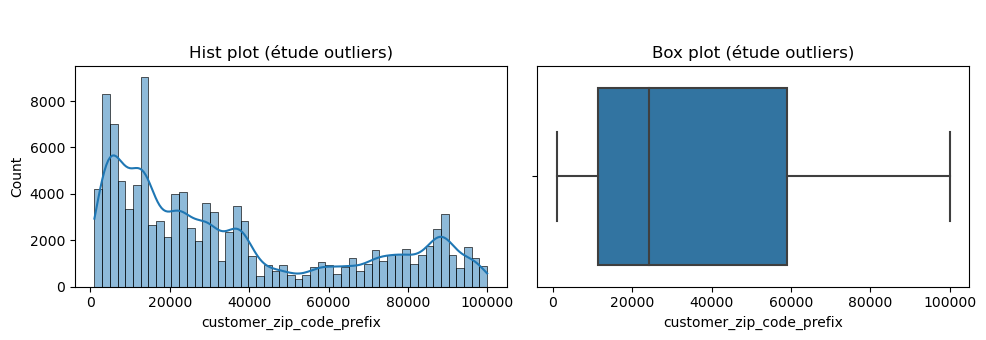








 ##############################         payment_sequential         ##############################
min				= 1 
max				= 26
Q1				= 1.0 
Q3				= 1.0 
IQR				= 0.0
upper_limit			= 1.0
lower_limit			= 1.0
Nb outliers > upper_limit	= 4839
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


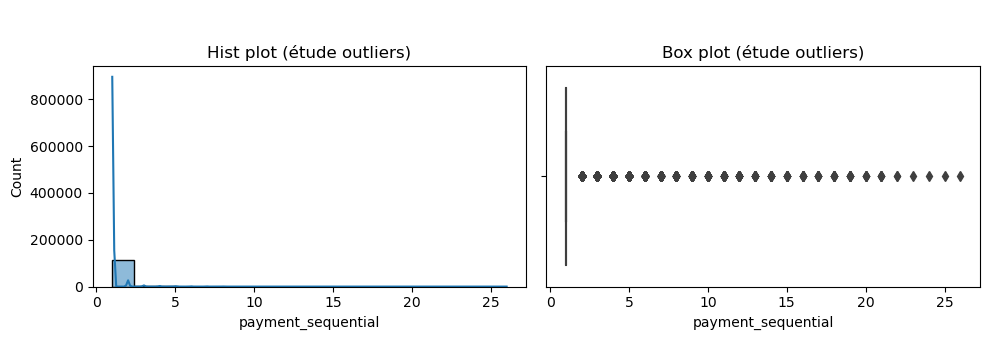








 ##############################         payment_installments         ##############################
min				= 0 
max				= 24
Q1				= 1.0 
Q3				= 4.0 
IQR				= 3.0
upper_limit			= 8.5
lower_limit			= -3.5
Nb outliers > upper_limit	= 7745
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


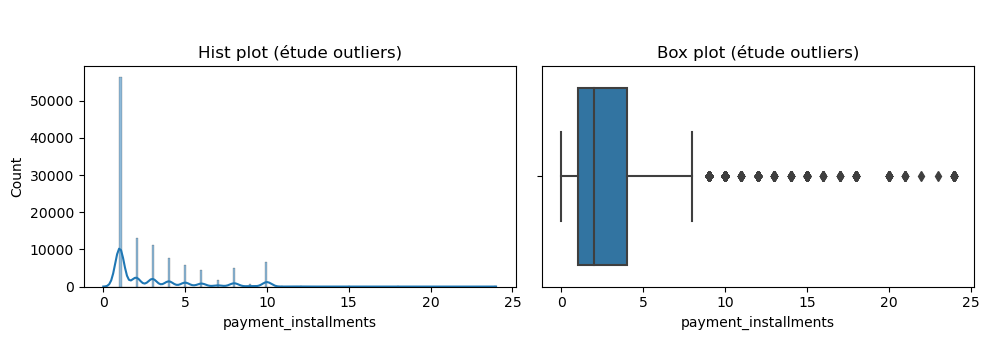








 ##############################         payment_value         ##############################
min				= 0.0 
max				= 13664.08
Q1				= 60.85 
Q3				= 189.15 
IQR				= 128.3
upper_limit			= 381.6
lower_limit			= -131.6
Nb outliers > upper_limit	= 9085
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


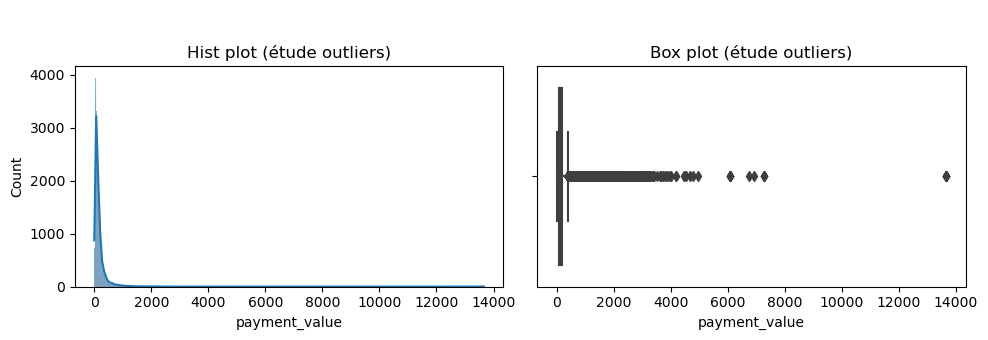








 ##############################         review_score         ##############################
min				= 1 
max				= 5
Q1				= 4.0 
Q3				= 5.0 
IQR				= 1.0
upper_limit			= 6.5
lower_limit			= 2.5
Nb outliers > upper_limit	= 0
Nb outliers < lower_limit	= 16704


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


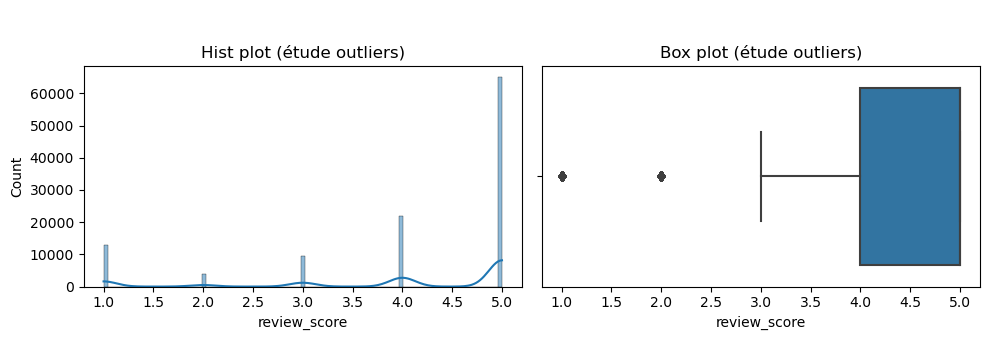








 ##############################         order_item_id         ##############################
min				= 1 
max				= 21
Q1				= 1.0 
Q3				= 1.0 
IQR				= 0.0
upper_limit			= 1.0
lower_limit			= 1.0
Nb outliers > upper_limit	= 14022
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


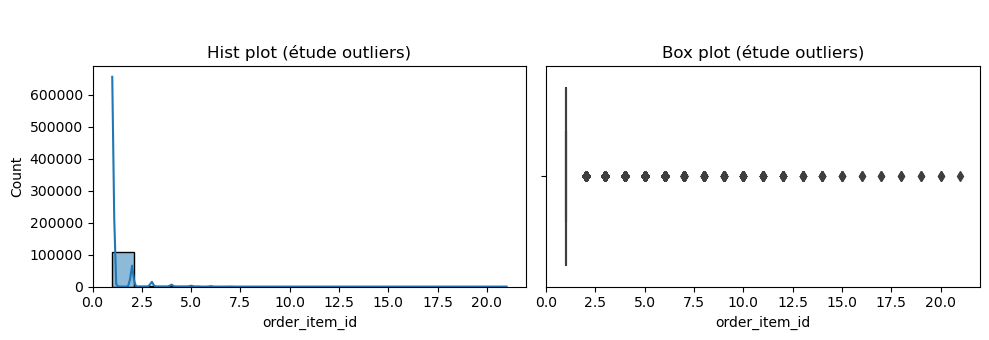








 ##############################         price         ##############################
min				= 0.85 
max				= 6735.0
Q1				= 39.9 
Q3				= 132.98 
IQR				= 93.07999999999998
upper_limit			= 272.6
lower_limit			= -99.72
Nb outliers > upper_limit	= 8469
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


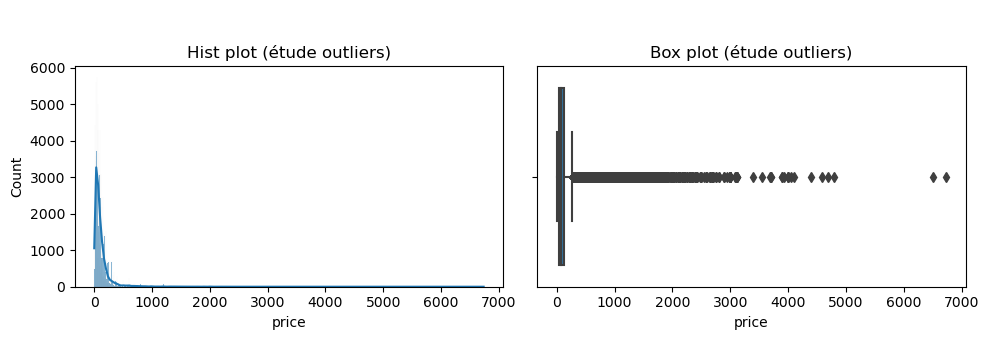








 ##############################         freight_value         ##############################
min				= 0.0 
max				= 409.68
Q1				= 13.08 
Q3				= 21.19 
IQR				= 8.110000000000001
upper_limit			= 33.36
lower_limit			= 0.91
Nb outliers > upper_limit	= 11628
Nb outliers < lower_limit	= 517


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


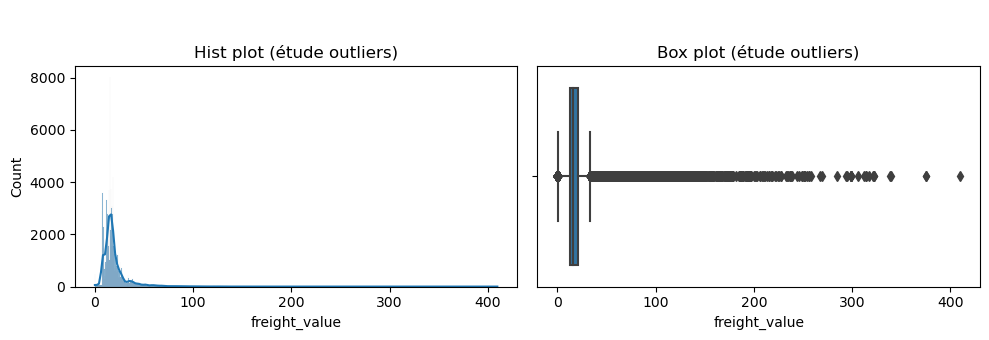








 ##############################         product_name_lenght         ##############################
min				= 5.0 
max				= 76.0
Q1				= 42.0 
Q3				= 57.0 
IQR				= 15.0
upper_limit			= 79.5
lower_limit			= 19.5
Nb outliers > upper_limit	= 0
Nb outliers < lower_limit	= 771


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


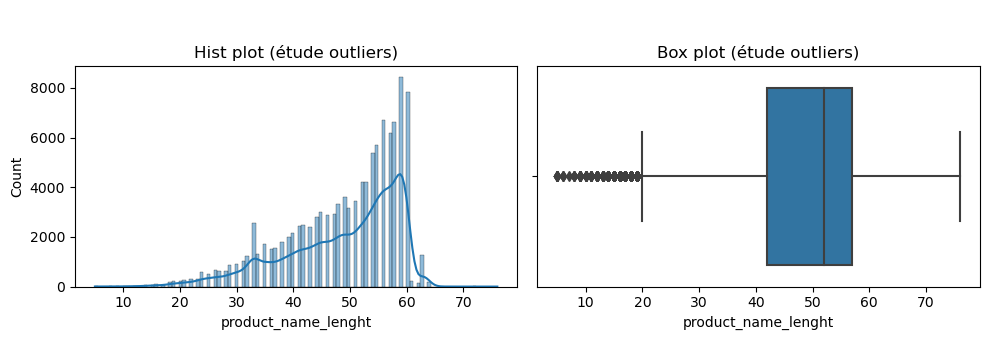








 ##############################         product_description_lenght         ##############################
min				= 4.0 
max				= 3992.0
Q1				= 346.0 
Q3				= 982.0 
IQR				= 636.0
upper_limit			= 1936.0
lower_limit			= -608.0
Nb outliers > upper_limit	= 7125
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


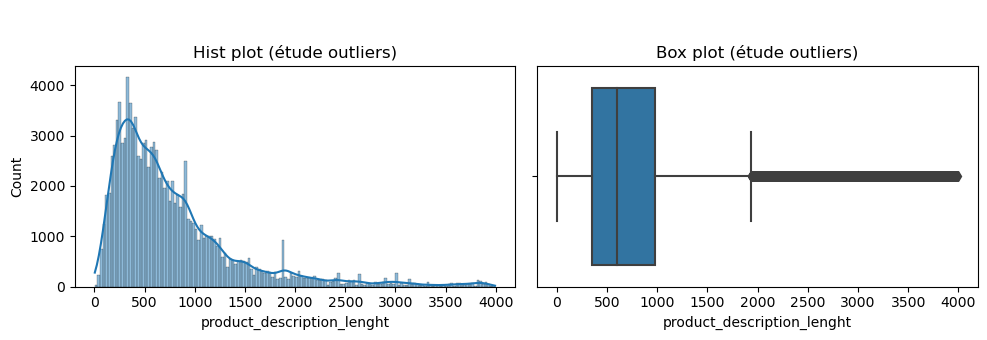








 ##############################         product_photos_qty         ##############################
min				= 1.0 
max				= 20.0
Q1				= 1.0 
Q3				= 3.0 
IQR				= 2.0
upper_limit			= 6.0
lower_limit			= -2.0
Nb outliers > upper_limit	= 3121
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


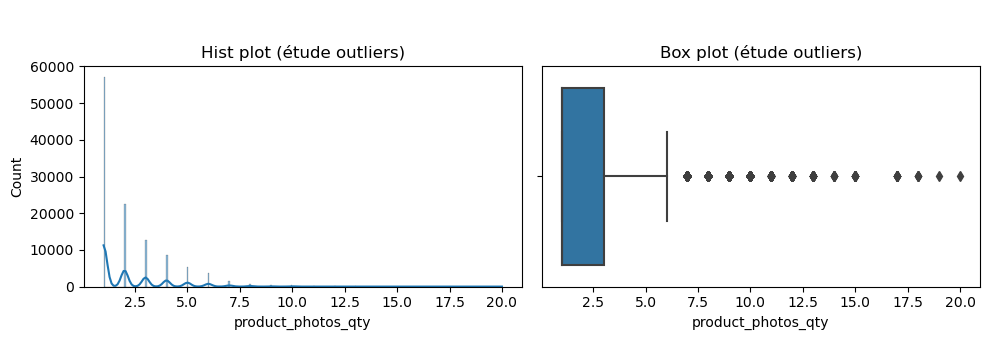








 ##############################         product_weight_g         ##############################
min				= 0.0 
max				= 40425.0
Q1				= 300.0 
Q3				= 1800.0 
IQR				= 1500.0
upper_limit			= 4050.0
lower_limit			= -1950.0
Nb outliers > upper_limit	= 15983
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


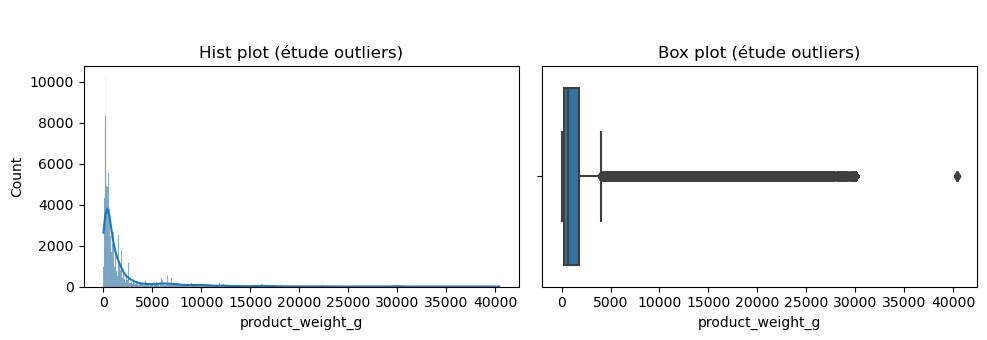








 ##############################         product_length_cm         ##############################
min				= 7.0 
max				= 105.0
Q1				= 18.0 
Q3				= 38.0 
IQR				= 20.0
upper_limit			= 68.0
lower_limit			= -12.0
Nb outliers > upper_limit	= 3624
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


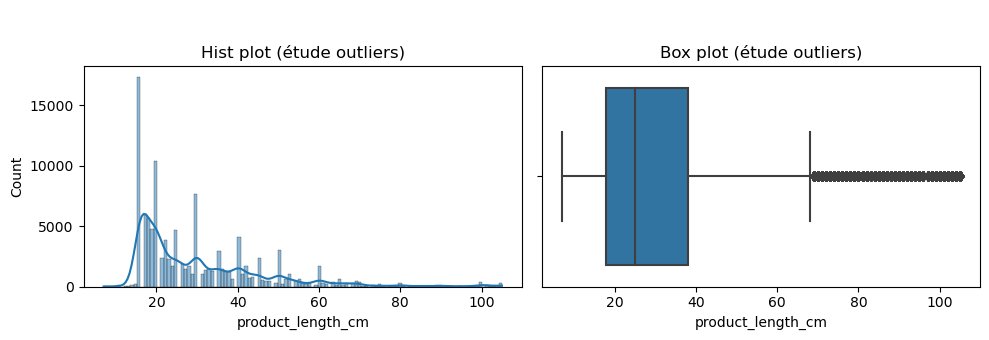








 ##############################         product_height_cm         ##############################
min				= 2.0 
max				= 105.0
Q1				= 8.0 
Q3				= 20.0 
IQR				= 12.0
upper_limit			= 38.0
lower_limit			= -10.0
Nb outliers > upper_limit	= 7728
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


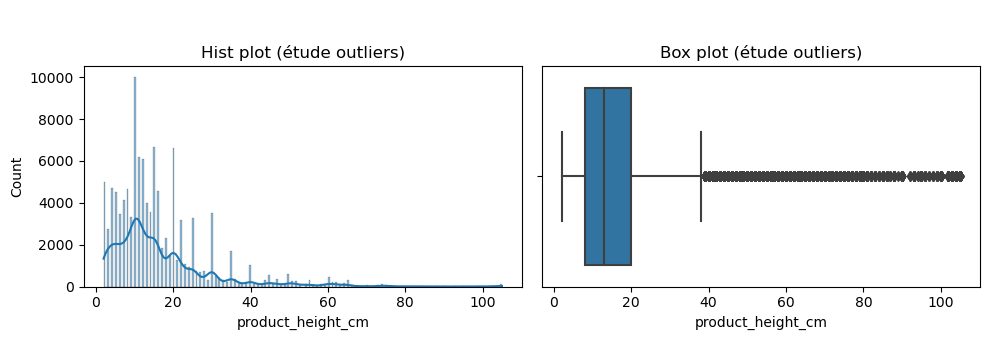








 ##############################         product_width_cm         ##############################
min				= 6.0 
max				= 118.0
Q1				= 15.0 
Q3				= 30.0 
IQR				= 15.0
upper_limit			= 52.5
lower_limit			= -7.5
Nb outliers > upper_limit	= 2622
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


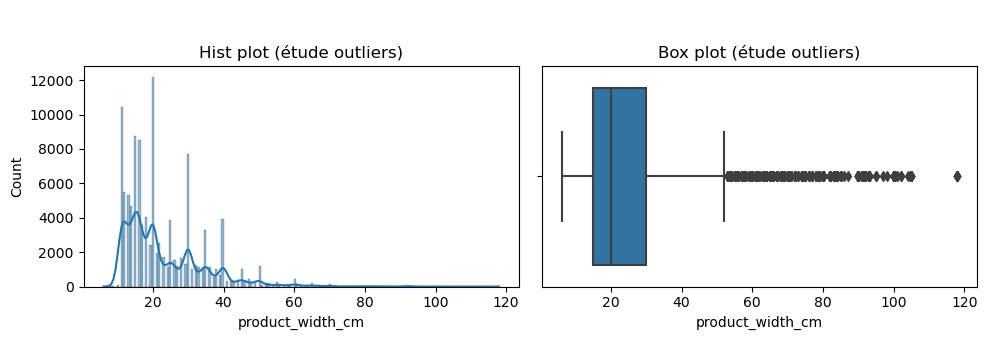








 ##############################         seller_zip_code_prefix         ##############################
min				= 1001 
max				= 99730
Q1				= 6429.0 
Q3				= 28495.0 
IQR				= 22066.0
upper_limit			= 61594.0
lower_limit			= -26670.0
Nb outliers > upper_limit	= 17535
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


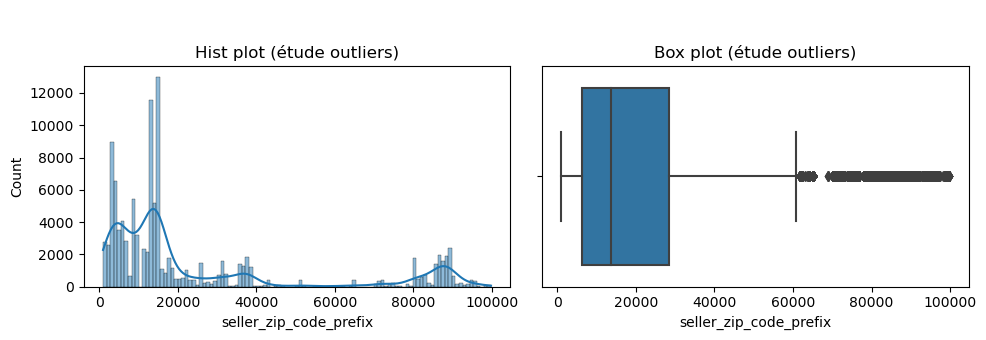

In [39]:
#######################################################
#      ANALYSE UNIVARIEE / VARIABLES NUMERIQUES       #
#######################################################
# IQR pour les variables numériques uniquement
# Calcul des outliers sans supprimer
for col in var_numerique:
    IQR(colonne_in = col, drop_in = False)
    IQR_plot(colonne_in = col, dataset_in = data_customers_orders)

# 2.4.2. VALEURS ABERRANTES / OUTLIERS (STRING)

In [ ]:
###########################################################################################
#   Colonnes clés : product_category_name, order_id, product_id, seller_id, customer_id,    #
###########################################################################################

In [40]:
# Suppression car les dataframes sont connectés. On ne garde que l'id client (customer_unique_id)
data_customers_orders.drop(['product_category_name', 'order_id', 'product_id', 'seller_id', 'customer_id'], 
                           axis = 1, inplace = True)

In [41]:
var_numerique = []
var_string = []

for col in data_customers_orders.columns:
    if is_numeric_dtype(data_customers_orders[col]):
        var_numerique.append(col)

print('var_numerique (updating)\t=', var_numerique)

var_numerique (updating)	= ['customer_zip_code_prefix', 'payment_sequential', 'payment_installments', 'payment_value', 'review_score', 'order_item_id', 'price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix']


In [ ]:
############################################
#          Colonne order_status            #
############################################

In [42]:
# Un client qui a annulé sa commande n'est pas un client => suppression des lignes 'canceled'    

# Affichage avant nettoyage
print(data_customers_orders['order_status'].value_counts())

# Commandes annulées
data_order_status_canceled = data_customers_orders[data_customers_orders['order_status'] == 'canceled']
#print('data_order_status_canceled :', data_order_status_canceled['order_status'].value_counts())

# Suppression lignes des commandes annulées
data_order_status_canceled_idx = data_order_status_canceled.index
print('\nSuppression lignes :', data_order_status_canceled_idx)
data_customers_orders.drop(data_order_status_canceled_idx, axis = 0, inplace = True)

# Suppression colonne 'order_status' (1 seul valeur)
data_customers_orders.drop(['order_status'], axis = 1, inplace = True)

delivered    113186
canceled          7
Name: order_status, dtype: int64

Suppression lignes : Int64Index([32060, 37250, 41953, 89138, 89357, 89414, 92912], dtype='int64')


In [43]:
# Variables string updating
var_string = []

for col in data_customers_orders.columns:
    if is_string_dtype(data_customers_orders[col]):
        var_string.append(col)        

print('\nvar_string (updating)\t=', var_string)


var_string (updating)	= ['customer_unique_id', 'customer_city', 'customer_state', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'payment_type', 'review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'shipping_limit_date', 'product_category_name_english', 'seller_city', 'seller_state']


In [44]:
# Affichage fréquence valeurs uniques
def affichage_frequence_valeurs(colonne_in):
    
    print('*'*7, ' '*3, colonne_in, ' '*3, '*'*7)
    
    # unique values (<=> valeur unique dans summary statistics)
    print('liste des', data_customers_orders[colonne_in].nunique(), 'valeurs uniques = ', data_customers_orders[colonne_in].unique(), '\n')

#    # nombre et fréquence de valeurs
#    print('nombre et fréquence de valeurs =\n', data_customers_orders[colonne_in].value_counts(), '\n\n')

In [45]:
# Boucle sur les features string
for col in var_string:
    affichage_frequence_valeurs(colonne_in = col)

*******     customer_unique_id     *******
liste des 91459 valeurs uniques =  ['861eff4711a542e4b93843c6dd7febb0' '9eae34bbd3a474ec5d07949ca7de67c0'
 '3c799d181c34d51f6d44bbbc563024db' ... '8d80e477643ec569b24592ce3d9dfc4c'
 '8c3c961a52bb5a0ffbce1d4e6d25cd67' '428f4721a509be8c52de6ec2900ba918'] 

*******     customer_city     *******
liste des 4071 valeurs uniques =  ['franca' 'santarem' 'nova santa rita' ... 'alto piquiri'
 'porto alegre do norte' 'ipupiara'] 

*******     customer_state     *******
liste des 27 valeurs uniques =  ['SP' 'PA' 'RS' 'RJ' 'SC' 'MG' 'MT' 'BA' 'ES' 'PR' 'MS' 'CE' 'RN' 'TO'
 'MA' 'GO' 'PI' 'PE' 'DF' 'PB' 'AL' 'SE' 'RO' 'AC' 'RR' 'AM' 'AP'] 

*******     order_purchase_timestamp     *******
liste des 93968 valeurs uniques =  ['2017-05-16 15:05:35' '2017-11-09 00:50:13' '2017-05-07 20:11:26' ...
 '2018-08-21 11:29:05' '2018-07-23 18:35:14' '2018-08-23 12:31:37'] 

*******     order_approved_at     *******
liste des 86565 valeurs uniques =  ['2017-05-16 15:22:1

liste des 94142 valeurs uniques =  ['2017-05-30 22:34:40' '2017-12-01 19:41:59' '2017-05-28 02:43:16' ...
 '2018-08-03 01:58:42' '2018-08-05 22:10:19' '2018-08-31 00:26:10'] 

*******     shipping_limit_date     *******
liste des 89528 valeurs uniques =  ['2017-05-22 15:22:12' '2017-11-23 00:47:18' '2017-05-22 22:22:56' ...
 '2018-07-30 09:17:39' '2018-08-02 17:50:12' '2018-08-28 03:24:24'] 

*******     product_category_name_english     *******
liste des 71 valeurs uniques =  ['office_furniture' 'sports_leisure' 'furniture_decor' 'auto' 'baby'
 'furniture_living_room' 'kitchen_dining_laundry_garden_furniture'
 'health_beauty' 'housewares' 'computers_accessories' 'toys'
 'garden_tools' 'pet_shop' 'watches_gifts' 'perfumery' 'stationery'
 'construction_tools_lights' 'cool_stuff' 'home_appliances'
 'signaling_and_security' 'construction_tools_construction' 'audio'
 'electronics' 'telephony' 'art' 'costruction_tools_tools'
 'musical_instruments' 'industry_commerce_and_business' 'food'
 'f

In [46]:
var_categorielle = ['customer_city', 'customer_state', 'payment_type', 'product_category_name_english',
                    'seller_city', 'seller_state']

# 2.4.2.1. ANALYSE UNIVARIEE

In [47]:
#######################################################
#     ANALYSE UNIVARIEE / VARIABLES CATEGORIELLES     # 
#######################################################
def analyse_univariee_var_categorielle(var_in, reduire_in):
    
    index = []
    
    if (reduire_in):
        for idx, name in enumerate(data_customers_orders[var_in].value_counts().index.tolist()):
#            print(data_customers_orders[var_in].value_counts()[idx], "\t:", name)            
            index.append(name)
        index = index[0:15]
        
        # On filtre les lignes avec var_in dans l'intervalle
        data_new = data_customers_orders.where(data_customers_orders[var_in].isin(index))

        plt.figure(figsize = (5,5))

        # >>>>>>> Pie chart
        data_new[var_in].value_counts(normalize = True).plot(kind = 'pie')
        plt.axis('equal') # Cette ligne assure que le pie chart est un cercle plutôt qu'une ellipse
        plt.show() # Affiche le graphique
        print('\n\n')
        
        # >>>>>>> Diagramme en tuyaux d'orgues
        #data_new['countries'].value_counts(normalize = True).plot(kind = 'bar')
        data_new[var_in].value_counts().plot(kind = 'bar')
        plt.show()

    else:
        # Diagramme en secteurs
        data_customers_orders[var_in].value_counts(normalize = True).plot(kind = 'pie')
        # Cette ligne assure que le pie chart est un cercle plutôt qu'une ellipse
        plt.axis('equal') 
        plt.show() # Affiche le graphique

        # Diagramme en tuyaux d'orgues
        #data['nutrition_grade_fr'].value_counts(normalize = True).plot(kind = 'bar')
        data_customers_orders[var_in].value_counts().plot(kind = 'bar')
        plt.show()

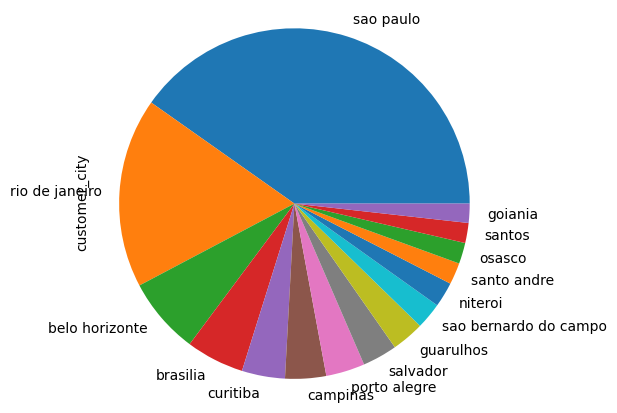

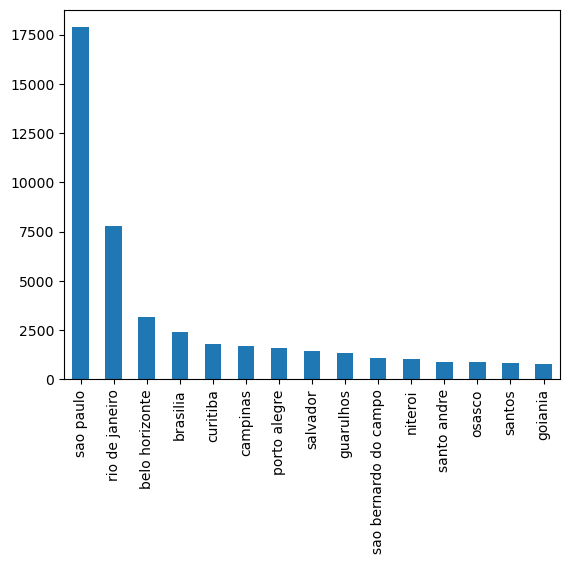

In [48]:
######################################################
#       Variable catégorielle customer_city          #
######################################################
analyse_univariee_var_categorielle(var_in = 'customer_city', reduire_in = True)

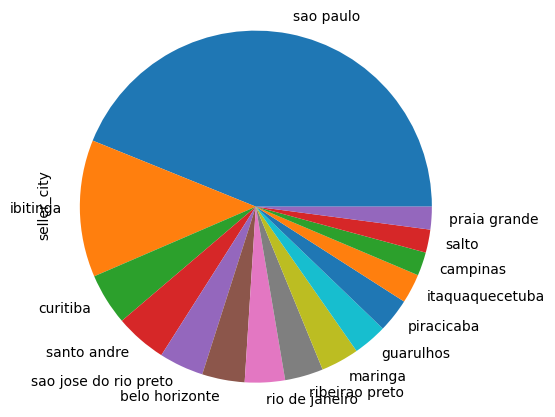

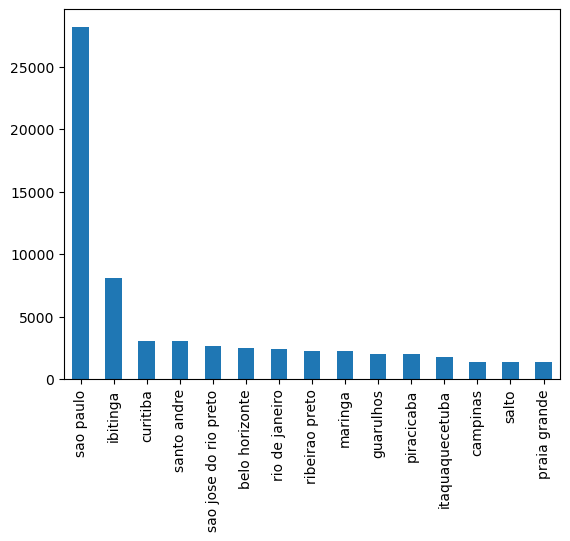

In [49]:
######################################################
#         Variable catégorielle seller_city          #
######################################################
analyse_univariee_var_categorielle(var_in = 'seller_city', reduire_in = True)

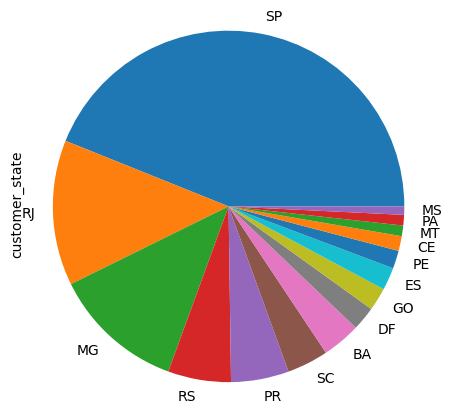

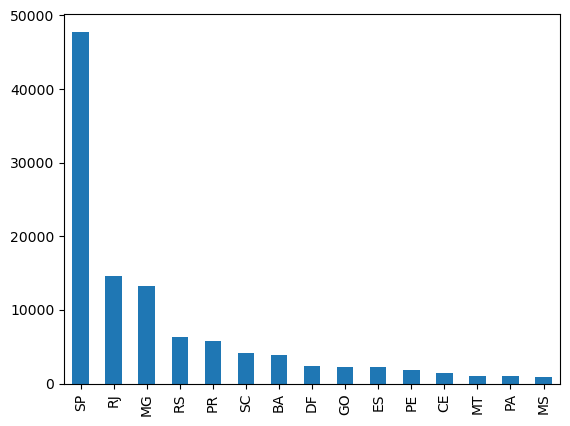

In [50]:
######################################################
#       Variable catégorielle customer_state         #
######################################################
analyse_univariee_var_categorielle(var_in = 'customer_state', reduire_in = True)

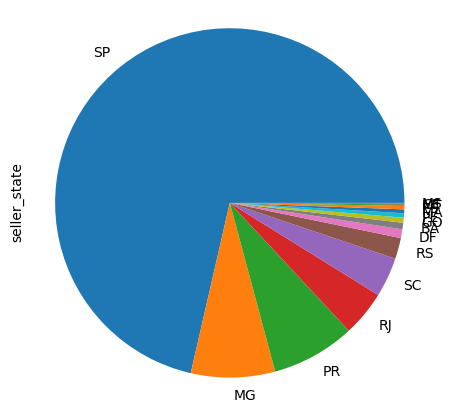

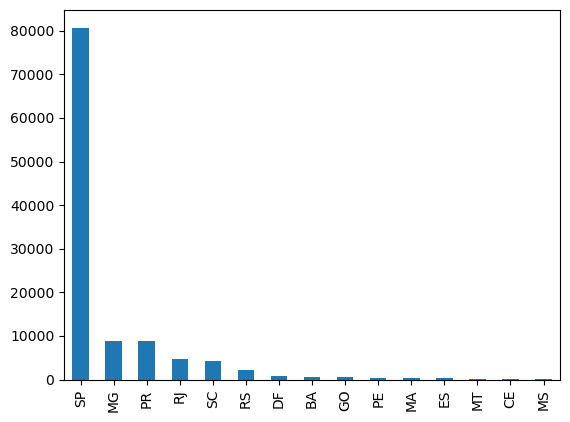

In [51]:
######################################################
#        Variable catégorielle seller_state          #
######################################################
analyse_univariee_var_categorielle(var_in = 'seller_state', reduire_in = True)

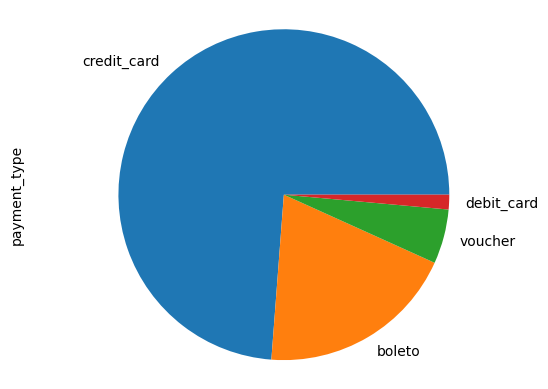

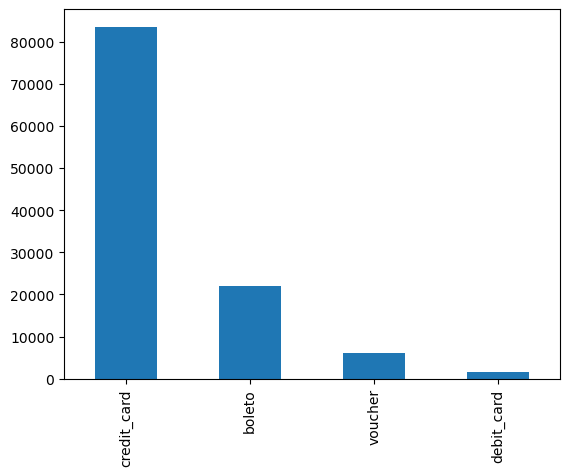

In [52]:
######################################################
#       Variable catégorielle payment_type           #
######################################################
analyse_univariee_var_categorielle(var_in = 'payment_type', reduire_in = False)

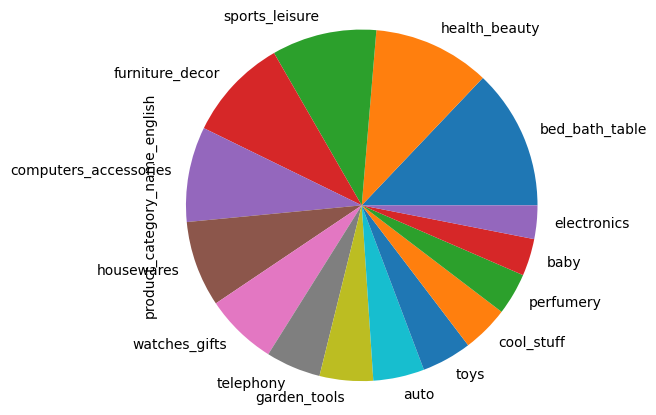

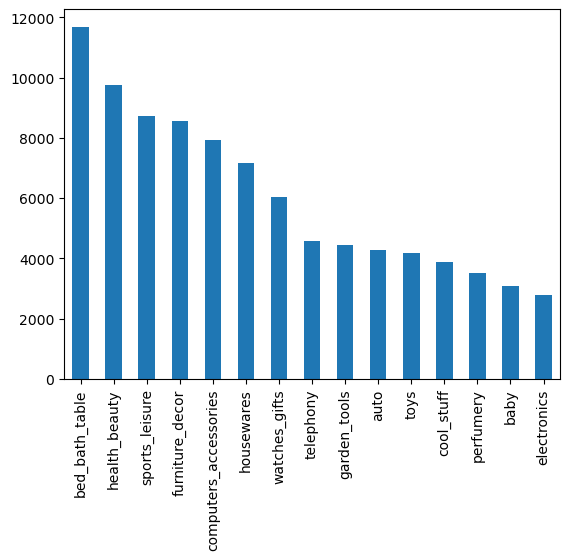

In [53]:
#######################################################
# Variable catégorielle product_category_name_english #
#######################################################
analyse_univariee_var_categorielle(var_in = 'product_category_name_english', reduire_in = True)

# 3. VISUALISATION

# 3.1. ANALYSE BIVARIEE

# 3.1.1. Graphique croisant 2 variables catégorielles

In [ ]:
#######################################################
#      ANALYSE BIVARIEE / VARIABLES CATEGORIELLES     #
#######################################################

In [54]:
# Affichage valeurs des 2 listes avec un index :
#    --> customer_xxx = customer_state, customer_city 
#    --> seller_xxx = seller_state, seller_city
def analyse_bivariee_var_categorielle_valeurs(var_customer_in, var_seller_in):
    index_customer_xxx = []
    index_seller_xxx   = []
    customer_xxx       = []
    seller_xxx         = []

    # customer_xxx
    for idx_1, name_1 in enumerate(data_customers_orders[var_customer_in].value_counts().index.tolist()):
#        print(data_customers_orders[var_customer_in].value_counts()[idx_1], "\t:", name_1)            
        index_customer_xxx.append(name_1)
        customer_xxx.append(data_customers_orders[var_customer_in].value_counts()[idx_1])
    print(var_customer_in, ':', len(index_customer_xxx), 'éléments :')
    print('\tindex_customer_xxx (20 premiers éléments) =', index_customer_xxx[0:20])
    print('\tcustomer_xxx (20 premiers éléments) =', customer_xxx[0:20], '\n')

    # seller_xxx
    for idx_2, name_2 in enumerate(data_customers_orders[var_seller_in].value_counts().index.tolist()):
#        print(data_customers_orders[var_seller_in].value_counts()[idx_2], "\t:", name_2)            
        index_seller_xxx.append(name_2)
        seller_xxx.append(data_customers_orders[var_seller_in].value_counts()[idx_2])
    print(var_seller_in, ':', len(index_seller_xxx), 'éléments :')
    print('\tindex_seller_xxx (20 premiers éléments) =', index_seller_xxx[0:20])
    print('\tseller_xxx (20 premiers éléments) =', seller_xxx[0:20], '\n')
    
    return index_customer_xxx, index_seller_xxx, customer_xxx, seller_xxx

In [55]:
# Construction d'une liste commune (customer_xxx a plus d'éléments)
def analyse_bivariee_var_categorielle_courbe(type_xxx_in, 
                                             index_customer_xxx_in, index_seller_xxx_in, 
                                             customer_xxx_in, seller_xxx_in):
    
    index_xxx = []
    customer  = []
    seller    = []

    customer  = customer_xxx_in.copy()
    index_xxx = index_customer_xxx_in.copy()

    # https://www.delftstack.com/fr/howto/python/how-to-find-the-index-of-an-element-in-a-list-in-python/
    for i_customer in index_xxx:  # index_xxx = index_customer_xxx
        seller_value = 0 # Initialisation au début de chaque itération
        index_customer = index_xxx.index(i_customer)

        # Rechercher même élément de la liste customer
        for i_seller in index_seller_xxx_in:
            if (i_seller == i_customer):
                index_seller = index_seller_xxx_in.index(i_seller)
                seller_value = seller_xxx_in[index_seller]
                break  # Sortie de la 1ère boucle
        seller.append(seller_value)  # Rq : si valeur pas trouvée, on met 0 (valeur d'initialisation)

#    print('customer =', customer, '\n')
#    print('seller =', seller, '\n')
#    print('index_xxx =', index_xxx, '\n')  



    ##############################
    #       Affichage            #
    ##############################
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
    # customer = [46438, 14183, 12870, 6098, 5608, 4013, 3701, 2236, 2209, 2151, 1752, 1429, 1038, 1030, 826, 784, 589,
    #            534, 524, 427, 370, 319, 262, 165, 88, 81, 40]
    # seller = [77815, 4743, 8684, 2185, 8620, 4119, 639, 524, 360, 838, 417, 97, 146, 0, 57, 398, 39, 54, 11, 0, 10, 0,
    #           6, 3, 0, 0, 0]
    # index_state = ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'BA', 'GO', 'ES', 'DF', 'PE', 'CE', 'MT', 'PA', 'MS', 'MA', 'PB',
    #               'RN', 'PI', 'AL', 'SE', 'TO', 'RO', 'AM', 'AC', 'AP', 'RR']

    # Pour plus de lisibilité, on limite à 20 éléments affichés
    df = pd.DataFrame({'customer': customer[0:20],
                       'seller': seller[0:20]}, index = index_xxx[0:20])

    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html : pandas.DataFrame.plot
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html : matplotlib.pyplot.bar
    if (type_xxx_in == 'state'):
        xxx = 'state'
    elif (type_xxx_in == 'city'):
        xxx = 'city'
    else:
        xxx = ''
 
    ax1 = df.plot.bar(figsize = (10, 4), 
                      title = 'Population of customer / seller % 20 first ' + xxx, 
                      xlabel = xxx, ylabel = 'number')

    ax2 = df.plot.bar(stacked = True, figsize = (10, 4),
                      title = 'Population of customer / seller % 20 first ' + xxx, 
                      xlabel = xxx, ylabel = 'number')

In [ ]:
##############################################
#        customer_state & seller_state       #
##############################################

In [56]:
index_customer_state, index_seller_state, customer_state, seller_state \
= analyse_bivariee_var_categorielle_valeurs(var_customer_in = 'customer_state', 
                                            var_seller_in   = 'seller_state')

customer_state : 27 éléments :
	index_customer_xxx (20 premiers éléments) = ['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'BA', 'DF', 'GO', 'ES', 'PE', 'CE', 'MT', 'PA', 'MS', 'MA', 'PB', 'RN', 'PI', 'AL']
	customer_xxx (20 premiers éléments) = [47810, 14563, 13215, 6310, 5790, 4142, 3844, 2397, 2305, 2268, 1795, 1480, 1060, 1056, 837, 807, 605, 553, 541, 438] 

seller_state : 22 éléments :
	index_seller_xxx (20 premiers éléments) = ['SP', 'MG', 'PR', 'RJ', 'SC', 'RS', 'DF', 'BA', 'GO', 'PE', 'MA', 'ES', 'MT', 'CE', 'MS', 'RN', 'PB', 'RO', 'PI', 'SE']
	seller_xxx (20 premiers éléments) = [80726, 8792, 8755, 4775, 4147, 2195, 920, 679, 527, 459, 400, 366, 146, 99, 59, 56, 39, 14, 11, 10] 



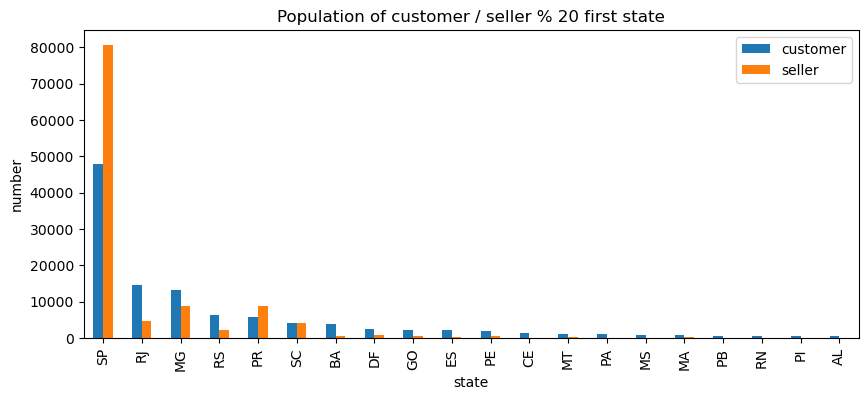

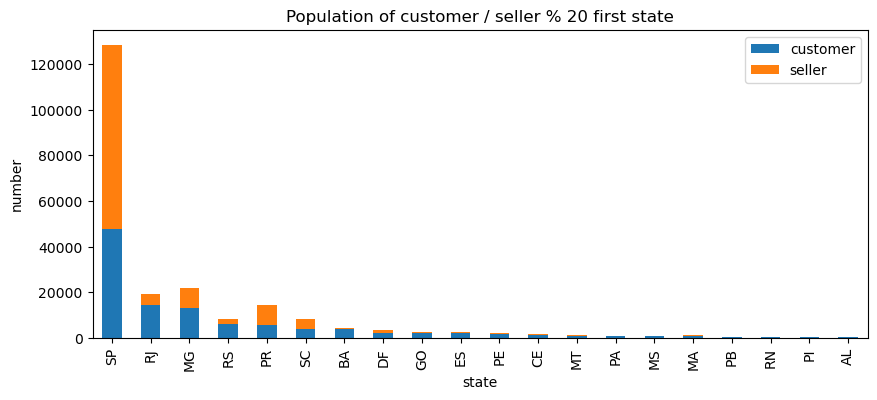

In [57]:
analyse_bivariee_var_categorielle_courbe(type_xxx_in           = 'state', 
                                         index_customer_xxx_in = index_customer_state,
                                         index_seller_xxx_in   = index_seller_state, 
                                         customer_xxx_in       = customer_state, 
                                         seller_xxx_in         = seller_state)

In [ ]:
##############################################
#         customer_city & seller_city        #
##############################################

In [58]:
index_customer_city, index_seller_city, customer_city, seller_city \
= analyse_bivariee_var_categorielle_valeurs(var_customer_in = 'customer_city', 
                                            var_seller_in   = 'seller_city')

customer_city : 4071 éléments :
	index_customer_xxx (20 premiers éléments) = ['sao paulo', 'rio de janeiro', 'belo horizonte', 'brasilia', 'curitiba', 'campinas', 'porto alegre', 'salvador', 'guarulhos', 'sao bernardo do campo', 'niteroi', 'santo andre', 'osasco', 'santos', 'goiania', 'sao jose dos campos', 'fortaleza', 'sorocaba', 'recife', 'florianopolis']
	customer_xxx (20 premiers éléments) = [17869, 7782, 3140, 2382, 1767, 1678, 1593, 1426, 1335, 1080, 1024, 887, 860, 820, 785, 781, 716, 704, 667, 654] 

seller_city : 587 éléments :
	index_seller_xxx (20 premiers éléments) = ['sao paulo', 'ibitinga', 'curitiba', 'santo andre', 'sao jose do rio preto', 'belo horizonte', 'rio de janeiro', 'ribeirao preto', 'maringa', 'guarulhos', 'piracicaba', 'itaquaquecetuba', 'campinas', 'salto', 'praia grande', 'campo limpo paulista', 'guariba', 'sao bernardo do campo', 'jacarei', 'brasilia']
	seller_xxx (20 premiers éléments) = [28204, 8097, 3057, 3053, 2633, 2512, 2367, 2265, 2252, 2010, 2002,

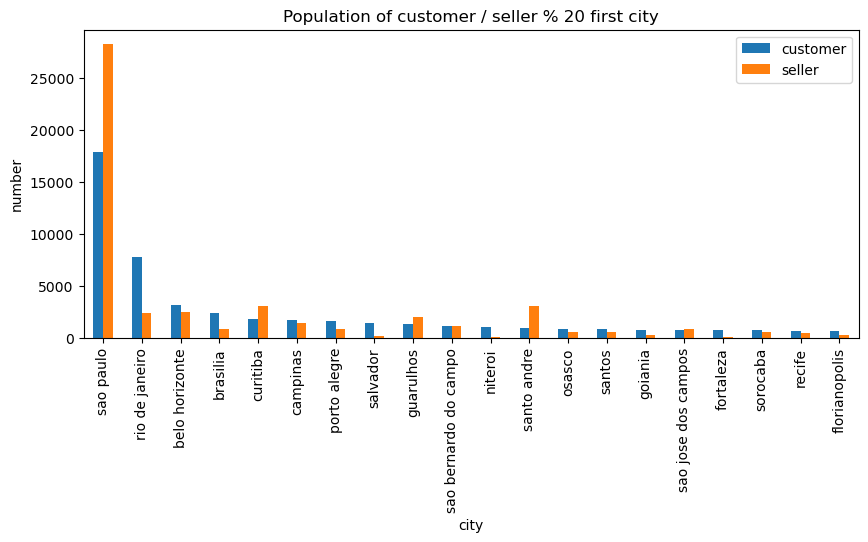

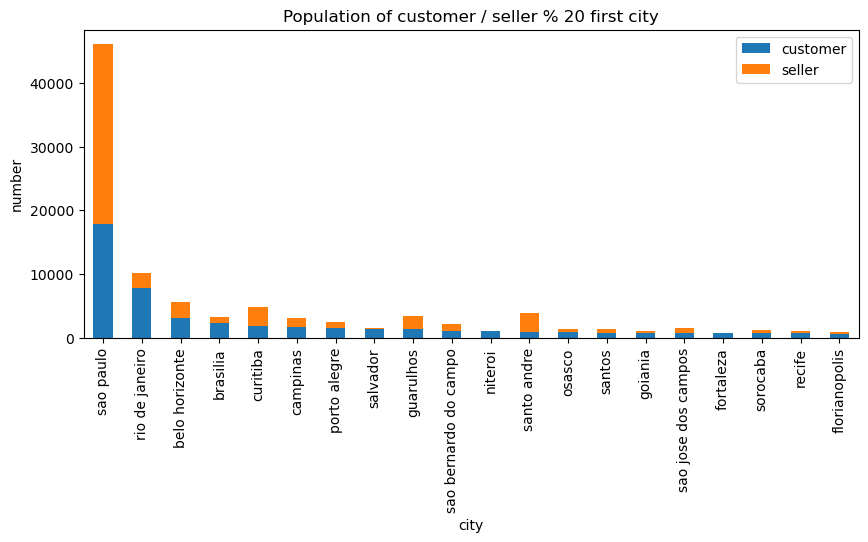

In [59]:
analyse_bivariee_var_categorielle_courbe(type_xxx_in           = 'city', 
                                         index_customer_xxx_in = index_customer_city,
                                         index_seller_xxx_in   = index_seller_city, 
                                         customer_xxx_in       = customer_city, 
                                         seller_xxx_in         = seller_city)

# 3.1.2. Graphique croisant une variable numérique et une catégorielle

In [60]:
print('Nombre de valeurs uniques :')
for var in var_categorielle:
    print(var, ':', data_customers_orders[var].nunique())
    
# Pour plus de clareté dans les schémas, nous prendrons les variables qui ont le moins de valeurs uniques : 
# customer_state, payment_type, product_category_name_english, seller_state.

Nombre de valeurs uniques :
customer_city : 4071
customer_state : 27
payment_type : 4
product_category_name_english : 71
seller_city : 587
seller_state : 22


In [61]:
print(var_numerique)

['customer_zip_code_prefix', 'payment_sequential', 'payment_installments', 'payment_value', 'review_score', 'order_item_id', 'price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix']


In [62]:
var_numerique_subset = ['payment_sequential', 'payment_installments', 'payment_value', 'review_score',
                        'price', 'freight_value', 'product_name_lenght', 'product_description_lenght', 
                        'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 
                        'product_width_cm']

In [ ]:
# |                      |                          VARIABLES CATEGORIELLES                             |
# | VARIABLES NUMERIQUES | payment_type | customer_state | seller_state | product_category_name_english |
# |----------------------|--------------|----------------|--------------|-------------------------------|
# | var_1                |       X      |       X        |      X       |               X               |
# |----------------------|--------------|----------------|--------------|-------------------------------|
# | var_2                |       X      |       X        |      X       |               X               |
# |----------------------|--------------|----------------|--------------|-------------------------------|
# | ...                  |       X      |       X        |      X       |               X               |
# |----------------------|--------------|----------------|--------------|-------------------------------|
# | var_3                |       X      |       X        |      X       |               X               |
# |----------------------|--------------|----------------|--------------|-------------------------------|

In [63]:
#####################################################################
#   Box plot pour 1 variable catégorielle et 1 variable numérique   #
#####################################################################
def box_plot(colonne_x_numerique_in, colonne_y_categorielle_in):
    
    size = data_customers_orders[colonne_y_categorielle_in].nunique()
    
    if (size < 30):
        plt.figure(figsize = (5, 5))
    else:
        plt.figure(figsize = (5, 12))  # largeur, hauteur
        
    sns.boxplot(x          = colonne_x_numerique_in, 
                y          = colonne_y_categorielle_in, 
                showfliers = False, # on supprime outliers
                orient     = 'h', 
                data       = data_customers_orders)
    
    plt.title('Box plot ' + colonne_x_numerique_in + ' % ' + colonne_y_categorielle_in)
#    plt.xlabel(colonne_x)
#    plt.ylabel(colonne_y_categorielle)
    plt.show()
    
    print('\n\n')

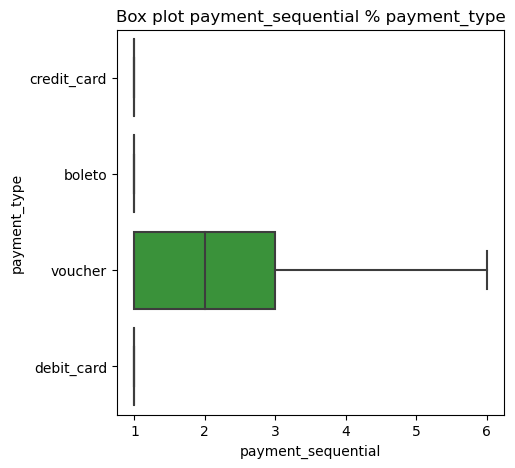

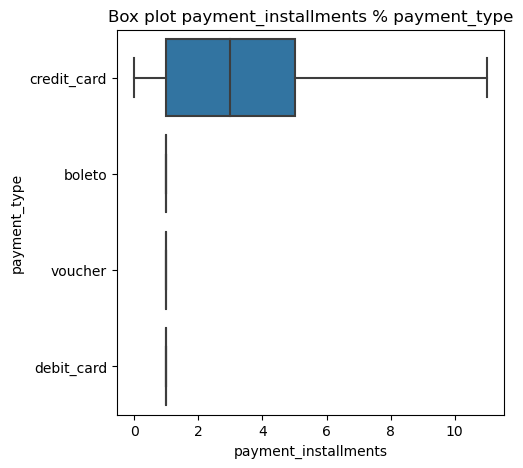

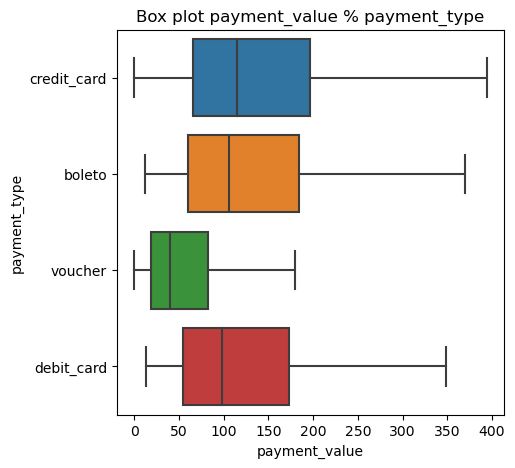

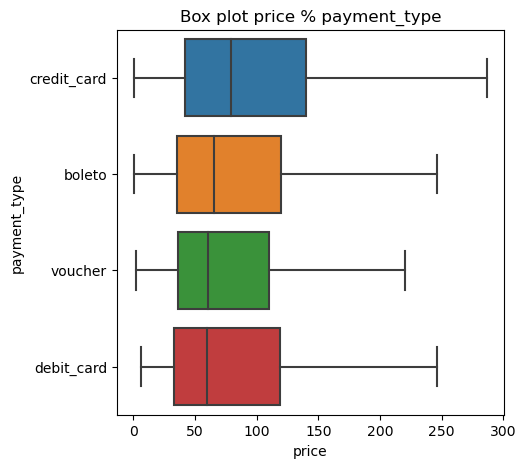

In [64]:
########################################################
# Box plot avec colonne_y_categorielle = payment_type  #
########################################################
colonne_y_categorielle = 'payment_type'

box_plot(colonne_x_numerique_in = 'payment_sequential',         colonne_y_categorielle_in = colonne_y_categorielle)
box_plot(colonne_x_numerique_in = 'payment_installments',       colonne_y_categorielle_in = colonne_y_categorielle)
box_plot(colonne_x_numerique_in = 'payment_value',              colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'review_score',               colonne_y_categorielle_in = colonne_y_categorielle)
box_plot(colonne_x_numerique_in = 'price',                      colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'freight_value',              colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_name_lenght',        colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_description_lenght', colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_photos_qty',         colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_weight_g',           colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_length_cm',          colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_height_cm',          colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_width_cm',           colonne_y_categorielle_in = colonne_y_categorielle)

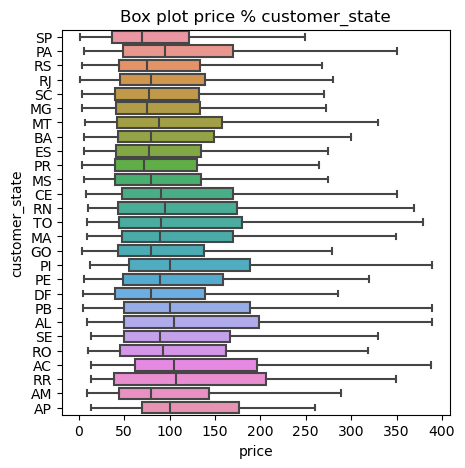

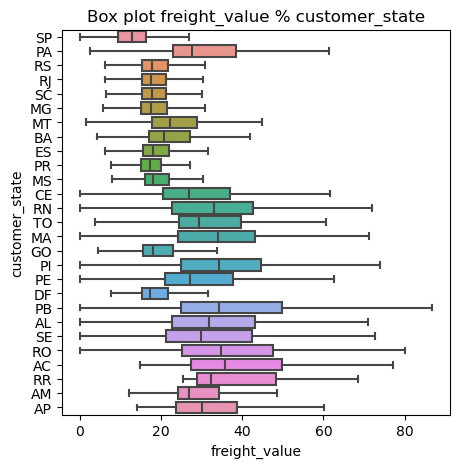

In [65]:
##########################################################
# Box plot avec colonne_y_categorielle = customer_state  #
##########################################################
colonne_y_categorielle = 'customer_state'

#box_plot(colonne_x_numerique_in = 'payment_sequential',         colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'payment_installments',       colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'payment_value',              colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'review_score',               colonne_y_categorielle_in = colonne_y_categorielle)
box_plot(colonne_x_numerique_in = 'price',                      colonne_y_categorielle_in = colonne_y_categorielle)
box_plot(colonne_x_numerique_in = 'freight_value',              colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_name_lenght',        colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_description_lenght', colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_photos_qty',         colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_weight_g',           colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_length_cm',          colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_height_cm',          colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_width_cm',           colonne_y_categorielle_in = colonne_y_categorielle)

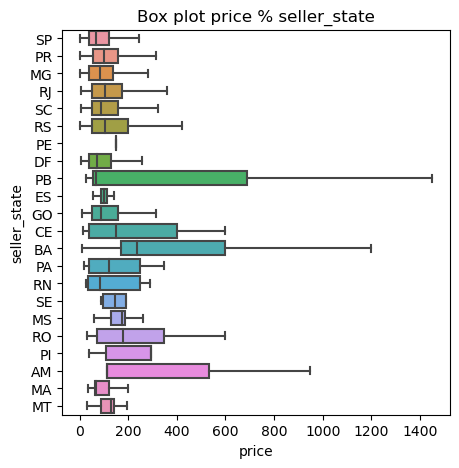

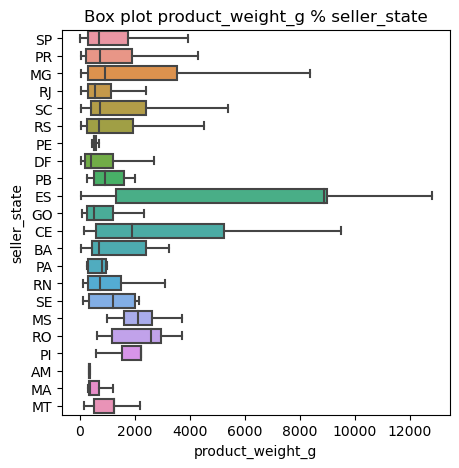

In [66]:
########################################################
# Box plot avec colonne_y_categorielle = seller_state  #
########################################################
colonne_y_categorielle = 'seller_state'

#box_plot(colonne_x_numerique_in = 'payment_sequential',         colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'payment_installments',       colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'payment_value',              colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'review_score',               colonne_y_categorielle_in = colonne_y_categorielle)
box_plot(colonne_x_numerique_in = 'price',                      colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'freight_value',              colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_name_lenght',        colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_description_lenght', colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_photos_qty',         colonne_y_categorielle_in = colonne_y_categorielle)
box_plot(colonne_x_numerique_in = 'product_weight_g',           colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_length_cm',          colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_height_cm',          colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_width_cm',           colonne_y_categorielle_in = colonne_y_categorielle)

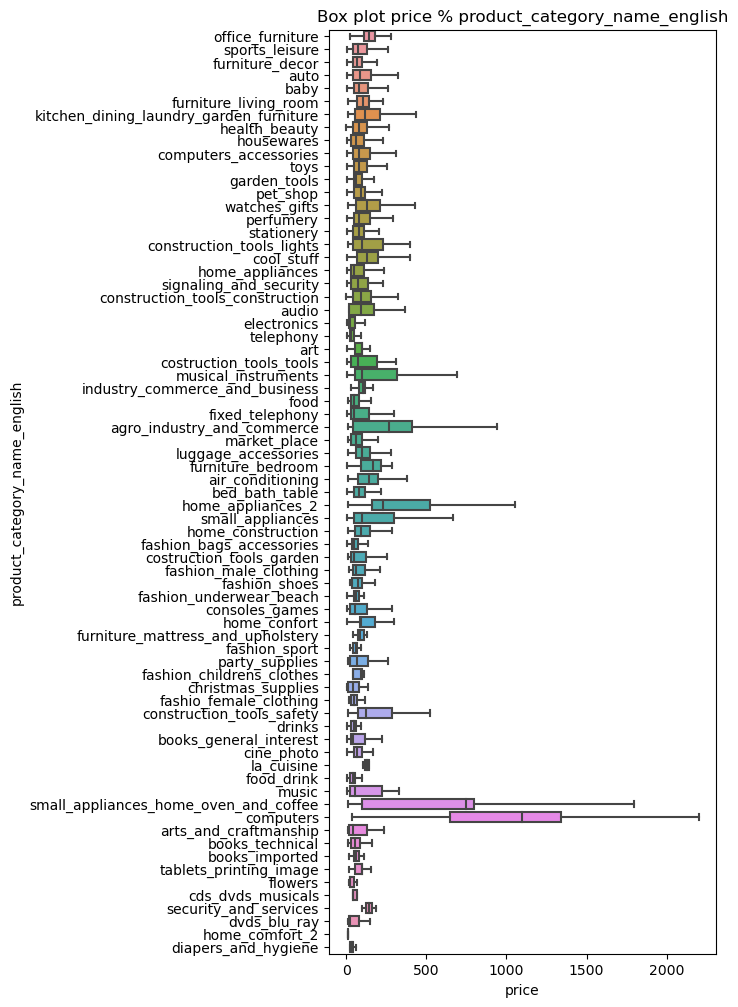

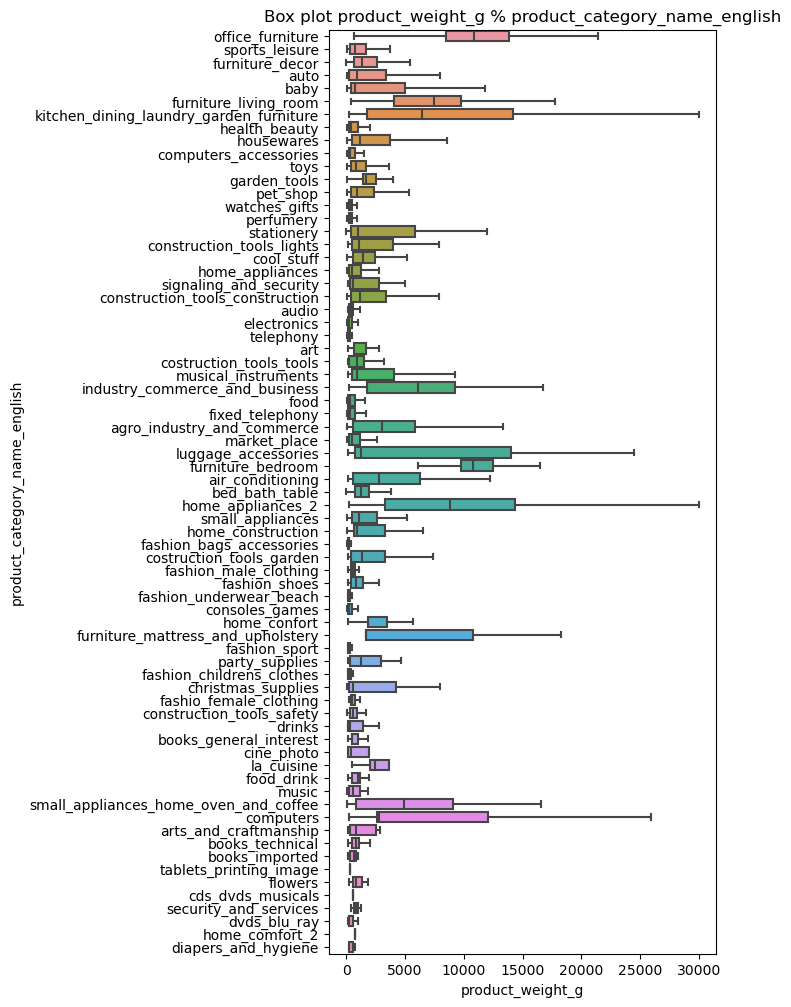

In [67]:
#########################################################################
# Box plot avec colonne_y_categorielle = product_category_name_english  #
#########################################################################
colonne_y_categorielle = 'product_category_name_english'

#box_plot(colonne_x_numerique_in = 'payment_sequential',         colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'payment_installments',       colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'payment_value',              colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'review_score',               colonne_y_categorielle_in = colonne_y_categorielle)
box_plot(colonne_x_numerique_in = 'price',                      colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'freight_value',              colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_name_lenght',        colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_description_lenght', colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_photos_qty',         colonne_y_categorielle_in = colonne_y_categorielle)
box_plot(colonne_x_numerique_in = 'product_weight_g',           colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_length_cm',          colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_height_cm',          colonne_y_categorielle_in = colonne_y_categorielle)
#box_plot(colonne_x_numerique_in = 'product_width_cm',           colonne_y_categorielle_in = colonne_y_categorielle)

# 3.1.3. Graphique croisant 2 variables numériques

In [ ]:
# |                     |                              VARIABLES NUMERIQUES                                     |
# | VARIABLES           | payment    |review | price|freight| product_name| product_descri| product | product   |
# | NUMERIQUES          | _value     |_score |      |_value | _lenght     | ption_lenght  | weight_g|_length_cm |
# |---------------------|------------|-------|------|-------|-------------|---------------|---------|-----------|
# | payment_value       |            |       |      |       |             |               |         |           |
# |---------------------|------------|-------|------|-------|-------------|---------------|---------|-----------|
# | review_score        |      X     |       |      |       |             |               |         |           |
# |---------------------|------------|-------|------|-------|-------------|---------------|---------|-----------|
# | price               |      X     |   X   |      |       |             |               |         |           |
# |---------------------|------------|-------|------|-------|-------------|---------------|---------|-----------|
# | freight_value       |      X     |   X   |   X  |       |             |               |         |           |
# |---------------------|------------|-------|------|-------|-------------|---------------|---------|-----------|
# | product_name_lenght |      X     |   X   |   X  |   X   |             |               |         |           |
# |---------------------|------------|-------|------|-------|-------------|---------------|---------|-----------|
# | product_descri      |      X     |   X   |   X  |   X   |      X      |               |         |           |
# | ption_lenght        |            |       |      |       |             |               |         |           |
# |---------------------|------------|-------|------|-------|-------------|---------------|---------|-----------|
# | product_weight_g    |      X     |   X   |   X  |   X   |      X      |      X        |         |           |
# |---------------------|------------|-------|------|-------|-------------|---------------|---------|-----------|
# | product_length_cm   |      X     |   X   |   X  |   X   |      X      |      X        |    X    |           |
# |---------------------|------------|-------|------|-------|-------------|---------------|---------|-----------|

In [68]:
# Couleurs  : https://matplotlib.org/stable/gallery/color/named_colors.html
# Marqueurs : https://matplotlib.org/stable/api/markers_api.html
        
################################################
#   Scatter plot pour 2 variables numériques   #
################################################
def scatter_plot(colonne_x, colonne_y, color_in, marker_in):
    
    plt.figure(figsize = (6,5)) # 6 is width, 5 is height

    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
    # Bp de points => pour + de lisibilité, on travaille sur un sous-ensemble (2000 points sur 109765)
    data_subset = data_customers_orders.sample(n = 2000, replace = True, random_state = 1)
    
    x = data_subset[colonne_x]
    y = data_subset[colonne_y]
    plt.scatter(x, y, color = color_in, marker = marker_in, alpha = 0.5)
    
    plt.title('Scatter plot ' + colonne_x + ' % ' + colonne_y)
    plt.xlabel(colonne_x)
    plt.ylabel(colonne_y)
    plt.show()
    
    print('\n\n')

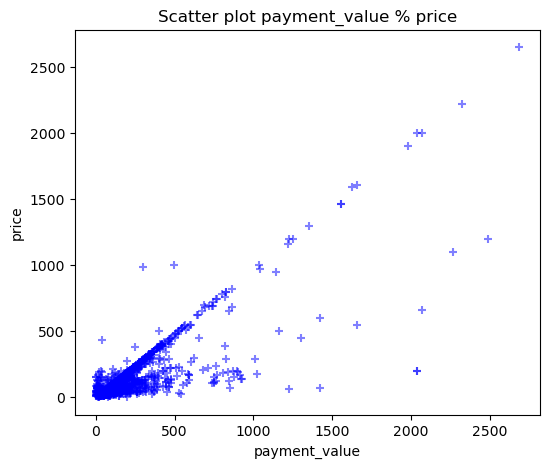

In [69]:
################################################
# Scatter plot avec colonne x = payment_value  #
###############################################
c = 'blue' # couleur
m = '+'    # marqueur
colonne_x = 'payment_value'

#scatter_plot(colonne_x = colonne_x, colonne_y = 'review_score',               color_in = c, marker_in = m)
scatter_plot(colonne_x = colonne_x, colonne_y = 'price',                       color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'freight_value',              color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_name_lenght',        color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_description_lenght', color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_weight_g',           color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_length_cm',          color_in = c, marker_in = m)

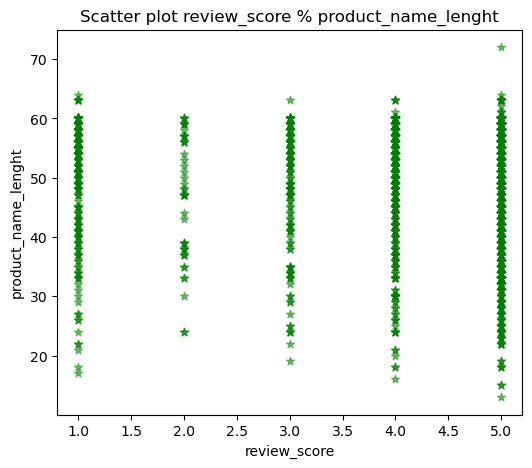

In [70]:
##############################################
# Scatter plot avec colonne x = review_score #
##############################################
c = 'green' # couleur
m = '*'     # marqueur
colonne_x = 'review_score'

#scatter_plot(colonne_x = colonne_x, colonne_y = 'price',                      color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'freight_value',              color_in = c, marker_in = m)
scatter_plot(colonne_x = colonne_x, colonne_y = 'product_name_lenght',        color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_description_lenght', color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_weight_g',           color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_length_cm',          color_in = c, marker_in = m)

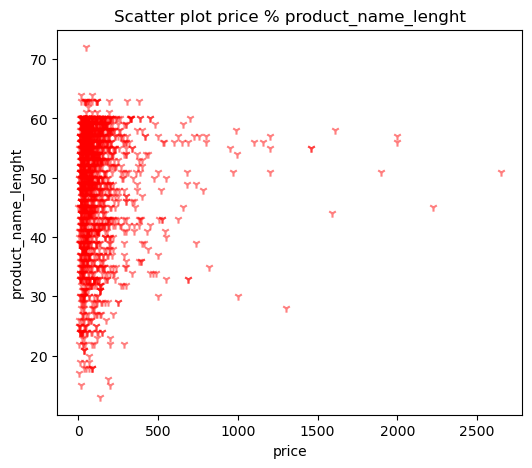

In [71]:
###############################################
# Scatter plot avec colonne x = price         #
###############################################
c = 'red' # couleur
m = '1'   # marqueur
colonne_x = 'price'

#scatter_plot(colonne_x = colonne_x, colonne_y = 'freight_value',              color_in = c, marker_in = m)
scatter_plot(colonne_x = colonne_x, colonne_y = 'product_name_lenght',        color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_description_lenght', color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_weight_g',           color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_length_cm',          color_in = c, marker_in = m)

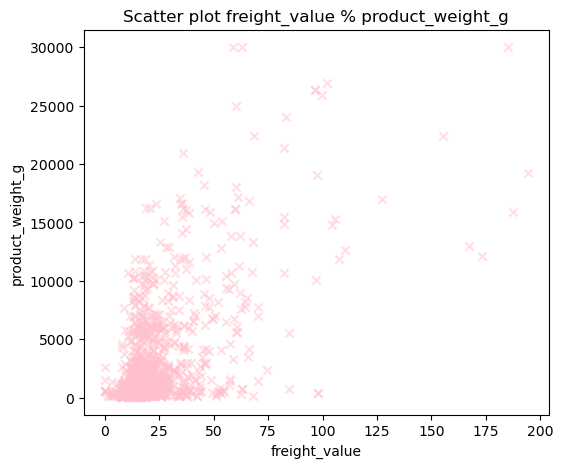

In [72]:
###############################################
# Scatter plot avec colonne x = freight_value #
###############################################
c = 'pink' # couleur
m = 'x'    # marqueur
colonne_x = 'freight_value'

#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_name_lenght',        color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_description_lenght', color_in = c, marker_in = m)
scatter_plot(colonne_x = colonne_x, colonne_y = 'product_weight_g',           color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_length_cm',          color_in = c, marker_in = m)

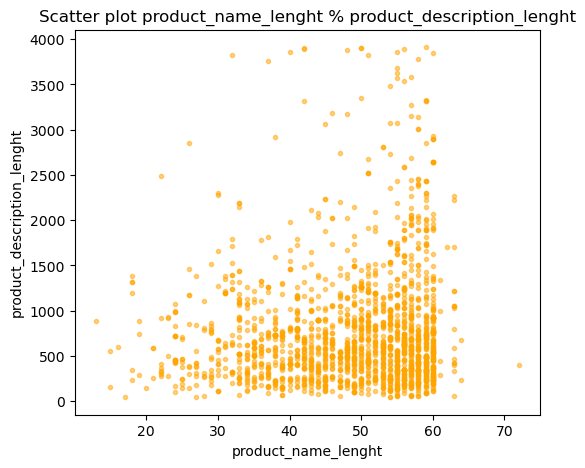

In [73]:
#####################################################
# Scatter plot avec colonne x = product_name_lenght #
#####################################################
c = 'orange' # couleur
m = '.'      # marqueur
colonne_x = 'product_name_lenght'

scatter_plot(colonne_x = colonne_x, colonne_y = 'product_description_lenght', color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_weight_g',           color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_length_cm',          color_in = c, marker_in = m)

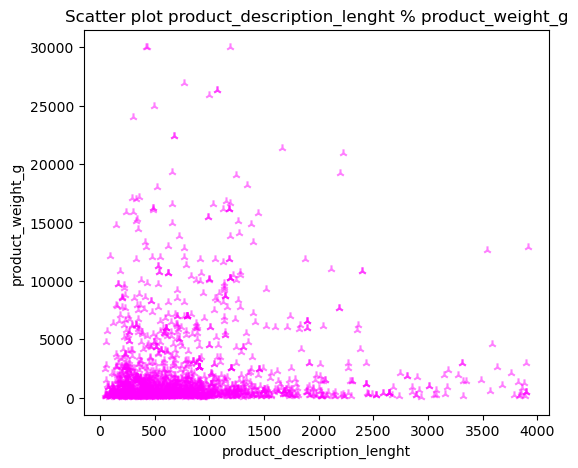

In [74]:
############################################################
# Scatter plot avec colonne x = product_description_lenght #
############################################################
c = 'magenta' # couleur
m = '2'       # marqueur
colonne_x = 'product_description_lenght'

scatter_plot(colonne_x = colonne_x, colonne_y = 'product_weight_g',  color_in = c, marker_in = m)
#scatter_plot(colonne_x = colonne_x, colonne_y = 'product_length_cm', color_in = c, marker_in = m)

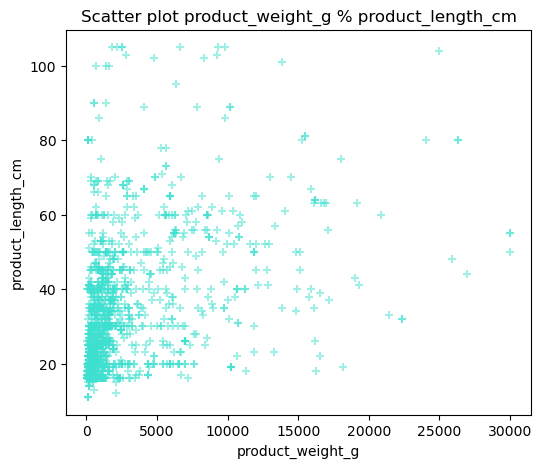

In [75]:
##################################################
# Scatter plot avec colonne x = product_weight_g #
##################################################
c = 'turquoise' # couleur
m = '+'         # marqueur
colonne_x = 'product_weight_g'

scatter_plot(colonne_x = colonne_x, colonne_y = 'product_length_cm', color_in = c, marker_in = m)

# 4. FEATURE ENGINEERING (DATAFRAME COMMANDE CENTRE)

In [ ]:
# https://towardsdatascience.com/what-is-feature-engineering-importance-tools-and-techniques-for-machine-learning-2080b0269f10
# https://towardsdatascience.com/feature-engineering-in-python-part-i-the-most-powerful-way-of-dealing-with-data-8e2447e7c69e
# https://blent.ai/blog/a/feature-engineering

# Feature engineering <=> aggrégation

# 4.1. DISTANCE CLIENT-VENDEUR

In [ ]:
################################################################
# Calcul geolocation_lat_mean et geolocation_long_mean         #
# à partir d'un même zip_code_prefix                           #
################################################################

In [76]:
print('******* df_geolocation :',
      '\n\t- shape =', df_geolocation.shape, '\n',
      '\n\t- nunique =\n', df_geolocation.nunique())

******* df_geolocation : 
	- shape = (1000163, 5) 
 
	- nunique =
 geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64


In [77]:
# Copie df_geolocation
df_geolocation_clean = df_geolocation.copy()
print(df_geolocation_clean.columns)

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')


In [78]:
# Suppression latitude et longitude qui existent dans le df initial
df_geolocation_clean.drop(['geolocation_lat', 'geolocation_lng'], axis = 1, inplace = True)

In [79]:
df_geolocation_clean.duplicated().sum()

972251

In [80]:
# Suppression des lignes en double
# https://apprendrepython.com/pandas-trouver-et-supprimer-les-lignes-dupliquees-de-dataframe-series/
# Par défaut, un nouveau DataFrame avec les lignes en double supprimées est renvoyé. Avec l’argument inplace = True, 
# les lignes en double sont supprimées du DataFrame d’origine.
df_geolocation_clean.drop_duplicates(keep = 'first', inplace = True)

In [81]:
print('******* df_geolocation_clean :',
      '\n\t- shape =', df_geolocation_clean.shape, '\n',
      '\n\t- nunique =\n', df_geolocation_clean.nunique())

******* df_geolocation_clean : 
	- shape = (27912, 3) 
 
	- nunique =
 geolocation_zip_code_prefix    19015
geolocation_city                8011
geolocation_state                 27
dtype: int64


In [82]:
# Maj colonnes geolocation_lat_mean et geolocation_long_mean (moyenne des coordonnées d'un même zip_code_prefix)
# du dataframe df_geolocation_clean. On calcule à partir de df_geolocation.

count = 0

# geolocation_state < geolocation_city < geolocation_zip_code_prefix
for index, row in df_geolocation_clean.iterrows():
    
    # dataframe contenant les lignes avec le même zip_code_prefix
    data_zip_code_prefix = df_geolocation[df_geolocation['geolocation_zip_code_prefix'] == row['geolocation_zip_code_prefix']]
    
    # Liste des lignes validant l'égalité
    row_indexer = data_zip_code_prefix.index       
    
    # Latitude ---> on prend la moyenne de la colonne pour ces lignes communes
    # https://ichi.pro/fr/un-moyen-vraiment-simple-de-modifier-ligne-par-ligne-dans-un-dataframe-pandas-129550068208403
    df_geolocation_clean.loc[index, 'geolocation_lat_mean'] = data_zip_code_prefix['geolocation_lat'].mean()
    
    # Longitude ---> on prend la moyenne de la colonne pour ces lignes communes
    df_geolocation_clean.loc[index, 'geolocation_lng_mean'] = data_zip_code_prefix['geolocation_lng'].mean()
    
    # Affichage uniquement des 5 premières lignes
    if (count < 5):
        print('index =', index, ', geolocation_zip_code_prefix =', row['geolocation_zip_code_prefix'],
              ', moyenne de', len(row_indexer), 'lignes',
              ', geolocation_lat_mean =', df_geolocation_clean.loc[index, 'geolocation_lat_mean'],
              ', geolocation_lng_mean =', df_geolocation_clean.loc[index, 'geolocation_lng_mean'])
    
    count = count + 1

index = 0 , geolocation_zip_code_prefix = 1037 , moyenne de 26 lignes , geolocation_lat_mean = -23.545411016454086 , geolocation_lng_mean = -46.63892437204838
index = 1 , geolocation_zip_code_prefix = 1046 , moyenne de 141 lignes , geolocation_lat_mean = -23.545930039168788 , geolocation_lng_mean = -46.6439975177819
index = 3 , geolocation_zip_code_prefix = 1041 , moyenne de 25 lignes , geolocation_lat_mean = -23.54390458746036 , geolocation_lng_mean = -46.64004648644473
index = 4 , geolocation_zip_code_prefix = 1035 , moyenne de 39 lignes , geolocation_lat_mean = -23.541614488738958 , geolocation_lng_mean = -46.64154914252655
index = 5 , geolocation_zip_code_prefix = 1012 , moyenne de 17 lignes , geolocation_lat_mean = -23.547789733146864 , geolocation_lng_mean = -46.63485900505736


In [83]:
print('******* df_geolocation_clean :',
      '\n\t- shape =', df_geolocation_clean.shape, '\n',
      '\n\t- nunique =\n', df_geolocation_clean.nunique())

******* df_geolocation_clean : 
	- shape = (27912, 5) 
 
	- nunique =
 geolocation_zip_code_prefix    19015
geolocation_city                8011
geolocation_state                 27
geolocation_lat_mean           19004
geolocation_lng_mean           19002
dtype: int64


In [84]:
df_geolocation_clean.head()

,geolocation_zip_code_prefix,geolocation_city,geolocation_state,geolocation_lat_mean,geolocation_lng_mean
0,1037,sao paulo,SP,-23.545411,-46.638924
1,1046,sao paulo,SP,-23.545930,-46.643998
3,1041,sao paulo,SP,-23.543905,-46.640046
4,1035,sao paulo,SP,-23.541614,-46.641549
5,1012,são paulo,SP,-23.547790,-46.634859


In [ ]:
################################################################
#   Colonnes customer_state, seller_state, geolocation_state   #
################################################################

In [85]:
def afficher_unique_values(df_in, col_in):
    
    print('col_in =', col_in, ':\n',
          '\t>', df_in[col_in].nunique(), 'valeurs uniques\n'
          '\t> valeurs = ', df_in[col_in].unique(), '\n')

In [86]:
afficher_unique_values(df_in = data_customers_orders, col_in = 'seller_state')
afficher_unique_values(df_in = data_customers_orders, col_in = 'customer_state')
afficher_unique_values(df_in = df_geolocation,        col_in = 'geolocation_state')

# geolocation_state contient toutes les customer_state etseller_state.

col_in = seller_state :
 	> 22 valeurs uniques
	> valeurs =  ['SP' 'PR' 'MG' 'RJ' 'SC' 'RS' 'PE' 'DF' 'PB' 'ES' 'GO' 'CE' 'BA' 'PA'
 'RN' 'SE' 'MS' 'RO' 'PI' 'AM' 'MA' 'MT'] 

col_in = customer_state :
 	> 27 valeurs uniques
	> valeurs =  ['SP' 'PA' 'RS' 'RJ' 'SC' 'MG' 'MT' 'BA' 'ES' 'PR' 'MS' 'CE' 'RN' 'TO'
 'MA' 'GO' 'PI' 'PE' 'DF' 'PB' 'AL' 'SE' 'RO' 'AC' 'RR' 'AM' 'AP'] 

col_in = geolocation_state :
 	> 27 valeurs uniques
	> valeurs =  ['SP' 'RN' 'AC' 'RJ' 'ES' 'MG' 'BA' 'SE' 'PE' 'AL' 'PB' 'CE' 'PI' 'MA'
 'PA' 'AP' 'AM' 'RR' 'DF' 'GO' 'RO' 'TO' 'MT' 'MS' 'RS' 'PR' 'SC'] 



In [ ]:
############################################################
#           Calcul coordonnées géographiques               #
############################################################

In [87]:
# Conversion d'un lieu décrit par 3 clés (zip code, city, state) en coordonnées géographiques (latitude / longitude)
def conversion_place_to_coord_geog(zip_code_prefix_in, city_in, state_in):
    
    # Initialisation
    lat_mean  = 0
    long_mean = 0
    
    
    data_coord = df_geolocation_clean[(df_geolocation_clean['geolocation_zip_code_prefix'] == zip_code_prefix_in) & 
                                      (df_geolocation_clean['geolocation_city']            == city_in) &
                                      (df_geolocation_clean['geolocation_state']           == state_in)]
    
    # Nombre d'éléments validant ces 3 critères
    taille_data_coord = len(data_coord.index)

        
    # Calcul coordonnées uniquement si les 3 clés correspondent à des élements dans le dataframe        
    if (taille_data_coord == 0):
        is_valid = False
    
    else:
        is_valid = True
        
        # Première ligne du df
        # https://www.delftstack.com/fr/howto/python-pandas/get-first-row-of-dataframe-pandas/
        row_1 = data_coord.iloc[0]
        
        lat_mean = row_1['geolocation_lat_mean']
        long_mean = row_1['geolocation_lng_mean']
    
#        print('zip_code_prefix_in =', zip_code_prefix_in, ', city_in =', city_in, ', state_in =', state_in,
#              ', taille_data_coord =', taille_data_coord, ', lat_mean =', lat_mean, ', long_mean =', long_mean)
        
    return is_valid, lat_mean, long_mean

In [88]:
# Conversion emplacement en coordonnées géographiques
def conversion_all_place_to_coord_geog(is_customer_in):

    # Lignes à supprimer i.e. contenant des incohérences
    lignes_a_supprimer = []
    count = 0
    
    # --------------------------------------------------------------------------------------
    # Start the stopwatch / counter
    # --------------------------------------------------------------------------------------
    time_start_sec = time.time()
    
    print('is_customer_in =', is_customer_in)
    
    # >>>>>>> Client
    if (is_customer_in):
        zip_code_prefix = 'customer_zip_code_prefix'
        city            = 'customer_city'
        state           = 'customer_state'
        latitude        = 'customer_lat'
        longitude       = 'customer_long'
    # >>>>>>> Vendeur
    else:
        zip_code_prefix = 'seller_zip_code_prefix'
        city            = 'seller_city'
        state           = 'seller_state'
        latitude        = 'seller_lat'
        longitude       = 'seller_long'
        

    # Conversion d'un lieu décrit par 3 clés (zip code, city, state) en coordonnées géographiques (latitude, longitude)        
    for index, row in data_customers_orders.iterrows():
        
        is_valid, lat, long = conversion_place_to_coord_geog(zip_code_prefix_in = row[zip_code_prefix],
                                                             city_in            = row[city], 
                                                             state_in           = row[state])
        
        if (is_valid):
            data_customers_orders.loc[index, latitude]  = lat
            data_customers_orders.loc[index, longitude] = long
            
            # Affichage uniquement des 5 premières lignes
            if (count < 5):
                print('index =', index, ',', zip_code_prefix, '=', row[zip_code_prefix],
                      ',', city, '=', row[city], ',', state, '=', row[state], 
                      ',', latitude, '=', data_customers_orders.loc[index, latitude], 
                      ',', longitude, '=', data_customers_orders.loc[index, longitude])
            count = count + 1
            
    # --------------------------------------------------------------------------------------
    # Stop the stopwatch / counter
    # --------------------------------------------------------------------------------------
    # https://inside-machinelearning.com/obtenir-le-temps-dexecution-de-votre-code-python-facilement/
    # Delta time in seconds
    delta_time_sec = time.time() - time_start_sec
    
    # Delta time in minutes
    delta_time_min = delta_time_sec / 60
    
    print('Durée programme : {:.3f}'.format(delta_time_sec), 'sec ou {:.3f}'.format(delta_time_min), 'min')   

In [89]:
# Conversion emplacement en coordonnées géographiques pour le client
conversion_all_place_to_coord_geog(is_customer_in = True) # 8 min

is_customer_in = True
index = 0 , customer_zip_code_prefix = 14409 , customer_city = franca , customer_state = SP , customer_lat = -20.498488755380297 , customer_long = -47.39692948590099
index = 1 , customer_zip_code_prefix = 68030 , customer_city = santarem , customer_state = PA , customer_lat = -2.4422084535318045 , customer_long = -54.723442527551576
index = 2 , customer_zip_code_prefix = 68030 , customer_city = santarem , customer_state = PA , customer_lat = -2.4422084535318045 , customer_long = -54.723442527551576
index = 3 , customer_zip_code_prefix = 92480 , customer_city = nova santa rita , customer_state = RS , customer_lat = -29.86087323102249 , customer_long = -51.27283476987694
index = 4 , customer_zip_code_prefix = 25931 , customer_city = mage , customer_state = RJ , customer_lat = -22.615268497162027 , customer_long = -43.17121156912527
Durée programme : 457.517 sec ou 7.625 min


In [90]:
# Conversion emplacement en coordonnées géographiques pour le vendeur
conversion_all_place_to_coord_geog(is_customer_in = False) # 7 min

is_customer_in = False
index = 0 , seller_zip_code_prefix = 8577 , seller_city = itaquaquecetuba , seller_state = SP , seller_lat = -23.486111454662215 , seller_long = -46.366720765317105
index = 1 , seller_zip_code_prefix = 8577 , seller_city = itaquaquecetuba , seller_state = SP , seller_lat = -23.486111454662215 , seller_long = -46.366720765317105
index = 2 , seller_zip_code_prefix = 8577 , seller_city = itaquaquecetuba , seller_state = SP , seller_lat = -23.486111454662215 , seller_long = -46.366720765317105
index = 3 , seller_zip_code_prefix = 8577 , seller_city = itaquaquecetuba , seller_state = SP , seller_lat = -23.486111454662215 , seller_long = -46.366720765317105
index = 4 , seller_zip_code_prefix = 8577 , seller_city = itaquaquecetuba , seller_state = SP , seller_lat = -23.486111454662215 , seller_long = -46.366720765317105
Durée programme : 438.579 sec ou 7.310 min


In [91]:
# Vérification présence de valeurs NaN
nb_na = data_customers_orders.isnull().sum()
nb_na[nb_na > 0]

customer_lat      345
customer_long     345
seller_lat       3086
seller_long      3086
dtype: int64

In [92]:
# Suppression des lignes avec des données manquantes pour 'customer_lat' et 'seller_lat'
for col in ['customer_lat', 'seller_lat']:
    index_with_nan = data_customers_orders.index[data_customers_orders[col].isnull()]
    print(col, ':', 'index_with_nan shape =', index_with_nan.shape)

    data_customers_orders.drop(index_with_nan, axis = 0, inplace = True)

customer_lat : index_with_nan shape = (345,)
seller_lat : index_with_nan shape = (3076,)


In [93]:
# Vérification présence de valeurs NaN
nb_na = data_customers_orders.isnull().sum()
nb_na[nb_na > 0]

Series([], dtype: int64)

In [94]:
######################################################################################
#   DISTANCE CLIENT-VENDEUR (EN PRENANT LES COORDONNEES GEOGRAPHIQUES):              #
#   ---> customer_lat, customer_long                                                 #
#       (calculé à partir de customer_zip_code_prefix, customer_city, customer_state #
#   ---> seller_lat, seller_long                                                     #
#       (calculé à partir de seller_zip_code_prefix, seller_city, seller_state       #
######################################################################################

# https://www.geeksforgeeks.org/python-calculate-distance-between-two-places-using-geopy/
# Geodesic Distance:
# It is the length of the shortest path between 2 points on any surface. In our case, the surface is the earth. 
# We calculate geodesic distance from latitude-longitude data.
# Exemple : kolkata = (22.5726, 88.3639)
#           delhi   = (28.7041, 77.1025)

def calcul_distance_client_vendeur():

    # --------------------------------------------------------------------------------------
    # Start the stopwatch / counter
    # --------------------------------------------------------------------------------------
    time_start_sec = time.time()
    count = 0
        
        
    for index, row in data_customers_orders.iterrows():
               
        # Coordonnées géographiques (latitude, longitude)
        # >>>>>>> Client
        coord_geog_customer = (row['customer_lat'], row['customer_long'])
        
        # >>>>>>> Vendeur
        coord_geog_seller = (row['seller_lat'], row['seller_long'])
            
        # Distance (km) entre client et vendeur
        distance_km = round(geodesic(coord_geog_customer, coord_geog_seller).km, 3)
    
        # Enregistrement dans une nouvelle colonne
        data_customers_orders.loc[index, 'distance_client_vendeur_km'] = distance_km
    
        # Affichage uniquement des 5 premières lignes
        if (count < 5):
            print('index =', index, ', customer_state =', row['customer_state'], ', seller_state =', row['seller_state'],
                 ', distance_client_vendeur_km =', data_customers_orders.loc[index, 'distance_client_vendeur_km'])
        count = count + 1
        

    # --------------------------------------------------------------------------------------
    # Stop the stopwatch / counter (format HH:MM:SS)
    # --------------------------------------------------------------------------------------
    # https://inside-machinelearning.com/obtenir-le-temps-dexecution-de-votre-code-python-facilement/
    # Delta time in seconds
    delta_time_sec = time.time() - time_start_sec
    
    # Delta time in minutes
    delta_time_min = delta_time_sec / 60
    
    print('Durée programme : {:.3f}'.format(delta_time_sec), 'sec ou {:.3f}'.format(delta_time_min), 'min')

In [95]:
calcul_distance_client_vendeur()

index = 0 , customer_state = SP , seller_state = SP , distance_client_vendeur_km = 347.501
index = 1 , customer_state = PA , seller_state = SP , distance_client_vendeur_km = 2496.486
index = 2 , customer_state = PA , seller_state = SP , distance_client_vendeur_km = 2496.486
index = 3 , customer_state = RS , seller_state = SP , distance_client_vendeur_km = 858.436
index = 4 , customer_state = RJ , seller_state = SP , distance_client_vendeur_km = 341.383
Durée programme : 35.161 sec ou 0.586 min


In [96]:
# Vérification présence de valeurs NaN
nb_na = data_customers_orders.isnull().sum()
nb_na[nb_na > 0]

Series([], dtype: int64)


 ##############################         distance_client_vendeur_km         ##############################
min				= 0.0 
max				= 8652.12
Q1				= 189.17 
Q3				= 790.89 
IQR				= 601.72
upper_limit			= 1693.47
lower_limit			= -713.41
Nb outliers > upper_limit	= 8396
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


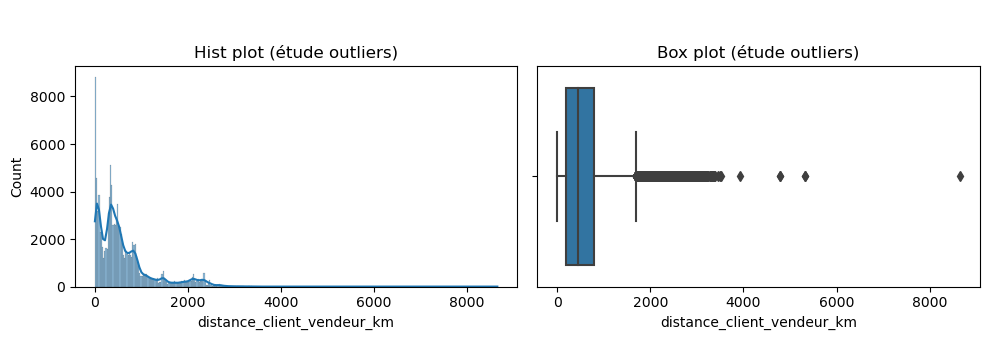

In [97]:
IQR(colonne_in = 'distance_client_vendeur_km', drop_in = False)
IQR_plot(colonne_in = 'distance_client_vendeur_km', dataset_in = data_customers_orders)

In [98]:
# Suppression colonnes ayant servi au calcul des coordonnées géographiques (client et vendeur)
data_customers_orders.drop(['customer_zip_code_prefix', 'customer_city', 'customer_state', 
                            'customer_lat', 'customer_long',
                            'seller_zip_code_prefix', 'seller_city', 'seller_state', 
                            'seller_lat', 'seller_long'],
                           axis = 1, inplace = True)

# 4.2. VOLUME PRODUIT

In [99]:
###################################################################
#   DIMENSIONS PRODUIT :                                          #
#   ---> product_length_cm, product_width_cm, product_height_cm   #
###################################################################
# Calcul volume du produit à partir de ses dimensions (length, width, height)
def calcul_product_volume():  
    
    count = 0   # Compteur
    
    for index, row in data_customers_orders.iterrows():
    
        length_cm = row['product_length_cm']
        width_cm  = row['product_width_cm']
        height_cm = row['product_height_cm']
        
        
        # Calcul volume (cm3)
        volume_cm3 = length_cm * width_cm * height_cm 
        
        # 1 dm3 = 1000 cm3 => conversion cm3 en dm3 en divisant par 1000
        data_customers_orders.loc[index, 'product_volume_dm3'] = volume_cm3 / 1000
        
        # Traces pour les 5 premières lignes uniquement (car volumineux)
        if (count < 5):
            print('index =', index, ': product_length_cm =', length_cm, ', product_width_cm =', width_cm,
                  ', product_height_cm =', height_cm, '\n\t=> product_volume_cm3 =', volume_cm3,
                  ', product_volume_dm3 =', data_customers_orders.loc[index, 'product_volume_dm3'], '\n')
            count = count + 1

In [100]:
calcul_product_volume()

index = 0 : product_length_cm = 54.0 , product_width_cm = 31.0 , product_height_cm = 64.0 
	=> product_volume_cm3 = 107136.0 , product_volume_dm3 = 107.136 

index = 1 : product_length_cm = 54.0 , product_width_cm = 31.0 , product_height_cm = 64.0 
	=> product_volume_cm3 = 107136.0 , product_volume_dm3 = 107.136 

index = 2 : product_length_cm = 54.0 , product_width_cm = 31.0 , product_height_cm = 64.0 
	=> product_volume_cm3 = 107136.0 , product_volume_dm3 = 107.136 

index = 3 : product_length_cm = 54.0 , product_width_cm = 31.0 , product_height_cm = 64.0 
	=> product_volume_cm3 = 107136.0 , product_volume_dm3 = 107.136 

index = 4 : product_length_cm = 54.0 , product_width_cm = 31.0 , product_height_cm = 64.0 
	=> product_volume_cm3 = 107136.0 , product_volume_dm3 = 107.136 



In [101]:
# Suppression colonnes ayant servi au calcul des diemnsions du produit
data_customers_orders.drop(['product_length_cm', 'product_width_cm', 'product_height_cm'], axis = 1, inplace = True)

# 4.3. DELAIS COMMANDE / ETAPE (APPROBATION, LIVRAISON ESTIMEE, LIVRAISON REELLE, AVIS)

In [ ]:
########################################################################
#   DELAIS COMMANDE / APPROBATION :                                    #
#   ---> order_purchase_timestamp, order_approved_at                   #
#                                                                      #
#   DELAIS COMMANDE / LIVRAISON ESTIMEE :                              #
#   ---> order_estimated_delivery_date                                 #
#                                                                      #
#   DELAIS COMMANDE / LIVRAISON REELLE :                               #
#   ---> order_delivered_carrier_date, order_delivered_customer_date   #
#                                                                      #
#   DELAIS COMMANDE / AVIS :                                           #
#   ---> review_creation_date                                          #
########################################################################

In [102]:
# https://stackoverflow.com/questions/34386751/pandas-convert-timestamp-to-datetime-date
# https://docs.python.org/3/library/datetime.html
# Calcul délais
def calcul_product_delais():  
    
    count = 0                # Compteur
    lignes_a_supprimer = []  # Stockage des lignes à supprimer

    for index, row in data_customers_orders.iterrows():
        # exemple : date = pd.Timestamp('2018-04-01 18:59:31')
        date_achat                  = pd.Timestamp(row['order_purchase_timestamp'])
        date_validation             = pd.Timestamp(row['order_approved_at'])
        date_livraison_estimee      = pd.Timestamp(row['order_estimated_delivery_date'])     
        date_livraison_transporteur = pd.Timestamp(row['order_delivered_carrier_date'])
        date_livraison_client       = pd.Timestamp(row['order_delivered_customer_date'])
        date_avis_client            = pd.Timestamp(row['review_creation_date'])

        # Calcul délais
        delta_validation             = date_validation.date()             - date_achat.date()
        delta_livraison_estimee      = date_livraison_estimee.date()      - date_achat.date()    
        delta_livraison_transporteur = date_livraison_transporteur.date() - date_achat.date()
        delta_livraison_client       = date_livraison_client.date()       - date_achat.date()
        delta_avis_client            = date_avis_client.date()            - date_achat.date()
        

        # Stockage et conversion délais (jours)
        # delta_xxx doit être positif, sinon on supprime la ligne (car on ne peut pas recevoir un colis futur dans le passé)
        if ((delta_validation.days < 0)             | (delta_livraison_estimee.days < 0) | 
            (delta_livraison_transporteur.days < 0) | (delta_livraison_client.days < 0) |
            (delta_avis_client.days < 0)):
            
            lignes_a_supprimer.append(index)
            
            print('=> index =', index, 'delta_xxx NEGATIF !!! : delta_validation =', delta_validation,
                  ', delta_livraison_estimee =', delta_livraison_estimee,
                  ', delta_livraison_transporteur =', delta_livraison_transporteur,
                  ', delta_livraison_client =', delta_livraison_client,
                  ', delta_avis_client =', delta_avis_client)
    
        else:
            data_customers_orders.loc[index, 'order_delta_validation_jour']             = delta_validation.days
            data_customers_orders.loc[index, 'order_delta_livraison_transporteur_jour'] = delta_livraison_transporteur.days
            data_customers_orders.loc[index, 'order_delta_livraison_client_jour']       = delta_livraison_client.days
            data_customers_orders.loc[index, 'review_delta_client_jour']                = delta_avis_client.days
            
            # Calcul de la ponctualité de la livraison : > 0 --> avance de x jours, < 0 --> retard de x jours
            # order_livraison_on_time est calculé à partir de delta_livraison_estimee => on ne sauvegarde que l'un des 2
            # dans les features (order_livraison_on_time)
            data_customers_orders.loc[index, 'order_livraison_on_time'] = delta_livraison_estimee.days - delta_livraison_client.days
        
        
            # Traces pour les 5 premières lignes uniquement (car volumineux)
            if (count < 5):
                print('index =', index, ':\n', 
                      '\t* date_achat\t\t\t=', date_achat, '\n',
                      
                      '\t* date_validation\t\t=', date_validation, 
                      '=> order_delta_validation_jour\t\t\t=', data_customers_orders.loc[index, 'order_delta_validation_jour'], '\n',
                      
                      '\t* date_livraison_transporteur\t=', date_livraison_transporteur,
                      '=> order_delta_livraison_transporteur_jour\t=', 
                      data_customers_orders.loc[index, 'order_delta_livraison_transporteur_jour'], '\n',
                      
                      '\t* date_livraison_client\t\t=', date_livraison_client,
                      '=> order_delta_livraison_client_jour\t\t=', 
                      data_customers_orders.loc[index, 'order_delta_livraison_client_jour'], '\n',
                      
                      '\t* date_livraison_estimee\t=', date_livraison_estimee, 
                      '=> order_delta_livraison_estimee_jour\t\t=', delta_livraison_estimee.days, '\n',
                      
                      '\t* date_avis_client\t=', date_avis_client,
                      '=> review_delta_client_jour\t\t=', data_customers_orders.loc[index, 'review_delta_client_jour'], '\n', 
                
                      '\t*', '.'*54, 'order_livraison_on_time\t\t\t=', 
                      data_customers_orders.loc[index, 'order_livraison_on_time'], '\n')                 
                
        # Maj compteur
        count = count + 1
                
                                                       
    # Suppression d'une liste de lignes : df.drop([1,5,7,9],0,inplace=True)
    # https://fr.moonbooks.org/Articles/Supprimer-une-ou-des-lignes-dun-tableau-de-donnees-DataFrame-avec-pandas-/
    data_customers_orders.drop(lignes_a_supprimer, axis = 0, inplace = True)
         
    print('\n==>', len(lignes_a_supprimer), 'lignes supprimées :', lignes_a_supprimer)

In [103]:
calcul_product_delais()

index = 0 :
 	* date_achat			= 2017-05-16 15:05:35 
 	* date_validation		= 2017-05-16 15:22:12 => order_delta_validation_jour			= 0.0 
 	* date_livraison_transporteur	= 2017-05-23 10:47:57 => order_delta_livraison_transporteur_jour	= 7.0 
 	* date_livraison_client		= 2017-05-25 10:35:35 => order_delta_livraison_client_jour		= 9.0 
 	* date_livraison_estimee	= 2017-06-05 00:00:00 => order_delta_livraison_estimee_jour		= 20 
 	* date_avis_client	= 2017-05-26 00:00:00 => review_delta_client_jour		= 10.0 
 	* ...................................................... order_livraison_on_time			= 11.0 

index = 1 :
 	* date_achat			= 2017-11-09 00:50:13 
 	* date_validation		= 2017-11-10 00:47:48 => order_delta_validation_jour			= 1.0 
 	* date_livraison_transporteur	= 2017-11-22 01:43:37 => order_delta_livraison_transporteur_jour	= 13.0 
 	* date_livraison_client		= 2017-11-28 00:09:50 => order_delta_livraison_client_jour		= 19.0 
 	* date_livraison_estimee	= 2017-12-19 00:00:00 => order_delta_

In [104]:
# Suppression des colonnes (sauf order_purchase_timestamp)
data_customers_orders.drop(['order_approved_at', 'order_estimated_delivery_date', 'order_delivered_carrier_date',
                            'order_delivered_customer_date', 'review_creation_date'], axis = 1, inplace = True)


 ##############################         order_delta_validation_jour         ##############################
min				= 0.0 
max				= 31.0
Q1				= 0.0 
Q3				= 1.0 
IQR				= 1.0
upper_limit			= 2.5
lower_limit			= -1.5
Nb outliers > upper_limit	= 4591
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


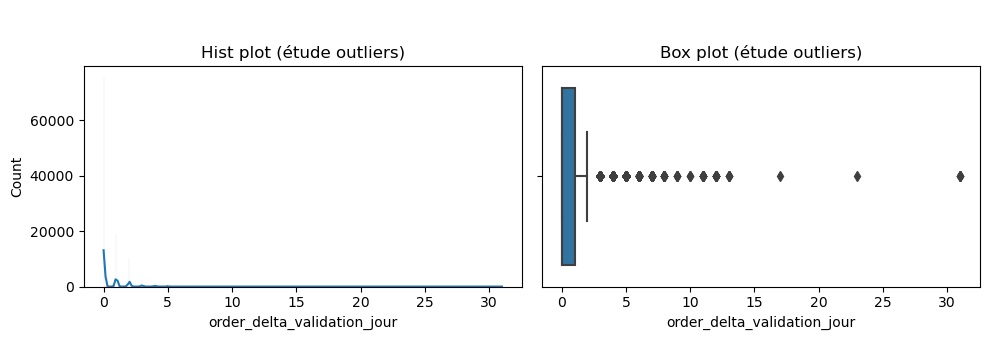








 ##############################         order_delta_livraison_transporteur_jour         ##############################
min				= 0.0 
max				= 107.0
Q1				= 1.0 
Q3				= 4.0 
IQR				= 3.0
upper_limit			= 8.5
lower_limit			= -3.5
Nb outliers > upper_limit	= 6274
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


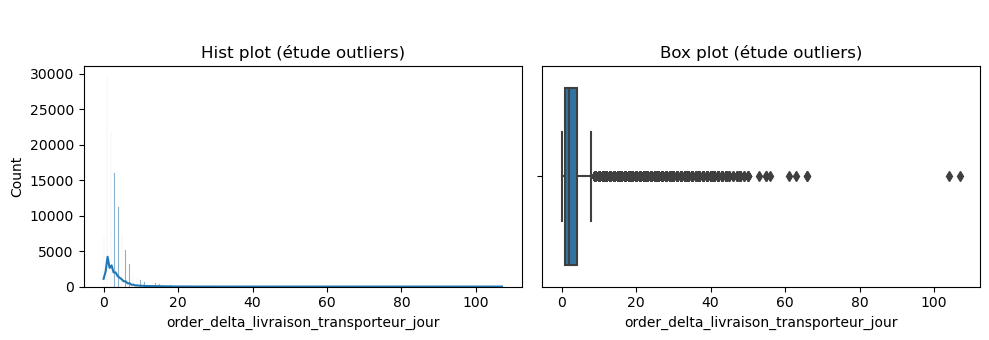








 ##############################         order_delta_livraison_client_jour         ##############################
min				= 0.0 
max				= 208.0
Q1				= 7.0 
Q3				= 15.0 
IQR				= 8.0
upper_limit			= 27.0
lower_limit			= -5.0
Nb outliers > upper_limit	= 6365
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


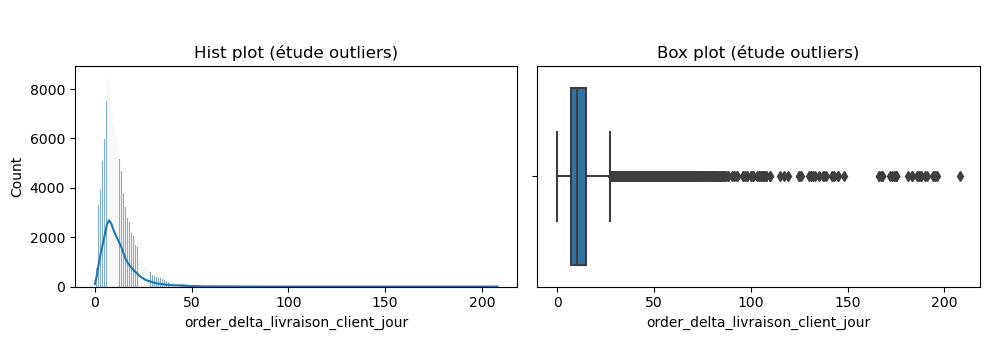








 ##############################         order_livraison_on_time         ##############################
min				= -188.0 
max				= 147.0
Q1				= 7.0 
Q3				= 17.0 
IQR				= 10.0
upper_limit			= 32.0
lower_limit			= -8.0
Nb outliers > upper_limit	= 2201
Nb outliers < lower_limit	= 2677


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


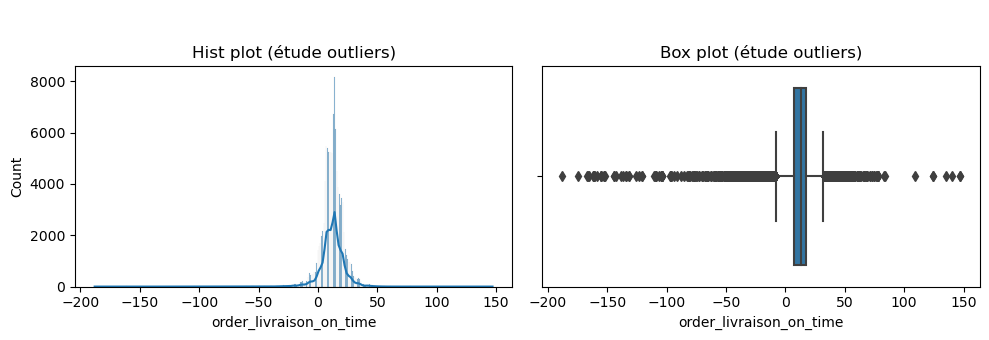








 ##############################         review_delta_client_jour         ##############################
min				= 2.0 
max				= 112.0
Q1				= 8.0 
Q3				= 17.0 
IQR				= 9.0
upper_limit			= 30.5
lower_limit			= -5.5
Nb outliers > upper_limit	= 2942
Nb outliers < lower_limit	= 0


C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = round(np.percentile(data_customers_orders[colonne_in], 25, interpolation = 'midpoint'), 2)
C:\Users\valdu\AppData\Local\Temp\ipykernel_9768\2504007996.py:19: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = round(np.percentile(data_customers_orders[colonne_in], 75, interpolation = 'midpoint'), 2)


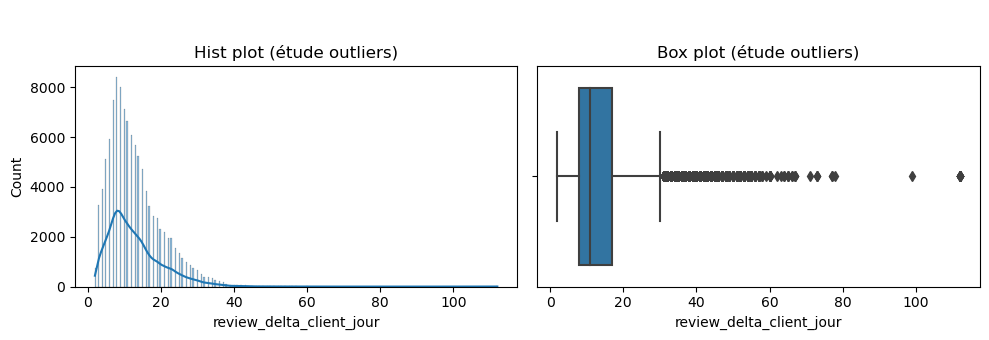

In [105]:
for col in ['order_delta_validation_jour', 'order_delta_livraison_transporteur_jour', 'order_delta_livraison_client_jour', 
            'order_livraison_on_time', 'review_delta_client_jour']:
    IQR(colonne_in = col, drop_in = False)
    IQR_plot(colonne_in = col, dataset_in = data_customers_orders)

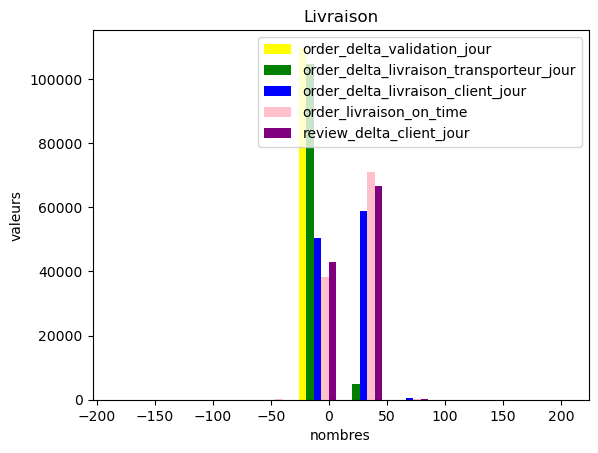

In [106]:
# Livraison
x1 = data_customers_orders['order_delta_validation_jour']
x2 = data_customers_orders['order_delta_livraison_transporteur_jour']
x3 = data_customers_orders['order_delta_livraison_client_jour']
x4 = data_customers_orders['order_livraison_on_time']
x5 = data_customers_orders['review_delta_client_jour']

plt.hist([x1, x2, x3, x4, x5], color = ['yellow', 'green', 'blue', 'pink', 'purple'],
         label = ['order_delta_validation_jour', 'order_delta_livraison_transporteur_jour', 
                  'order_delta_livraison_client_jour', 'order_livraison_on_time', 'review_delta_client_jour'],
         histtype = 'bar') # bar est le defaut

plt.ylabel('valeurs')
plt.xlabel('nombres')
plt.title('Livraison')
plt.legend()

# 4.4. RAYON PRODUIT

In [107]:
# Découpage selon catégories Amazon
def calcul_product_rayon():
    
    for index, row in data_customers_orders.iterrows():
        
        product_category_name = row['product_category_name_english']
    
    
        # Calcul rayon produit à partir de sa catégorie
        if ((product_category_name == 'books_technical') |
            (product_category_name == 'books_imported') |
            (product_category_name == 'books_general_interest')):
            rayon = 'livre'
    
        elif ((product_category_name == 'audio') |
              (product_category_name == 'music') |
              (product_category_name == 'cds_dvds_musicals') |
              (product_category_name == 'musical_instruments') |
              (product_category_name == 'dvds_blu_ray')):
            rayon = 'musique'
    
        elif (product_category_name == 'consoles_games'):
            rayon = 'console'
    
        elif ((product_category_name == 'computers_accessories') |
              (product_category_name == 'electronics') |
              (product_category_name == 'telephony') |
              (product_category_name == 'computers') |
              (product_category_name == 'tablets_printing_image') |
              (product_category_name == 'fixed_telephony') |
              (product_category_name == 'cine_photo') |
              (product_category_name == 'security_and_services') |
              (product_category_name == 'office_furniture') |
              (product_category_name == 'stationery') |          
              (product_category_name == 'home_comfort_2')):
            rayon = 'high_tech'
      
        elif ((product_category_name == 'toys') |
              (product_category_name == 'baby')):
            rayon = 'jouet'
        
        elif ((product_category_name == 'health_beauty') |
          (product_category_name == 'perfumery') |
          (product_category_name == 'diapers_and_hygiene')):
            rayon = 'soin_beaute'        
 
        elif ((product_category_name == 'watches_gifts') |
              (product_category_name == 'fashion_male_clothing') |
              (product_category_name == 'fashio_female_clothing') |
              (product_category_name == 'fashion_shoes') |
              (product_category_name == 'fashion_sport') |          
              (product_category_name == 'fashion_childrens_clothes') |
              (product_category_name == 'fashion_underwear_beach') |
              (product_category_name == 'fashion_bags_accessories')):
            rayon = 'habillement'

        elif ((product_category_name == 'food') |
              (product_category_name == 'food_drink') |
              (product_category_name == 'drinks')):
            rayon = 'alimentation'
 
        elif ((product_category_name == 'garden_tools') |
              (product_category_name == 'flowers') |
              (product_category_name == 'auto') |
              (product_category_name == 'signaling_and_security')):
            rayon = 'bricolage'
        
        elif ((product_category_name == 'home_appliances') |
              (product_category_name == 'art') |
              (product_category_name == 'furniture_bedroom') |
              (product_category_name == 'la_cuisine') |
              (product_category_name == 'home_confort') |
              (product_category_name == 'furniture_living_room') |
              (product_category_name == 'furniture_decor') |
              (product_category_name == 'kitchen_dining_laundry_garden_furniture') |
              (product_category_name == 'housewares') |
              (product_category_name == 'construction_tools_lights') |
              (product_category_name == 'cool_stuff') |
              (product_category_name == 'construction_tools_construction') |
              (product_category_name == 'home_construction') |
              (product_category_name == 'costruction_tools_garden') |
              (product_category_name == 'construction_tools_safety') |
              (product_category_name == 'costruction_tools_tools') |
              (product_category_name == 'arts_and_craftmanship') |
              (product_category_name == 'air_conditioning') |
              (product_category_name == 'christmas_supplies') |
              (product_category_name == 'bed_bath_table') |
              (product_category_name == 'party_supplies') |
              (product_category_name == 'home_appliances_2') |
              (product_category_name == 'small_appliances') |
              (product_category_name == 'small_appliances_home_oven_and_coffee') |
              (product_category_name == 'furniture_mattress_and_upholstery') |
              (product_category_name == 'luggage_accessories') |
              (product_category_name == 'sports_leisure')):
            rayon = 'maison'        
        
        elif ((product_category_name == 'market_place') |
              (product_category_name == 'industry_commerce_and_business') |
              (product_category_name == 'agro_industry_and_commerce') |
              (product_category_name == 'pet_shop')):
            rayon = 'plateforme'

        else:
            rayon = ''
        
        
        # Maj dataframe    
        data_customers_orders.loc[index, 'rayon'] = rayon
        
        # Trace de qq produits
        if ((index == 115545) | (index == 115557) | (index == 115563) | (index == 115463) | (index == 115455)):
            print('index =', index, ', product_category_name_english =', product_category_name, ', rayon =', rayon)

In [108]:
calcul_product_rayon()

index = 115455 , product_category_name_english = computers , rayon = high_tech
index = 115463 , product_category_name_english = audio , rayon = musique
index = 115545 , product_category_name_english = party_supplies , rayon = maison
index = 115557 , product_category_name_english = furniture_mattress_and_upholstery , rayon = maison
index = 115563 , product_category_name_english = diapers_and_hygiene , rayon = soin_beaute


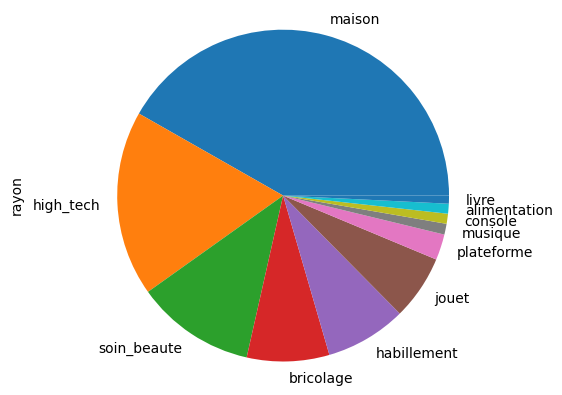

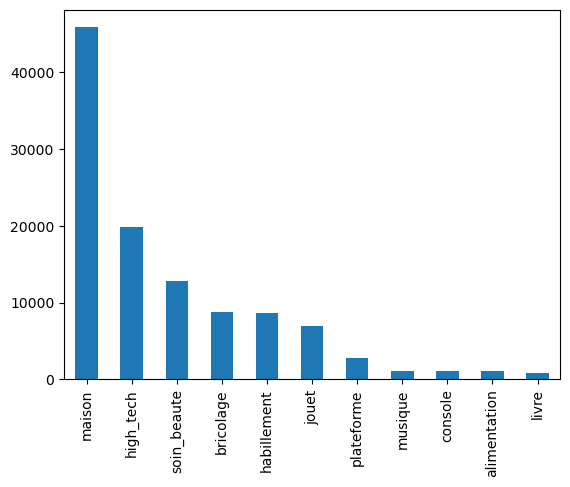

In [109]:
analyse_univariee_var_categorielle(var_in = 'rayon', reduire_in = False)

In [110]:
# Suppression colonne
data_customers_orders.drop(['product_category_name_english'], axis = 1, inplace = True)

# 4.5. DESCRIPTION PRODUIT

In [111]:
# 'product_photos_qty', 'product_name_lenght', 'product_description_lenght' : étude moyenne
def statistiques_description_produit():
        
    # Moyenne quantité de photos
    product_photos_qty_mean = data_customers_orders['product_photos_qty'].mean()
    print('product_photos_qty\t\t: mean =', product_photos_qty_mean, 
          ', min =',  data_customers_orders['product_photos_qty'].min())
    
    # Moyenne longueur nom produit
    product_name_lenght_mean = data_customers_orders['product_name_lenght'].mean()
    print('product_name_lenght\t\t: mean =', product_name_lenght_mean, 
          ', min =',  data_customers_orders['product_name_lenght'].min())
    
    # Moyenne longueur description produit
    product_description_lenght_mean = data_customers_orders['product_description_lenght'].mean()
    print('product_description_lenght\t: mean =', product_description_lenght_mean, 
          ', min =',  data_customers_orders['product_description_lenght'].min(), '\n')
          
        
    # Statistiques sur listes
    print('product_photos_qty =\n', 
          data_customers_orders['product_photos_qty'].describe(include = 'all'), '\n')
    
    print('product_name_lenght =\n', 
          data_customers_orders['product_name_lenght'].describe(include = 'all'), '\n')
    
    print('product_description_lenght_df =\n', 
          data_customers_orders['product_description_lenght'].describe(include = 'all'))    
    
    return product_photos_qty_mean, product_name_lenght_mean, product_description_lenght_mean

In [112]:
product_photos_qty_mean, product_name_lenght_mean, product_description_lenght_mean = statistiques_description_produit()

product_photos_qty		: mean = 2.199130807146697 , min = 1.0
product_name_lenght		: mean = 48.82063103036708 , min = 5.0
product_description_lenght	: mean = 783.7853348761355 , min = 4.0 

product_photos_qty =
 count    109757.000000
mean          2.199131
std           1.716255
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          20.000000
Name: product_photos_qty, dtype: float64 

product_name_lenght =
 count    109757.000000
mean         48.820631
std          10.018285
min           5.000000
25%          42.000000
50%          52.000000
75%          57.000000
max          76.000000
Name: product_name_lenght, dtype: float64 

product_description_lenght_df =
 count    109757.000000
mean        783.785335
std         649.504864
min           4.000000
25%         344.000000
50%         598.000000
75%         983.000000
max        3992.000000
Name: product_description_lenght, dtype: float64


In [113]:
# 'product_photos_qty_mean', 'product_name_lenght_mean', 'product_description_lenght_mean'

# | n° cas | product_   | product_    | product_description | is_description_    | Commentaire                        |
# |        | photos_qty | name_lenght | _lenght             | produit_importante |                                    |
# |--------|------------|-------------|---------------------|--------------------|------------------------------------|
# |   1    |  > mean    | < ou > mean |      > mean         | Oui                |                                    |
# |   2    |  > mean    | < ou > mean |      < mean         | Oui                | Bp photos, petite description      |
# |   3    |  < mean    | < ou > mean |      > mean         | Oui                | Peu de photos, grande description  |
# |   4    |  < mean    |      > mean |      < mean         | Oui                | Peu de détails, grand nom          |
# |   5    |  < mean    |      < mean |      < mean         | Non                |                                    |

def calcul_description_produit(product_photos_qty_mean_in, 
                               product_name_lenght_mean_in, 
                               product_description_lenght_mean_in):
    
    count =  0
    
    print('product_photos_qty_mean_in\t\t=', round(product_photos_qty_mean_in, 2), '\n',
          'product_name_lenght_mean_in\t\t=', round(product_name_lenght_mean_in, 2), '\n',
          'product_description_lenght_mean_in\t=', round(product_description_lenght_mean_in, 2), '\n')
    
    for index, row in data_customers_orders.iterrows():

        product_photos_qty         = row['product_photos_qty']
        product_name_lenght        = row['product_name_lenght']
        product_description_lenght = row['product_description_lenght']
        

        # Description produit importante ? Calcul quantité de photos, longueur titre et description % moyenne
        # >>>>>>> Cas 1 et 2
        if (product_photos_qty >= product_photos_qty_mean_in):
             is_description_produit_importante = True
        # >>>>>>> Cas 3
        elif ((product_photos_qty         <  product_photos_qty_mean_in) &
              (product_description_lenght >= product_description_lenght_mean_in)):
            is_description_produit_importante = True
        # >>>>>>> Cas 4
        elif ((product_photos_qty         <  product_photos_qty_mean_in) &
              (product_name_lenght        >= product_name_lenght_mean_in) &
              (product_description_lenght <  product_description_lenght_mean_in)):
            is_description_produit_importante = True
        # >>>>>>> Cas 5
        else:
             is_description_produit_importante = False
             

    
        # Maj dataframe
        data_customers_orders.loc[index, 'is_description_produit_importante'] = is_description_produit_importante
        
        
        if index in (73824, 73825, 73835, 115606, 115608):
            print ('index =', index, '\n',
                   '\t- product_photos_qty\t\t=', product_photos_qty, '\n',
                   '\t- product_name_lenght\t\t=', product_name_lenght, '\n',
                   '\t- product_description_lenght\t=', product_description_lenght, '\n', 
                   '--> is_description_produite_importante =',
                   data_customers_orders.loc[index, 'is_description_produit_importante'], '\n')
        
        count = count + 1 

In [114]:
calcul_description_produit(product_photos_qty_mean_in         = product_photos_qty_mean, 
                           product_name_lenght_mean_in        = product_name_lenght_mean, 
                           product_description_lenght_mean_in = product_description_lenght_mean)

product_photos_qty_mean_in		= 2.2 
 product_name_lenght_mean_in		= 48.82 
 product_description_lenght_mean_in	= 783.79 

index = 73824 
 	- product_photos_qty		= 1.0 
 	- product_name_lenght		= 33.0 
 	- product_description_lenght	= 726.0 
 --> is_description_produite_importante = False 

index = 73825 
 	- product_photos_qty		= 1.0 
 	- product_name_lenght		= 37.0 
 	- product_description_lenght	= 955.0 
 --> is_description_produite_importante = True 

index = 73835 
 	- product_photos_qty		= 1.0 
 	- product_name_lenght		= 30.0 
 	- product_description_lenght	= 548.0 
 --> is_description_produite_importante = False 

index = 115606 
 	- product_photos_qty		= 5.0 
 	- product_name_lenght		= 57.0 
 	- product_description_lenght	= 942.0 
 --> is_description_produite_importante = True 

index = 115608 
 	- product_photos_qty		= 3.0 
 	- product_name_lenght		= 29.0 
 	- product_description_lenght	= 654.0 
 --> is_description_produite_importante = True 



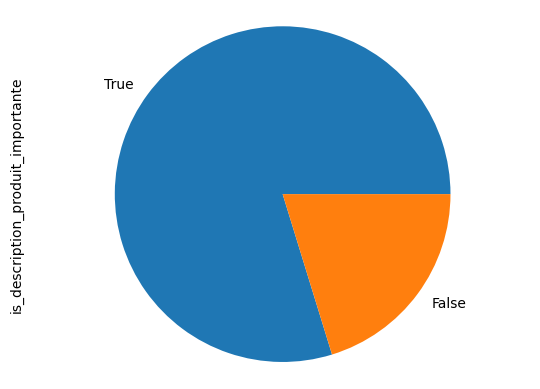

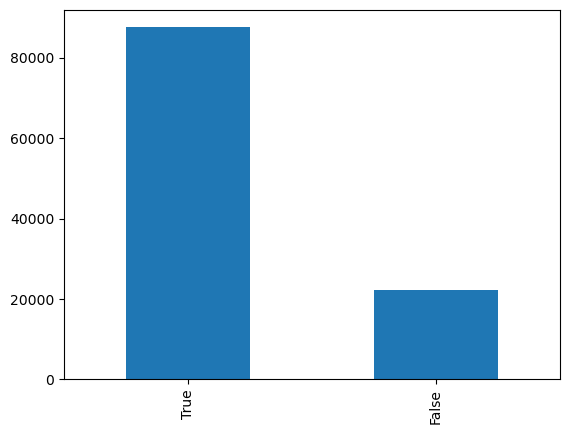

In [115]:
analyse_univariee_var_categorielle(var_in = 'is_description_produit_importante', reduire_in = False)

In [116]:
# Suppression colonnes 'product_photos_qty', 'product_name_lenght', 'product_description_lenght'
data_customers_orders.drop(['product_photos_qty', 'product_name_lenght', 'product_description_lenght'], 
                           axis = 1, inplace = True)

# 4.6. AVIS CLIENT

In [117]:
# 'review_comment_title', 'review_comment_message' : étude moyenne
def statistiques_commentaires_client():
    
    comment_title   = []
    comment_message = []
    
    for index, row in data_customers_orders.iterrows():
               
        # review_comment_title
        review_comment_title = row['review_comment_title']
        taille_review_comment_title = len(review_comment_title)  # la taille peut être nulle
        comment_title.append(taille_review_comment_title)
            
        # review_comment_message
        review_comment_message = row['review_comment_message']
        taille_review_comment_message = len(review_comment_message) # la taille peut être nulle
        comment_message.append(taille_review_comment_message)            

   
        
    # Moyenne taille titre commentaire
    comment_title_mean = statistics.mean(comment_title)
    print('comment_title\t: mean =', comment_title_mean, ', min =',  min(comment_title))
    
    # Moyenne taille message commentaire    
    comment_message_mean = statistics.mean(comment_message)
    print('comment_message\t: mean =', comment_message_mean, ', min =',  min(comment_message), '\n')
          
        
    # Statistiques sur listes
    comment_title_df = pd.DataFrame(comment_title)
    print('comment_title_df =\n', comment_title_df.describe(include = 'all'), '\n')
    
    comment_message_df = pd.DataFrame(comment_message)
    print('comment_message_df =\n', comment_message_df.describe(include = 'all'))
    
    return comment_title_mean, comment_message_mean

In [118]:
comment_title_mean, comment_message_mean = statistiques_commentaires_client()

comment_title	: mean = 1.4433430214018241 , min = 0
comment_message	: mean = 29.165802636733876 , min = 0 

comment_title_df =
                    0
count  109757.000000
mean        1.443343
std         4.495849
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        26.000000 

comment_message_df =
                    0
count  109757.000000
mean       29.165803
std        49.060736
min         0.000000
25%         0.000000
50%         0.000000
75%        43.000000
max       208.000000


In [119]:
# 'review_score', 'review_comment_title', 'review_comment_message',
# 'review_id', 'review_answer_timestamp'

def calcul_avis_client(comment_title_mean_in, comment_message_mean_in):
    comment_title   = []
    comment_message = []
    count           = 0
    
    for index, row in data_customers_orders.iterrows():
               
        #####################################################
        #                   review_score                    #
        #####################################################
        # 1, 2 : pas satisfait, 3 : moyennement, 4, 5 : très satisfait
        review_score = row['review_score']
        if ((review_score == 1) |
            (review_score == 2)):
            satisfaction_client = 'Non'
        elif (review_score == 3):
            satisfaction_client = 'Moyen'
        elif ((review_score == 4) |
              (review_score == 5)):
            satisfaction_client = 'Oui'

            
        
        #####################################################
        #               review_comment_title                #
        #####################################################
        review_comment_title = row['review_comment_title']
        taille_review_comment_title = len(review_comment_title)   # nombre de caractère du commentaire
        
        # Présence commentaire ?
        if (taille_review_comment_title == 0):
            is_review_comment_title = False   # absence commentaire
        else:
            is_review_comment_title = True    # présence commentaire
            
        # Commentaire important ? calcul taille commentaire % moyenne
        if (taille_review_comment_title <= comment_title_mean_in):
             is_review_comment_title_important = False
        else:
             is_review_comment_title_important = True
                


        #####################################################
        #             review_comment_message                #
        #####################################################
        review_comment_message = row['review_comment_message']
        taille_review_comment_message = len(review_comment_message)  # nombre de caractères du commentaire
        
        # Présence commentaire ?
        if (taille_review_comment_message == 0):
            is_review_comment_message = False   # absence commentaire
        else:
            is_review_comment_message = True    # présence commentaire
            
        # Commentaire important ? calcul taille commentaire % moyenne
        if (taille_review_comment_message <= comment_message_mean_in):
             is_review_comment_message_important = False
        else:
             is_review_comment_message_important = True
        
    
    
        # Maj dataframe    
        data_customers_orders.loc[index, 'satisfaction_client']                 = satisfaction_client
        data_customers_orders.loc[index, 'is_review_comment_title']             = is_review_comment_title
        data_customers_orders.loc[index, 'is_review_comment_title_important']   = is_review_comment_title_important
        data_customers_orders.loc[index, 'is_review_comment_message']           = is_review_comment_message
        data_customers_orders.loc[index, 'is_review_comment_message_important'] = is_review_comment_message_important
        
        if (count <= 7):
            print ('index =', index, '\n',
                   '\t- review_score =', review_score, '--> satisfaction_client =', 
                   data_customers_orders.loc[index, 'satisfaction_client'], '\n',
                   '\t- taille_review_comment_title =', taille_review_comment_title, '--> is_review_comment_title =',
                   data_customers_orders.loc[index, 'is_review_comment_title'], ', is_review_comment_title_important =',
                   data_customers_orders.loc[index, 'is_review_comment_title_important'], '\n',
                   '\t- taille_review_comment_message =', taille_review_comment_message, 
                   '--> is_review_comment_message =',
                   data_customers_orders.loc[index, 'is_review_comment_message'],
                   ', is_review_comment_message_important =',
                   data_customers_orders.loc[index, 'is_review_comment_message_important'], '\n')
        
        count = count + 1 

In [120]:
# comment_title   : mean =  1.44
# comment_message : mean = 29.16
calcul_avis_client(comment_title_mean_in   = comment_title_mean,
                   comment_message_mean_in = comment_message_mean) 

index = 0 
 	- review_score = 4 --> satisfaction_client = Oui 
 	- taille_review_comment_title = 0 --> is_review_comment_title = False , is_review_comment_title_important = False 
 	- taille_review_comment_message = 0 --> is_review_comment_message = False , is_review_comment_message_important = False 

index = 1 
 	- review_score = 1 --> satisfaction_client = Non 
 	- taille_review_comment_title = 0 --> is_review_comment_title = False , is_review_comment_title_important = False 
 	- taille_review_comment_message = 59 --> is_review_comment_message = True , is_review_comment_message_important = True 

index = 2 
 	- review_score = 1 --> satisfaction_client = Non 
 	- taille_review_comment_title = 0 --> is_review_comment_title = False , is_review_comment_title_important = False 
 	- taille_review_comment_message = 59 --> is_review_comment_message = True , is_review_comment_message_important = True 

index = 3 
 	- review_score = 3 --> satisfaction_client = Moyen 
 	- taille_review_comment

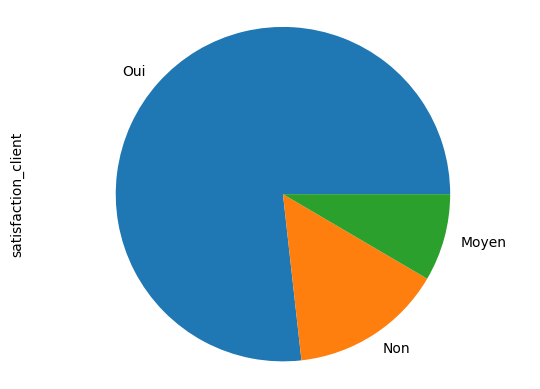

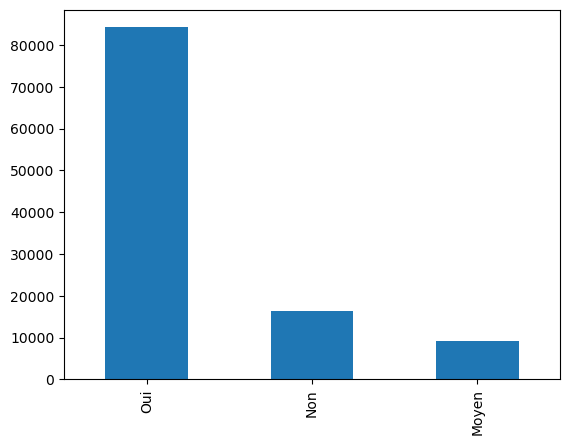

In [121]:
analyse_univariee_var_categorielle(var_in = 'satisfaction_client', reduire_in = False)

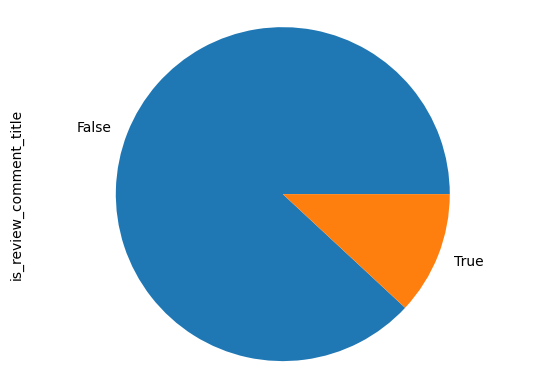

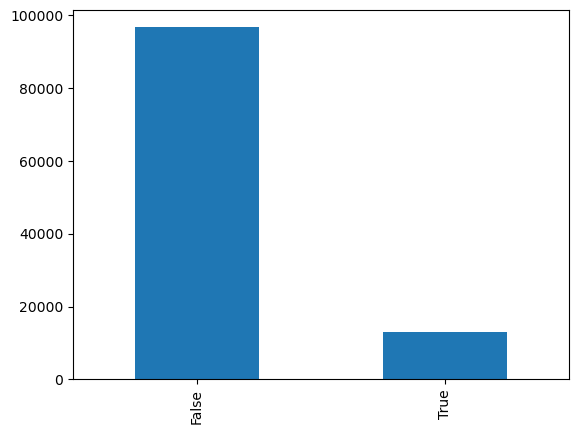

In [122]:
analyse_univariee_var_categorielle(var_in = 'is_review_comment_title', reduire_in = False)

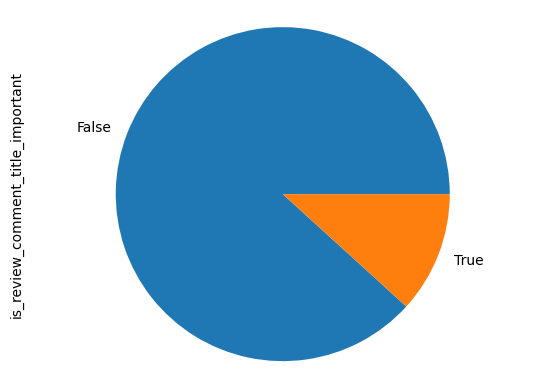

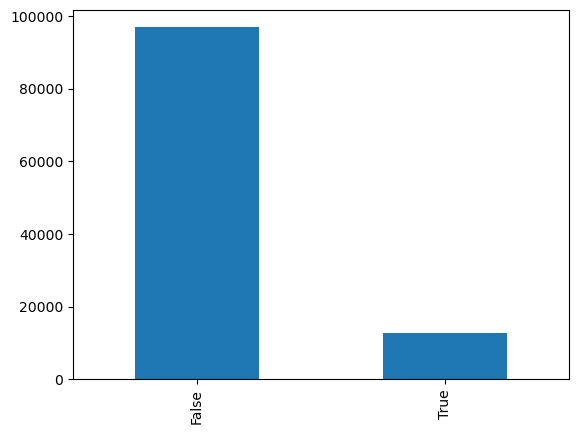

In [123]:
analyse_univariee_var_categorielle(var_in = 'is_review_comment_title_important', reduire_in = False)

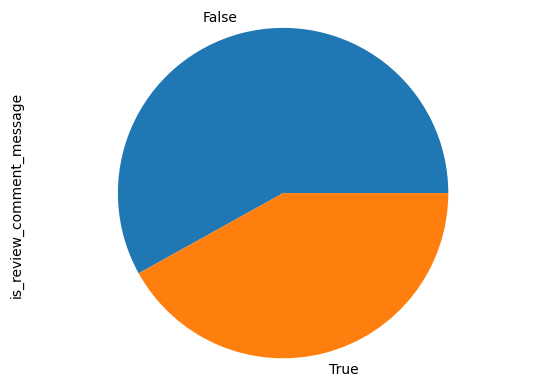

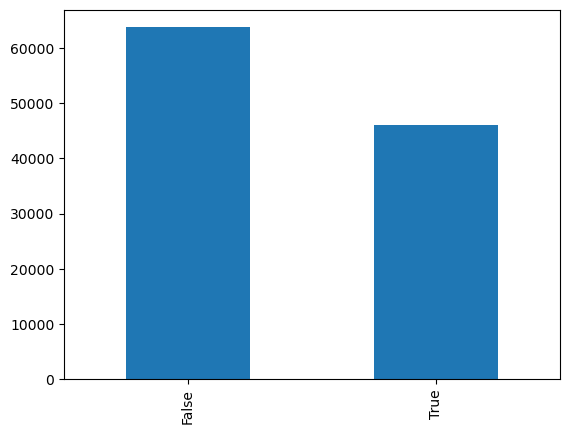

In [124]:
analyse_univariee_var_categorielle(var_in = 'is_review_comment_message', reduire_in = False)

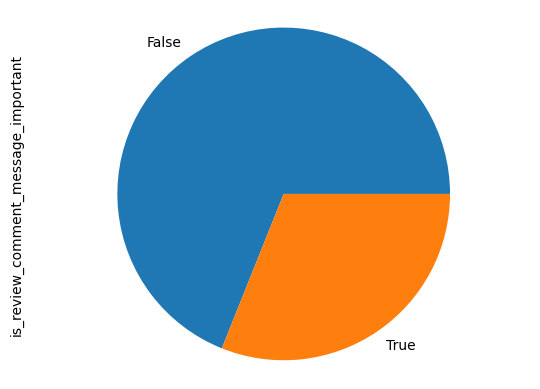

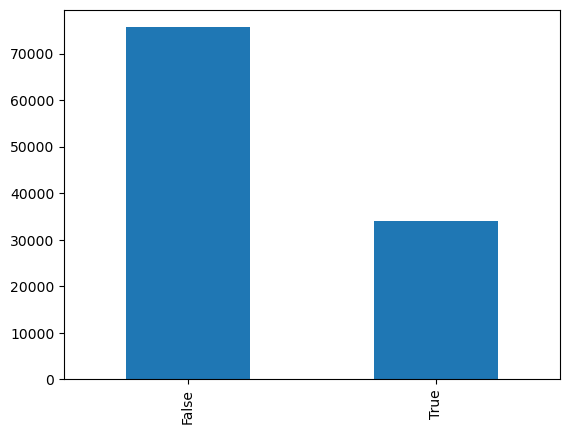

In [125]:
analyse_univariee_var_categorielle(var_in = 'is_review_comment_message_important', reduire_in = False)

In [126]:
# Suppression colonnes 'review_score', 'review_comment_title', 'review_comment_message'
data_customers_orders.drop(['review_score', 'review_comment_title', 'review_comment_message',
                            'review_id', 'review_answer_timestamp'], 
                           axis = 1, inplace = True)

# 5. CONVERSION EN TYPES NUMERIQUES

In [127]:
data_customers_orders.columns

Index(['customer_unique_id', 'order_purchase_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_weight_g', 'distance_client_vendeur_km', 'product_volume_dm3',
       'order_delta_validation_jour',
       'order_delta_livraison_transporteur_jour',
       'order_delta_livraison_client_jour', 'review_delta_client_jour',
       'order_livraison_on_time', 'rayon', 'is_description_produit_importante',
       'satisfaction_client', 'is_review_comment_title',
       'is_review_comment_title_important', 'is_review_comment_message',
       'is_review_comment_message_important'],
      dtype='object')

In [128]:
data_customers_orders.dtypes

customer_unique_id                          object
order_purchase_timestamp                    object
payment_sequential                           int64
payment_type                                object
payment_installments                         int64
payment_value                              float64
order_item_id                                int64
shipping_limit_date                         object
price                                      float64
freight_value                              float64
product_weight_g                           float64
distance_client_vendeur_km                 float64
product_volume_dm3                         float64
order_delta_validation_jour                float64
order_delta_livraison_transporteur_jour    float64
order_delta_livraison_client_jour          float64
review_delta_client_jour                   float64
order_livraison_on_time                    float64
rayon                                       object
is_description_produit_importan

# 5.1. BOOLEEN --> INTEGER

In [129]:
# Converting boolean to integer
def conversion_booleen_to_integer(df_in, col_in):
    print('col_in =', col_in)
        
    for index, row in df_in.iterrows():
        
        # valeur booléenne
        colonne_bool = row[col_in]
        
        # conversion en valeur numérique
        if (colonne_bool):
            df_in.loc[index, col_in] = 1
        else:
            df_in.loc[index, col_in] = 0
            
#       print('index =', index, ':', colonne_bool, '-->' , df_in.loc[index, col_in])

In [130]:
for col in ['is_review_comment_title', 'is_review_comment_title_important',
            'is_review_comment_message', 'is_review_comment_message_important', 
            'is_description_produit_importante']:
    print(col, ':', data_customers_orders[col].nunique(), 'valeurs,',
          data_customers_orders[col].unique())

is_review_comment_title : 2 valeurs, [False True]
is_review_comment_title_important : 2 valeurs, [False True]
is_review_comment_message : 2 valeurs, [False True]
is_review_comment_message_important : 2 valeurs, [False True]
is_description_produit_importante : 2 valeurs, [True False]


In [131]:
conversion_booleen_to_integer(df_in  = data_customers_orders, 
                              col_in = 'is_review_comment_title')

col_in = is_review_comment_title


In [132]:
conversion_booleen_to_integer(df_in  = data_customers_orders,
                              col_in = 'is_review_comment_title_important')

col_in = is_review_comment_title_important


In [133]:
conversion_booleen_to_integer(df_in  = data_customers_orders, 
                              col_in = 'is_review_comment_message')

col_in = is_review_comment_message


In [134]:
conversion_booleen_to_integer(df_in  = data_customers_orders,
                              col_in = 'is_review_comment_message_important')

col_in = is_review_comment_message_important


In [135]:
conversion_booleen_to_integer(df_in  = data_customers_orders,
                              col_in = 'is_description_produit_importante')

col_in = is_description_produit_importante


In [136]:
# On force le type de la colonne
data_customers_orders['is_review_comment_title'] = \
data_customers_orders['is_review_comment_title'].astype(int)

data_customers_orders['is_review_comment_title_important'] = \
data_customers_orders['is_review_comment_title_important'].astype(int)

data_customers_orders['is_review_comment_message'] = \
data_customers_orders['is_review_comment_message'].astype(int)

data_customers_orders['is_review_comment_message_important'] = \
data_customers_orders['is_review_comment_message_important'].astype(int)

data_customers_orders['is_description_produit_importante'] = \
data_customers_orders['is_description_produit_importante'].astype(int)

# 5.2. ENUMERE --> INTEGER

In [137]:
for col in ['rayon', 'satisfaction_client']:
    print(col, ':', data_customers_orders[col].nunique(), 'valeurs,',
          data_customers_orders[col].unique())                                

rayon : 11 valeurs, ['high_tech' 'maison' 'bricolage' 'jouet' 'soin_beaute' 'plateforme'
 'habillement' 'musique' 'alimentation' 'console' 'livre']
satisfaction_client : 3 valeurs, ['Oui' 'Non' 'Moyen']


In [138]:
# -------> rayon
LISTE_RAYON_TYPE = []

print('rayon :', data_customers_orders['rayon'].nunique(), 'éléments =', 
      data_customers_orders['rayon'].unique())

LISTE_RAYON_TYPE = data_customers_orders['rayon'].unique().tolist()

print('\n=> LISTE_RAYON_TYPE :', len(LISTE_RAYON_TYPE), 'éléments =', LISTE_RAYON_TYPE)

rayon : 11 éléments = ['high_tech' 'maison' 'bricolage' 'jouet' 'soin_beaute' 'plateforme'
 'habillement' 'musique' 'alimentation' 'console' 'livre']

=> LISTE_RAYON_TYPE : 11 éléments = ['high_tech', 'maison', 'bricolage', 'jouet', 'soin_beaute', 'plateforme', 'habillement', 'musique', 'alimentation', 'console', 'livre']


In [139]:
# -------> satisfaction_client
LISTE_SATISFACTION_CLIENT_TYPE = []

print('satisfaction_client :', data_customers_orders['satisfaction_client'].nunique(), 'éléments =', 
      data_customers_orders['satisfaction_client'].unique())

LISTE_SATISFACTION_CLIENT_TYPE = data_customers_orders['satisfaction_client'].unique().tolist()

print('\n=> LISTE_RAYON_TYPE :', len(LISTE_SATISFACTION_CLIENT_TYPE), 'éléments =', LISTE_SATISFACTION_CLIENT_TYPE)

satisfaction_client : 3 éléments = ['Oui' 'Non' 'Moyen']

=> LISTE_RAYON_TYPE : 3 éléments = ['Oui', 'Non', 'Moyen']


In [140]:
# Conversion des types string en indice de leur liste
def conversion_enum_to_integer():
    count = 0
    for index, row in data_customers_orders.iterrows():
    
        rayon_row               = row['rayon'] 
        satisfaction_client_row = row['satisfaction_client']
    
#        print('index =', index, '\n\trayon_row =', rayon_row, ', satisfaction_client_row =', satisfaction_client_row)
    
        # ---> rayon
        data_customers_orders.loc[index, 'rayon_index'] = LISTE_RAYON_TYPE.index(rayon_row)
    
        # ---> satisfaction_client
        data_customers_orders.loc[index, 'satisfaction_client_index'] = \
        LISTE_SATISFACTION_CLIENT_TYPE.index(satisfaction_client_row)
    
        if (count < 5): # affichage des 5 premières lignes
            print('index =', index, 
                  '\n\trayon_row =', rayon_row, '--> rayon_index =', 
                  data_customers_orders.loc[index, 'rayon_index'], '/', 
                  LISTE_RAYON_TYPE[int(data_customers_orders.loc[index, 'rayon_index'])], 
                  '\n\tsatisfaction_client_row =', satisfaction_client_row, '--> satisfaction_client_index =', 
                  data_customers_orders.loc[index, 'satisfaction_client_index'], '/', 
                  LISTE_SATISFACTION_CLIENT_TYPE[int(data_customers_orders.loc[index, 'satisfaction_client_index'])], '\n')
    
        count = count + 1

In [141]:
conversion_enum_to_integer()

index = 0 
	rayon_row = high_tech --> rayon_index = 0.0 / high_tech 
	satisfaction_client_row = Oui --> satisfaction_client_index = 0.0 / Oui 

index = 1 
	rayon_row = high_tech --> rayon_index = 0.0 / high_tech 
	satisfaction_client_row = Non --> satisfaction_client_index = 1.0 / Non 

index = 2 
	rayon_row = high_tech --> rayon_index = 0.0 / high_tech 
	satisfaction_client_row = Non --> satisfaction_client_index = 1.0 / Non 

index = 3 
	rayon_row = high_tech --> rayon_index = 0.0 / high_tech 
	satisfaction_client_row = Moyen --> satisfaction_client_index = 2.0 / Moyen 

index = 4 
	rayon_row = high_tech --> rayon_index = 0.0 / high_tech 
	satisfaction_client_row = Oui --> satisfaction_client_index = 0.0 / Oui 



In [142]:
# Suppression des colonnnes converties
data_customers_orders.drop(['rayon', 'satisfaction_client'], axis = 1, inplace = True)

In [143]:
data_customers_orders.dtypes

customer_unique_id                          object
order_purchase_timestamp                    object
payment_sequential                           int64
payment_type                                object
payment_installments                         int64
payment_value                              float64
order_item_id                                int64
shipping_limit_date                         object
price                                      float64
freight_value                              float64
product_weight_g                           float64
distance_client_vendeur_km                 float64
product_volume_dm3                         float64
order_delta_validation_jour                float64
order_delta_livraison_transporteur_jour    float64
order_delta_livraison_client_jour          float64
review_delta_client_jour                   float64
order_livraison_on_time                    float64
is_description_produit_importante            int32
is_review_comment_title        

# 6. DATAFRAME CLIENT CENTRE

# 6.1. CREATION DATAFRAME A PARTIR DU DATAFRAME DES COMMANDES

In [144]:
# Les données sont propres => nous créons un dataframe client centré
#####################################################
#              DATAFRAME CLIENT CENTRE              #
#####################################################
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
# https://fr.moonbooks.org/Articles/Comment-utiliser-Groupby-et-Aggregate-avec-pandas-en-python-/

# Création dataframe client vide
data_customers = pd.DataFrame()

In [145]:
#--------------------------------------------------#
#           Colonne customer_unique_id             #
#--------------------------------------------------#
# https://www.delftstack.com/fr/howto/python-pandas/numpy-arrays-to-pandas-dataframe/

data_array = data_customers_orders['customer_unique_id'].unique()
print('NumPy Data Array is :\n', data_array, '\n')

# Création colonne customer_unique_id (identifiant unique client)
data_customers = pd.DataFrame(data_array, columns = ['customer_unique_id'])
print('The DataFrame generated from the NumPy array is :\n', data_customers)

print('nunique data_customers_orders\t=', data_customers_orders['customer_unique_id'].nunique())
print('nunique data_customers\t\t=', data_customers['customer_unique_id'].nunique())

NumPy Data Array is :
 ['861eff4711a542e4b93843c6dd7febb0' '9eae34bbd3a474ec5d07949ca7de67c0'
 '3c799d181c34d51f6d44bbbc563024db' ... '8d80e477643ec569b24592ce3d9dfc4c'
 '8c3c961a52bb5a0ffbce1d4e6d25cd67' '428f4721a509be8c52de6ec2900ba918'] 

The DataFrame generated from the NumPy array is :
                      customer_unique_id
0      861eff4711a542e4b93843c6dd7febb0
1      9eae34bbd3a474ec5d07949ca7de67c0
2      3c799d181c34d51f6d44bbbc563024db
3      23397e992b09769faf5e66f9e171a241
4      567ab47ca4deb92d46dbf54dce07d0a7
...                                 ...
88766  d931428aff71cf37ebd00c5808ea9aba
88767  c5da6424f1f5decedef8672a1a0103e1
88768  8d80e477643ec569b24592ce3d9dfc4c
88769  8c3c961a52bb5a0ffbce1d4e6d25cd67
88770  428f4721a509be8c52de6ec2900ba918

[88771 rows x 1 columns]
nunique data_customers_orders	= 88771
nunique data_customers		= 88771


In [146]:
#--------------------------------------------------#
#                   Colonne nb_commandes           #
#--------------------------------------------------#
def nb_commandes():
    count = 0   # Compteur

    # Serie = Nombre de commandes / client
    # http://python-simple.com/python-pandas/creation-series.php
    print('Lecture dataframe data_customers_orders :')
    serie = data_customers_orders['customer_unique_id'].value_counts()
    print('serie =\n', serie, '\n')
    print('index =', serie.index, '\n')
    print('values =', serie.values, '\n')
    print('9a736b248f67d166d2fbb006bcb877c3 :', serie['9a736b248f67d166d2fbb006bcb877c3'])
    print('85963fd37bfd387aa6d915d8a1065486 :', serie['85963fd37bfd387aa6d915d8a1065486'], '\n')


    print('Maj dataframe data_customers, colonne nb_commandes :')
    # Maj dataframef data_customers
    for index, row in data_customers.iterrows():
    
        customer_unique_id = row['customer_unique_id']
        
        # Identifiant client unique numérique
        data_customers.loc[index, 'customer_id'] = int(index)
        
        # Nombre de commandes
        data_customers.loc[index, 'nb_commandes'] = serie[customer_unique_id]
    
        # Traces pour les 5 premières lignes uniquement (car volumineux)
        if (count < 5):
            print('\tindex =', index, ', customer_id =', data_customers.loc[index, 'customer_id'], 
                  ', customer_unique_id =', customer_unique_id, 
                  ', nb_commandes =', data_customers.loc[index, 'nb_commandes'])
        
        count = count + 1

In [147]:
# Nombre de commandes / client
nb_commandes()

Lecture dataframe data_customers_orders :
serie =
 9a736b248f67d166d2fbb006bcb877c3    75
6fbc7cdadbb522125f4b27ae9dee4060    38
f9ae226291893fda10af7965268fb7f6    35
569aa12b73b5f7edeaa6f2a01603e381    26
85963fd37bfd387aa6d915d8a1065486    24
                                    ..
bc1dd2d8cb545e344edf948bfd56d7b5     1
30e2a85d00aed95c60786a1a6df6a9e9     1
e2144ff7214c1f09fbfbd8c6c65915dd     1
207b943d8a627cf754d5a62210f20d00     1
428f4721a509be8c52de6ec2900ba918     1
Name: customer_unique_id, Length: 88771, dtype: int64 

index = Index(['9a736b248f67d166d2fbb006bcb877c3', '6fbc7cdadbb522125f4b27ae9dee4060',
       'f9ae226291893fda10af7965268fb7f6', '569aa12b73b5f7edeaa6f2a01603e381',
       '85963fd37bfd387aa6d915d8a1065486', '5419a7c9b86a43d8140e2939cd2c2f7e',
       'db1af3fd6b23ac3873ef02619d548f9c', 'c8460e4251689ba205045f3ea17884a1',
       '1d2435aa3b858d45c707c9fc25e18779', '90807fdb59eec2152bc977feeb6e47e7',
       ...
       'd99a23e9d1b34f7526010669355fca50', 'f20558

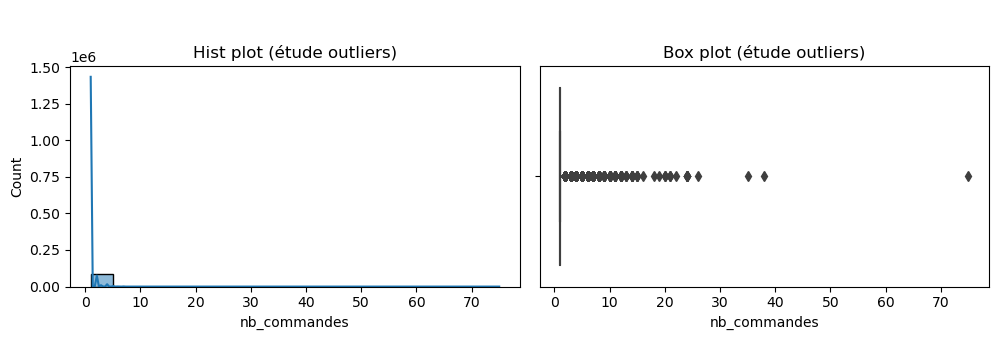

In [148]:
# Schéma nombre de commandes
IQR_plot(colonne_in = 'nb_commandes', dataset_in = data_customers)

In [149]:
data_customers[data_customers['nb_commandes'] < 30]

,customer_unique_id,customer_id,nb_commandes
0,861eff4711a542e4b93843c6dd7febb0,0.0,1.0
1,9eae34bbd3a474ec5d07949ca7de67c0,1.0,2.0
2,3c799d181c34d51f6d44bbbc563024db,2.0,1.0
3,23397e992b09769faf5e66f9e171a241,3.0,1.0
4,567ab47ca4deb92d46dbf54dce07d0a7,4.0,1.0
...,...,...,...
88766,d931428aff71cf37ebd00c5808ea9aba,88766.0,1.0
88767,c5da6424f1f5decedef8672a1a0103e1,88767.0,1.0
88768,8d80e477643ec569b24592ce3d9dfc4c,88768.0,2.0
88769,8c3c961a52bb5a0ffbce1d4e6d25cd67,88769.0,1.0


In [150]:
# Statistiques sur un dataframe réduit
def IQR_plot_reduit(colonne_in, dataset_reduit_in, text_in):
    
    fig = plt.figure(figsize = (10, 3.5))
    
    # Données après nettoyage
    plt.subplot(1,2,1)
    plt.title('\n\nHist plot ('+ text_in + ')')
    sns.histplot(x = dataset_reduit_in[colonne_in], kde = True)

   
    plt.subplot(1,2,2)
    plt.title('\n\nBox plot ('+ text_in + ')')
    sns.boxplot(x = dataset_reduit_in[colonne_in])

    fig.tight_layout()  # Espace entre les subplots
    plt.show()
    
    print('\n' * 5)

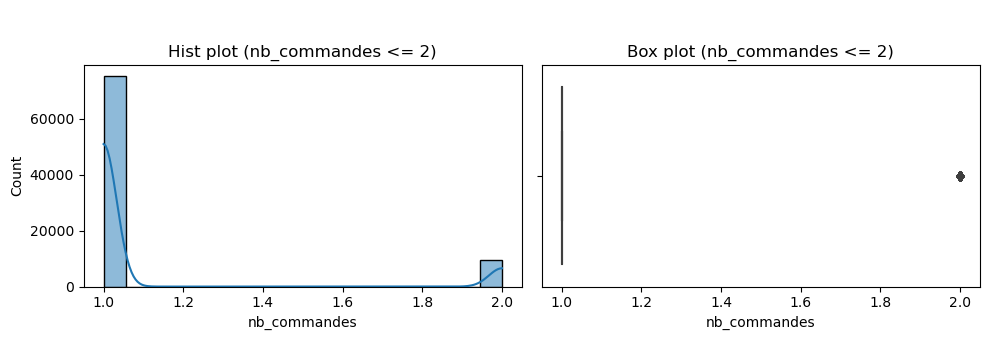

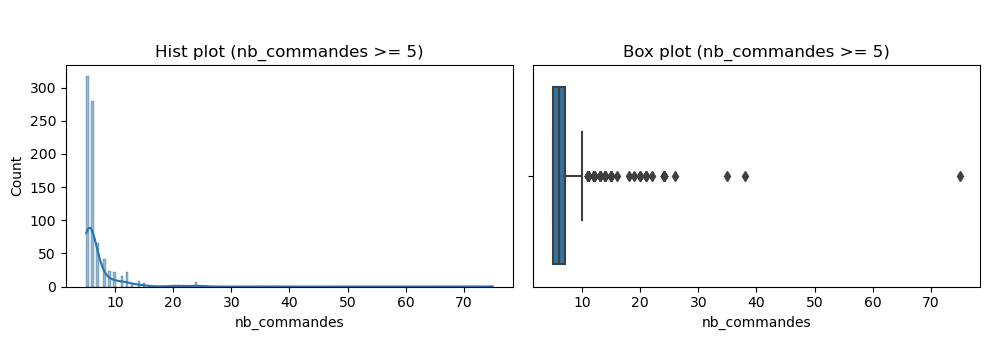

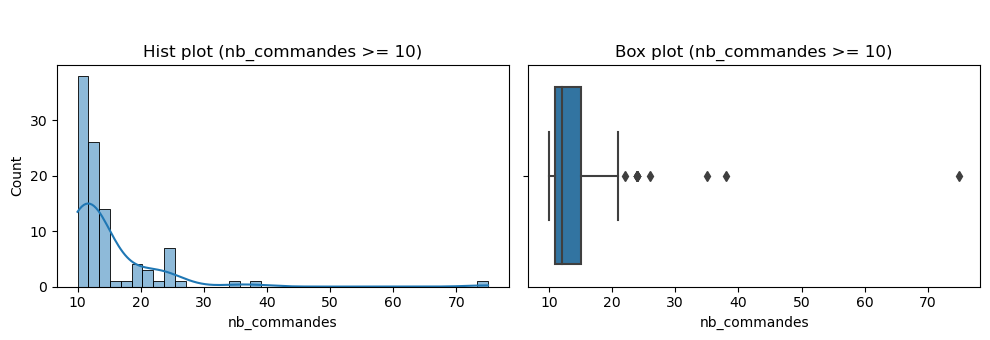

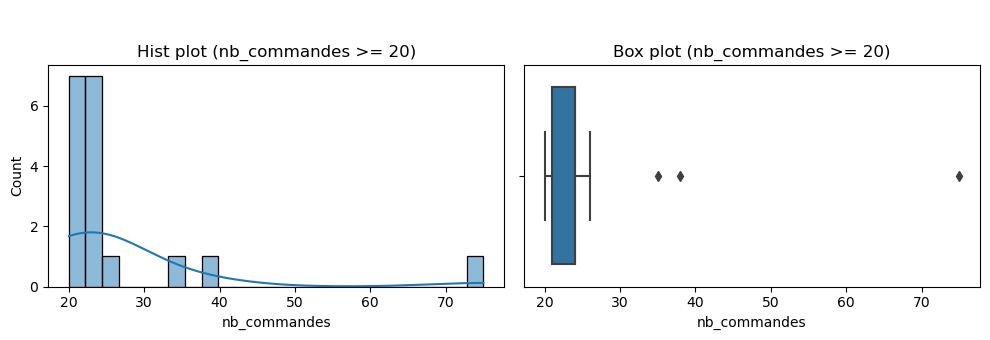

In [151]:
# nb_commandes <= 2
IQR_plot_reduit(colonne_in        = 'nb_commandes', 
                dataset_reduit_in = data_customers[data_customers['nb_commandes'] <= 2], 
                text_in           = 'nb_commandes <= 2')

# nb_commandes >= 5
IQR_plot_reduit(colonne_in        = 'nb_commandes', 
                dataset_reduit_in = data_customers[data_customers['nb_commandes'] >= 5], 
                text_in           = 'nb_commandes >= 5')

# nb_commandes >= 10
IQR_plot_reduit(colonne_in        = 'nb_commandes', 
                dataset_reduit_in = data_customers[data_customers['nb_commandes'] >= 10], 
                text_in           = 'nb_commandes >= 10')

# nb_commandes >= 20
IQR_plot_reduit(colonne_in        = 'nb_commandes', 
                dataset_reduit_in = data_customers[data_customers['nb_commandes'] >= 20], 
                text_in           = 'nb_commandes >= 20')

In [152]:
data_customers_orders.columns

Index(['customer_unique_id', 'order_purchase_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_weight_g', 'distance_client_vendeur_km', 'product_volume_dm3',
       'order_delta_validation_jour',
       'order_delta_livraison_transporteur_jour',
       'order_delta_livraison_client_jour', 'review_delta_client_jour',
       'order_livraison_on_time', 'is_description_produit_importante',
       'is_review_comment_title', 'is_review_comment_title_important',
       'is_review_comment_message', 'is_review_comment_message_important',
       'rayon_index', 'satisfaction_client_index'],
      dtype='object')

In [153]:
#------------------------------------------------------------------------#
# Ajout customer_id dans data_customers_orders à partir de celui calculé #
# dans le df data_customers (clé commune = customer_unique_id)           #
#------------------------------------------------------------------------#
count = 0 # compteur

for index, row in data_customers_orders.iterrows():
    
    customer_unique_id = row['customer_unique_id']
        
    # Dataframe avec données pour un client (celui dont l'id est customer_unique_id).
    df_customer_unique_id = data_customers[data_customers['customer_unique_id'] == customer_unique_id]        

    # Identifiant client unique numérique
    data_customers_orders.loc[index, 'customer_id'] = int(df_customer_unique_id['customer_id'])

    # Traces pour les 5 premières lignes uniquement (car volumineux)
    if (count < 5):
        print('index = ', index, ', customer_unique_id =', customer_unique_id, 
              ', customer_unique_id =', data_customers_orders.loc[index, 'customer_id'])
        
        data_customers_orders.loc[index, 'customer_id'] 
    count = count + 1

index =  0 , customer_unique_id = 861eff4711a542e4b93843c6dd7febb0 , customer_unique_id = 0.0
index =  1 , customer_unique_id = 9eae34bbd3a474ec5d07949ca7de67c0 , customer_unique_id = 1.0
index =  2 , customer_unique_id = 9eae34bbd3a474ec5d07949ca7de67c0 , customer_unique_id = 1.0
index =  3 , customer_unique_id = 3c799d181c34d51f6d44bbbc563024db , customer_unique_id = 2.0
index =  4 , customer_unique_id = 23397e992b09769faf5e66f9e171a241 , customer_unique_id = 3.0


In [154]:
# type cutomer_id forcé en entier
data_customers_orders['customer_id'] = data_customers_orders['customer_id'].astype(int)

In [155]:
# https://stackoverflow.com/questions/21378977/how-to-compare-two-timestamps-in-python
def achat_le_plus_recent(df_in, is_trace_in):
    
    latest = pd.Timestamp('1900-01-01 00:00:00') # Initialisation à une date très ancienne <=> minimum
    count = 0
    
    for index, row in df_in.iterrows():
        date_achat = pd.Timestamp(row['order_purchase_timestamp'])
    
        latest = max(latest, date_achat)
        if (is_trace_in & (count < 5)):  # affichage uniquement des 7 premières lignes
            print(date_achat, ',', 'latest =', latest)
            
        count = count + 1

    if (is_trace_in):
        print('\n==> achat le + récent du dataframe =', latest)
        
    return index, latest

In [156]:
# Achat le plus récent de toutes les commandes (dataframe data_customers_orders)
index_data_customers_orders, latest_order_dataframe = achat_le_plus_recent(df_in       = data_customers_orders, 
                                                                           is_trace_in = True)

# achat le + récent du dataframe = 2018-08-29 15:00:37

2017-05-16 15:05:35 , latest = 2017-05-16 15:05:35
2017-11-09 00:50:13 , latest = 2017-11-09 00:50:13
2017-11-09 00:50:13 , latest = 2017-11-09 00:50:13
2017-05-07 20:11:26 , latest = 2017-11-09 00:50:13
2018-02-03 19:45:40 , latest = 2018-02-03 19:45:40

==> achat le + récent du dataframe = 2018-08-29 15:00:37


In [157]:
#-----------------------------------------------------------------------------------#
# Statistiques client, découpées en plusieurs thèmes / verticale :                  #                                                #
#  - Segmentation / méthode RFM :                                                   #
#      > R : Récence -----> Delta temps dernier achat client % achat dernier client #
#      > F : Fréquence ---> Nombre d'articles commandés                             #
#      > M : Montant -----> Montant commande                                        #
#   - Paiement                                                                      #
#   - Délais de livraison                                                           #
#   - Distance vendeur                                                              #
#   - Satisfaction et commentaires client                                           #
#   - Produit : volume, poids, rayon, description                                   #
#-----------------------------------------------------------------------------------#

def statistiques_client():
    count = 0  # Compteur

    # Maj dataframef data_customers
    for index, row in data_customers.iterrows():
    
        customer_unique_id = row['customer_unique_id']
        
        # Dataframe avec données pour un client (celui dont l'id est customer_unique_id).
        df_customer_unique_id = data_customers_orders[data_customers_orders['customer_unique_id'] == customer_unique_id]
        
        # Achat le plus récent du client (df_customer_unique_id)
        index_df_customer_unique_id, latest_customer_order = achat_le_plus_recent(df_in       = df_customer_unique_id,
                                                                                  is_trace_in = False)
        
        # Serie avec données du dernier achat du client
        dernier_achat = df_customer_unique_id.loc[index_df_customer_unique_id]
        
        
        
        #########################################################################
        # Segmentation / méthode RFM :                                          #
        #    > R : Récence (date de la dernière commande).                      #
        #    > F : Fréquence des commandes.                                     #
        #    > M : Montant (de la dernière commande ou sur une période donnée). #
        #########################################################################
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # @                   Recence                    @
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # Delta temps entre dernier achat du client et achat du dernier client
        delta_achat_recent = latest_order_dataframe.date() - latest_customer_order.date()
        data_customers.loc[index, 'dernier_achat_recence'] = delta_achat_recent.days  # delta grand <=> achat ancien
        
        
  
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # @                   Frequence                  @
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # Articles commandés : somme (order_item_id = numéro séquentiel identifiant le nombre d’articles 
        # inclus dans la même commande).
        data_customers.loc[index, 'nb_articles_sum']           = df_customer_unique_id['order_item_id'].sum()
        data_customers.loc[index, 'nb_articles_mean']          = df_customer_unique_id['order_item_id'].mean()
        data_customers.loc[index, 'dernier_achat_nb_articles'] = dernier_achat['order_item_id'] # dernier achat
                
            
            
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # @                   Montant                    @
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # Montant commande : moyenne et somme
        # (remarque : paiement_value est la valeur transactionnelle totale qui être sur plusieurs lignes)
        data_customers.loc[index, 'montant_sum']           = (df_customer_unique_id['price'] +
                                                              df_customer_unique_id['freight_value']).sum()
        data_customers.loc[index, 'montant_mean']          = (df_customer_unique_id['price'] +
                                                              df_customer_unique_id['freight_value']).mean()        
        data_customers.loc[index, 'dernier_achat_montant'] = dernier_achat['payment_value'] # dernier achat
        
        
        
        #########################################################################
        #                      Autres variables                                 #
        #########################################################################
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # @                  Paiement                    @
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # Différence carte de débit / crédit : 
        # https://www.creditmutuel.fr/cmne/fr/le-mag/differences-carte-credit-debit.html
        # On liste avec un booléen les types de paiements adoptés par le client
        payment_type = df_customer_unique_id['payment_type'].unique()
        
        # >>>>>>> Boleto
        # Boleto : https://www.adyen.com/fr_FR/moyens-de-paiement/boleto
        # Boleto Bancário, communément appelé Boleto, est un moyen de paiement en espèces très prisé au Brésil, 
        # avec 15 % de part de marché. Il s'agit également du seul moyen de paiement dont disposent les 17 % de
        # clients brésiliens qui ne possèdent pas de compte bancaire.
        if ('boleto' in payment_type):
            data_customers.loc[index, 'is_payment_type_boleto'] = True
        else:
            data_customers.loc[index, 'is_payment_type_boleto'] = False
            
        # >>>>>>> Voucher : un voucher est un coupon prépayé (payé d'avance) pour l'achat d'un article.
        if ('voucher' in payment_type):
            data_customers.loc[index, 'is_payment_type_voucher'] = True
        else:
            data_customers.loc[index, 'is_payment_type_voucher'] = False
        
        # >>>>>>> Credit card
        if ('credit_card' in payment_type):
            data_customers.loc[index, 'is_payment_type_credit_card'] = True
        else:
            data_customers.loc[index, 'is_payment_type_credit_card'] = False
            
        # >>>>>>> Debit card            
        if ('debit_card' in payment_type):
            data_customers.loc[index, 'is_payment_type_debit_card'] = True
        else:
            data_customers.loc[index, 'is_payment_type_debit_card'] = False

        # https://fr.moonbooks.org/Articles/Comment-extraire-les-noms-et-valeurs-de-valuecounts-avec-pandas-en-python-/
        for idx, name in enumerate(df_customer_unique_id['payment_type'].value_counts().index.tolist()):
            data_customers.loc[index, 'payment_type_boleto_sum']      = 0 # initialisation
            data_customers.loc[index, 'payment_type_voucher_sum']     = 0 # initialisation
            data_customers.loc[index, 'payment_type_credit_card_sum'] = 0 # initialisation
            data_customers.loc[index, 'payment_type_debit_card_sum']  = 0 # initialisation
            
            if (name == 'boleto'):
                data_customers.loc[index, 'payment_type_boleto_sum'] = \
                df_customer_unique_id['payment_type'].value_counts()[idx]
            elif (name == 'voucher'):
                data_customers.loc[index, 'payment_type_voucher_sum'] = \
                df_customer_unique_id['payment_type'].value_counts()[idx]                
            elif (name == 'credit_card'):
                data_customers.loc[index, 'payment_type_credit_card_sum'] = \
                df_customer_unique_id['payment_type'].value_counts()[idx]                
            elif (name == 'debit_card'):
                data_customers.loc[index, 'payment_type_debit_card_sum'] = \
                df_customer_unique_id['payment_type'].value_counts()[idx]                
            

        # payement_sequential = un client peut payer une commande avec plus d’un mode de paiement. 
        # S’il le fait, une séquence sera créée pour accueillir tous.
        if (1 not in df_customer_unique_id['payment_sequential'].unique()):
            data_customers.loc[index, 'is_mode_de_paiement_multiple'] = True
        else:
            data_customers.loc[index, 'is_mode_de_paiement_multiple'] = False        
        
        # payment_installments = nombre de versements choisis par le client
        if (1 not in df_customer_unique_id['payment_installments']):
            data_customers.loc[index, 'is_versement_unique'] = False
        else:
            data_customers.loc[index, 'is_versement_unique'] = True           

        # dernier achat
        # >>>>>>> payment_type
        data_customers.loc[index, 'dernier_achat_is_payment_type_boleto']      = False # initialisation
        data_customers.loc[index, 'dernier_achat_is_payment_type_voucher']     = False # initialisation
        data_customers.loc[index, 'dernier_achat_is_payment_type_credit_card'] = False # initialisation
        data_customers.loc[index, 'dernier_achat_is_payment_type_debit_card']  = False # initialisation
        if (dernier_achat['payment_type'] == 'boleto'):
            data_customers.loc[index, 'dernier_achat_is_payment_type_boleto'] = True
        elif (dernier_achat['payment_type'] == 'voucher'):
            data_customers.loc[index, 'dernier_achat_is_payment_type_voucher'] = True
        elif (dernier_achat['payment_type'] == 'credit_card'): 
            data_customers.loc[index, 'dernier_achat_is_payment_type_credit_card'] = True
        elif (dernier_achat['payment_type'] == 'debit_card'):
            data_customers.loc[index, 'dernier_achat_is_payment_type_debit_card'] = True

        # >>>>>>> payement_sequential
        if (1 not in df_customer_unique_id['payment_sequential'].unique()):
            data_customers.loc[index, 'dernier_achat_is_mode_de_paiement_multiple'] = True # dernier achat
        else:
            data_customers.loc[index, 'dernier_achat_is_mode_de_paiement_multiple'] = False # dernier achat
           
            
        # >>>>>>> payment_installments
        if (1 not in df_customer_unique_id['payment_installments']):
            data_customers.loc[index, 'dernier_achat_is_versement_unique'] = False
        else:
            data_customers.loc[index, 'dernier_achat_is_versement_unique'] = True                


 
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # @           Délais de livraison                @
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        data_customers.loc[index, 'order_delta_validation_jour_mean'] = \
        df_customer_unique_id['order_delta_validation_jour'].mean()
        data_customers.loc[index, 'order_delta_validation_jour_sum'] = \
        df_customer_unique_id['order_delta_validation_jour'].sum()
        
        data_customers.loc[index, 'order_delta_livraison_transporteur_jour_mean'] = \
        df_customer_unique_id['order_delta_livraison_transporteur_jour'].mean()
        data_customers.loc[index, 'order_delta_livraison_transporteur_jour_sum'] = \
        df_customer_unique_id['order_delta_livraison_transporteur_jour'].sum()
        
        data_customers.loc[index, 'order_delta_livraison_client_jour_mean'] = \
        df_customer_unique_id['order_delta_livraison_client_jour'].mean()
        data_customers.loc[index, 'order_delta_livraison_client_jour_sum'] = \
        df_customer_unique_id['order_delta_livraison_client_jour'].sum()
        
        # Retard / avance de la livraison : > 0 --> gain de x jours, < 0 --> retard de x jours
        data_customers.loc[index, 'order_livraison_on_time_mean'] = \
        df_customer_unique_id['order_livraison_on_time'].mean()
        data_customers.loc[index, 'order_livraison_on_time_sum'] = \
        df_customer_unique_id['order_livraison_on_time'].sum()        
        if (df_customer_unique_id['order_livraison_on_time'].sum() >= 0):
            data_customers['is_order_livraison_on_time'] = True   # livraisons en avance
        else:
            data_customers['is_order_livraison_on_time'] = False  # Livraisons en retard
        
        
        # dernier achat
        data_customers.loc[index, 'dernier_achat_order_delta_validation_jour_mean'] = \
        dernier_achat['order_delta_validation_jour'].mean()
        data_customers.loc[index, 'dernier_achat_order_delta_validation_jour_sum'] = \
        dernier_achat['order_delta_validation_jour'].sum()

        data_customers.loc[index, 'dernier_achat_order_delta_livraison_transporteur_jour_mean'] = \
        dernier_achat['order_delta_livraison_transporteur_jour'].mean()
        data_customers.loc[index, 'dernier_achat_order_delta_livraison_transporteur_jour_sum'] = \
        dernier_achat['order_delta_livraison_transporteur_jour'].sum()
        
        data_customers.loc[index, 'dernier_achat_order_delta_livraison_client_jour_mean'] = \
        dernier_achat['order_delta_livraison_client_jour'].mean()
        data_customers.loc[index, 'dernier_achat_order_delta_livraison_client_jour_sum'] = \
        dernier_achat['order_delta_livraison_client_jour'].sum()
     
        # Retard / avance de la livraison : > 0 --> gain de x jours, < 0 --> retard de x jours
        data_customers.loc[index, 'dernier_achat_order_livraison_on_time_mean'] = \
        df_customer_unique_id['order_livraison_on_time'].mean()
        data_customers.loc[index, 'dernier_achat_order_livraison_on_time_sum'] = \
        df_customer_unique_id['order_livraison_on_time'].sum()        
        if (df_customer_unique_id['order_livraison_on_time'].sum() >= 0):
            data_customers['is_dernier_achat_order_livraison_on_time'] = True   # livraisons en avance
        else:
            data_customers['is_dernier_achat_order_livraison_on_time'] = False  # Livraisons en retard    



        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # @               Distance vendeur               @
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        data_customers.loc[index, 'distance_client_vendeur_km_mean'] = \
        df_customer_unique_id['distance_client_vendeur_km'].mean()
        data_customers.loc[index, 'distance_client_vendeur_km_sum']  = \
        df_customer_unique_id['distance_client_vendeur_km'].sum()
        
        # dernier achat
        data_customers.loc[index, 'dernier_achat_distance_client_vendeur_km_mean'] = \
        dernier_achat['distance_client_vendeur_km'].mean()
        data_customers.loc[index, 'dernier_achat_distance_client_vendeur_km_sum']  = \
        dernier_achat['distance_client_vendeur_km'].sum()
        


        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # @     Satisfaction et commentaires client      @
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # Client pas satisfait : 1, 2 (pas satisfait), 3 (moyennement) 
        # Client satisfait : 4, 5 (très satisfait)
        satisfaction_client_mean = df_customer_unique_id['satisfaction_client_index'].mean()
        if ((satisfaction_client_mean == 4) | (satisfaction_client_mean == 5)):
            data_customers.loc[index, 'is_satisfaction_client'] = True
        else:
            data_customers.loc[index, 'is_satisfaction_client'] = False
        
        data_customers.loc[index, 'review_delta_client_jour_mean'] = \
        df_customer_unique_id['review_delta_client_jour'].mean()
        
        # Traduction dans des booléens si le client s'est exprimé au moins une fois et de manière importante
        # (taille du message).
        if (df_customer_unique_id['is_review_comment_title'].sum() >= 1):
            data_customers.loc[index, 'is_review_comment_title'] = True
        else:
            data_customers.loc[index, 'is_review_comment_title'] = False
        
        if (df_customer_unique_id['is_review_comment_title_important'].sum() >= 1):
            data_customers.loc[index, 'is_review_comment_title_important'] = True
        else:
            data_customers.loc[index, 'is_review_comment_title_important'] = False
            
        if (df_customer_unique_id['is_review_comment_message'].sum() >= 1):
            data_customers.loc[index, 'is_review_comment_message'] = True
        else:
            data_customers.loc[index, 'is_review_comment_message'] = False
        
        if (df_customer_unique_id['is_review_comment_message_important'].sum() >= 1):
            data_customers.loc[index, 'is_review_comment_message_important'] = True
        else:
            data_customers.loc[index, 'is_review_comment_message_important'] = False
    
    
        # dernier achat
        if ((dernier_achat['satisfaction_client_index'] == 4) | (dernier_achat['satisfaction_client_index'] == 5)):
            data_customers.loc[index, 'dernier_achat_is_satisfaction_client'] = True
        else:
            data_customers.loc[index, 'dernier_achat_is_satisfaction_client'] = False
                
        data_customers.loc[index, 'dernier_achat_review_delta_client_jour'] = dernier_achat['review_delta_client_jour']
        data_customers.loc[index, 'dernier_achat_is_review_comment_title']  = dernier_achat['is_review_comment_title']
        data_customers.loc[index, 'dernier_achat_is_review_comment_title_important'] = \
        dernier_achat['is_review_comment_title_important']
        data_customers.loc[index, 'dernier_achat_is_review_comment_message'] = dernier_achat['is_review_comment_message']
        data_customers.loc[index, 'dernier_achat_is_review_comment_message_important'] = \
        dernier_achat['is_review_comment_message_important']
            
        
        
        
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # @ Produit : volume, poids, rayon, description  @
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@        
        data_customers.loc[index, 'product_volume_dm3_mean'] = df_customer_unique_id['product_volume_dm3'].mean()
        data_customers.loc[index, 'product_volume_dm3_sum']  = df_customer_unique_id['product_volume_dm3'].sum()
        
        data_customers.loc[index, 'product_weight_g_mean']   = df_customer_unique_id['product_weight_g'].mean()
        data_customers.loc[index, 'product_weight_g_sum']    = df_customer_unique_id['product_weight_g'].sum()        

        if (df_customer_unique_id['is_description_produit_importante'].sum() >= 1):
            data_customers.loc[index, 'is_description_produit_importante'] = True
        else:
            data_customers.loc[index, 'is_description_produit_importante'] = False
        
        # dernier achat
        data_customers.loc[index, 'dernier_achat_product_volume_dm3'] = dernier_achat['product_volume_dm3']
        data_customers.loc[index, 'dernier_achat_product_weight_g']   = dernier_achat['product_weight_g']
        data_customers.loc[index, 'dernier_achat_is_description_produit_importante'] = \
        dernier_achat['is_description_produit_importante']
        data_customers.loc[index, 'dernier_achat_rayon_index']        = dernier_achat['rayon_index']
      


    
        # Traces pour les 5 premières lignes uniquement (car volumineux)
        if (count < 5):
            # Recence
            print('\tindex =', index, ', customer_unique_id =', customer_unique_id, '\n',
                  '\n', '*'* 30, 'Recence',  '*'* 30, '\n',
                  '\tdernier_achat_recence\t\t\t\t=', data_customers.loc[index, 'dernier_achat_recence'], '\n')
            
            # Frequence
            print('\n', '*'* 30, 'Frequence',  '*'* 30, '\n',
                  '\tnb_articles_sum\t\t\t\t\t=', data_customers.loc[index, 'nb_articles_sum'], '\n',
                  '\tnb_articles_mean\t\t\t\t=', data_customers.loc[index, 'nb_articles_mean'], '\n')
            
            # Montant                                 
            print('\n', '*'* 30, 'Montant',  '*'* 30, '\n',
                  '\tmontant_sum\t\t\t\t\t=', data_customers.loc[index, 'montant_sum'], '\n', 
                  '\tmontant_mean\t\t\t\t\t=', data_customers.loc[index, 'montant_mean'], '\n')
            
            # Paiement
            print('\n', '*'* 30, 'Paiement',  '*'* 30, '\n',
                  '\tis_payment_type_boleto\t\t\t\t=', data_customers.loc[index, 'is_payment_type_boleto'], '\n', 
                  '\tis_payment_type_voucher\t\t\t\t=', data_customers.loc[index, 'is_payment_type_voucher'], '\n',
                  '\tis_payment_type_credit_card\t\t\t=', data_customers.loc[index, 'is_payment_type_credit_card'], '\n',
                  '\tis_payment_type_debit_card\t\t\t=', data_customers.loc[index, 'is_payment_type_debit_card'], '\n',
                  '\tpayment_type_boleto_sum\t\t\t\t=', data_customers.loc[index, 'payment_type_boleto_sum'], '\n',
                  '\tpayment_type_voucher_sum\t\t\t=', data_customers.loc[index, 'payment_type_voucher_sum'], '\n',
                  '\tpayment_type_credit_card_sum\t\t\t=', data_customers.loc[index, 'payment_type_credit_card_sum'], '\n',
                  '\tpayment_type_debit_card_sum\t\t\t=', data_customers.loc[index, 'payment_type_debit_card_sum'], '\n',
                  '\tis_mode_de_paiement_multiple\t\t\t=', data_customers.loc[index, 'is_mode_de_paiement_multiple'], '\n',
                  '\tis_versement_unique\t\t\t\t=', data_customers.loc[index, 'is_versement_unique'], '\n')                
                 
            print('\n', '*'* 30, 'Délais de livraison',  '*'* 30, '\n',       
                  '\torder_delta_validation_jour_mean\t\t=', data_customers.loc[index, 'order_delta_validation_jour_mean'], '\n', 
                  '\torder_delta_validation_jour_sum\t\t\t=', data_customers.loc[index, 'order_delta_validation_jour_sum'], '\n', 
                  '\torder_delta_livraison_transporteur_jour_mean\t=', 
                  data_customers.loc[index, 'order_delta_livraison_transporteur_jour_mean'], '\n', 
                  '\torder_delta_livraison_transporteur_jour_sum\t=', 
                  data_customers.loc[index, 'order_delta_livraison_transporteur_jour_sum'], '\n', 
                  '\torder_delta_livraison_client_jour_mean\t\t=', 
                  data_customers.loc[index, 'order_delta_livraison_client_jour_mean'], '\n', 
                  '\torder_delta_livraison_client_jour_sum\t\t=', 
                  data_customers.loc[index, 'order_delta_livraison_client_jour_sum'], '\n', 
                  '\torder_livraison_on_time_mean\t\t\t=', data_customers.loc[index, 'order_livraison_on_time_mean'], '\n',                   
                  '\torder_livraison_on_time_sum\t\t\t=', data_customers.loc[index, 'order_livraison_on_time_sum'], '\n',
                  '\tis_order_livraison_on_time\t\t\t=', data_customers.loc[index, 'is_order_livraison_on_time'], '\n')  
           
            # Distance vendeur                                 
            print('\n', '*'* 30, 'Distance vendeur',  '*'* 30, '\n',
                  '\tdistance_client_vendeur_km_mean\t\t\t=', 
                  data_customers.loc[index, 'distance_client_vendeur_km_mean'], '\n')
            
            # Satisfaction et commentaires client
            print('\n', '*'* 30, 'Satisfaction et commentaires client',  '*'* 30, '\n',
                  '\tis_satisfaction_client\t\t\t\t=', 
                  data_customers.loc[index, 'is_satisfaction_client'], '\n',
                  '\treview_delta_client_jour_mean\t\t\t=', 
                  data_customers.loc[index, 'review_delta_client_jour_mean'], '\n',                                    
                  '\tis_review_comment_title\t\t\t\t=', 
                  data_customers.loc[index, 'is_review_comment_title'], '\n',                                    
                  '\tis_review_comment_title_important\t\t=', 
                  data_customers.loc[index, 'is_review_comment_title_important'], '\n',                                    
                  '\tis_review_comment_message\t\t\t=', 
                  data_customers.loc[index, 'is_review_comment_message'], '\n',                                    
                  '\tis_review_comment_message_important\t\t=', 
                  data_customers.loc[index, 'is_review_comment_message_important'], '\n')                                               

            # Produit : volume, poids, rayon, description
            print('\n', '*'* 30, 'Produit : volume, poids, rayon, description',  '*'* 30, '\n',
                  '\tproduct_volume_dm3_mean\t\t\t\t=', data_customers.loc[index, 'product_volume_dm3_mean'], '\n',
                  '\tproduct_volume_dm3_sum\t\t\t\t=', data_customers.loc[index, 'product_volume_dm3_sum'], '\n',
                  '\tproduct_weight_g_mean\t\t\t\t=', data_customers.loc[index, 'product_weight_g_mean'], '\n',
                  '\tproduct_weight_g_sum\t\t\t\t=', data_customers.loc[index, 'product_weight_g_sum'], '\n',
                  '\tis_description_produit_importante\t\t=', 
                  data_customers.loc[index, 'is_description_produit_importante'], '\n')
            
            print('@' * 100, '\n\n\n')        
  
        count = count + 1

In [158]:
statistiques_client()

	index = 0 , customer_unique_id = 861eff4711a542e4b93843c6dd7febb0 
 
 ****************************** Recence ****************************** 
 	dernier_achat_recence				= 470.0 


 ****************************** Frequence ****************************** 
 	nb_articles_sum					= 1.0 
 	nb_articles_mean				= 1.0 


 ****************************** Montant ****************************** 
 	montant_sum					= 146.87 
 	montant_mean					= 146.87 


 ****************************** Paiement ****************************** 
 	is_payment_type_boleto				= False 
 	is_payment_type_voucher				= False 
 	is_payment_type_credit_card			= True 
 	is_payment_type_debit_card			= False 
 	payment_type_boleto_sum				= 0.0 
 	payment_type_voucher_sum			= 0.0 
 	payment_type_credit_card_sum			= 1.0 
 	payment_type_debit_card_sum			= 0.0 
 	is_mode_de_paiement_multiple			= False 
 	is_versement_unique				= False 


 ****************************** Délais de livraison ****************************** 
 	order_delta_

In [159]:
# Suppression colonne identifiant unique client : customer_unique_id (string), remplacé par customer_id (int)
data_customers.drop(['customer_unique_id'], axis = 1, inplace = True)

In [160]:
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_payment_type_boleto')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_payment_type_voucher')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_payment_type_credit_card')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_payment_type_debit_card')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_mode_de_paiement_multiple')

conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_versement_unique')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'dernier_achat_is_payment_type_boleto')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'dernier_achat_is_payment_type_voucher')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'dernier_achat_is_payment_type_credit_card')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'dernier_achat_is_payment_type_credit_card')

conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'dernier_achat_is_mode_de_paiement_multiple')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'dernier_achat_is_versement_unique')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_satisfaction_client')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_review_comment_title')
conversion_booleen_to_integer(df_in = data_customers, 
                              col_in = 'is_review_comment_title_important')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_review_comment_message')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_review_comment_message_important')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'dernier_achat_is_satisfaction_client')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_description_produit_importante')

conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_order_livraison_on_time')
conversion_booleen_to_integer(df_in  = data_customers, 
                              col_in = 'is_dernier_achat_order_livraison_on_time')

col_in = is_payment_type_boleto
col_in = is_payment_type_voucher
col_in = is_payment_type_credit_card
col_in = is_payment_type_debit_card
col_in = is_mode_de_paiement_multiple
col_in = is_versement_unique
col_in = dernier_achat_is_payment_type_boleto
col_in = dernier_achat_is_payment_type_voucher
col_in = dernier_achat_is_payment_type_credit_card
col_in = dernier_achat_is_payment_type_credit_card
col_in = dernier_achat_is_mode_de_paiement_multiple
col_in = dernier_achat_is_versement_unique
col_in = is_satisfaction_client
col_in = is_review_comment_title
col_in = is_review_comment_title_important
col_in = is_review_comment_message
col_in = is_review_comment_message_important
col_in = dernier_achat_is_satisfaction_client
col_in = is_description_produit_importante
col_in = is_order_livraison_on_time
col_in = is_dernier_achat_order_livraison_on_time


In [161]:
# On force le type de la colonne
data_customers['is_payment_type_boleto'] = data_customers['is_payment_type_boleto'].astype(int)
data_customers['is_payment_type_voucher'] = data_customers['is_payment_type_voucher'].astype(int)
data_customers['is_payment_type_credit_card'] = data_customers['is_payment_type_credit_card'].astype(int)
data_customers['is_payment_type_debit_card'] = data_customers['is_payment_type_debit_card'].astype(int)
data_customers['is_mode_de_paiement_multiple'] = data_customers['is_mode_de_paiement_multiple'].astype(int)

data_customers['is_versement_unique'] = data_customers['is_versement_unique'].astype(int)
data_customers['dernier_achat_is_payment_type_boleto'] = \
data_customers['dernier_achat_is_payment_type_boleto'].astype(int)
data_customers['dernier_achat_is_payment_type_voucher'] = \
data_customers['dernier_achat_is_payment_type_voucher'].astype(int)
data_customers['dernier_achat_is_payment_type_credit_card'] = \
data_customers['dernier_achat_is_payment_type_credit_card'].astype(int)
data_customers['dernier_achat_is_payment_type_debit_card'] = \
data_customers['dernier_achat_is_payment_type_debit_card'].astype(int)

data_customers['dernier_achat_is_mode_de_paiement_multiple'] = \
data_customers['dernier_achat_is_mode_de_paiement_multiple'].astype(int)
data_customers['dernier_achat_is_versement_unique'] = data_customers['dernier_achat_is_versement_unique'].astype(int)
data_customers['is_satisfaction_client'] = data_customers['is_satisfaction_client'].astype(int)
data_customers['is_review_comment_title'] = data_customers['is_review_comment_title'].astype(int)
data_customers['is_review_comment_title_important'] = data_customers['is_review_comment_title_important'].astype(int)
data_customers['is_review_comment_message'] = data_customers['is_review_comment_message'].astype(int)
data_customers['is_review_comment_message_important'] = \
data_customers['is_review_comment_message_important'].astype(int)
data_customers['dernier_achat_is_satisfaction_client'] = \
data_customers['dernier_achat_is_satisfaction_client'].astype(int)
data_customers['is_description_produit_importante'] = data_customers['is_description_produit_importante'].astype(int)

data_customers['is_order_livraison_on_time'] = data_customers['is_order_livraison_on_time'].astype(int)
data_customers['is_dernier_achat_order_livraison_on_time'] = \
data_customers['is_dernier_achat_order_livraison_on_time'].astype(int)

In [162]:
# Liste des colonnes pour le dataframe client
data_customers.columns

Index(['customer_id', 'nb_commandes', 'dernier_achat_recence',
       'nb_articles_sum', 'nb_articles_mean', 'dernier_achat_nb_articles',
       'montant_sum', 'montant_mean', 'dernier_achat_montant',
       'is_payment_type_boleto', 'is_payment_type_voucher',
       'is_payment_type_credit_card', 'is_payment_type_debit_card',
       'payment_type_boleto_sum', 'payment_type_voucher_sum',
       'payment_type_credit_card_sum', 'payment_type_debit_card_sum',
       'is_mode_de_paiement_multiple', 'is_versement_unique',
       'dernier_achat_is_payment_type_boleto',
       'dernier_achat_is_payment_type_voucher',
       'dernier_achat_is_payment_type_credit_card',
       'dernier_achat_is_payment_type_debit_card',
       'dernier_achat_is_mode_de_paiement_multiple',
       'dernier_achat_is_versement_unique', 'order_delta_validation_jour_mean',
       'order_delta_validation_jour_sum',
       'order_delta_livraison_transporteur_jour_mean',
       'order_delta_livraison_transporteur_jour_s

In [163]:
# Vérification que les types sont numériques
for col in data_customers.columns:
    print(col, ':', data_customers[col].dtype)

customer_id : float64
nb_commandes : float64
dernier_achat_recence : float64
nb_articles_sum : float64
nb_articles_mean : float64
dernier_achat_nb_articles : float64
montant_sum : float64
montant_mean : float64
dernier_achat_montant : float64
is_payment_type_boleto : int32
is_payment_type_voucher : int32
is_payment_type_credit_card : int32
is_payment_type_debit_card : int32
payment_type_boleto_sum : float64
payment_type_voucher_sum : float64
payment_type_credit_card_sum : float64
payment_type_debit_card_sum : float64
is_mode_de_paiement_multiple : int32
is_versement_unique : int32
dernier_achat_is_payment_type_boleto : int32
dernier_achat_is_payment_type_voucher : int32
dernier_achat_is_payment_type_credit_card : int32
dernier_achat_is_payment_type_debit_card : int32
dernier_achat_is_mode_de_paiement_multiple : int32
dernier_achat_is_versement_unique : int32
order_delta_validation_jour_mean : float64
order_delta_validation_jour_sum : float64
order_delta_livraison_transporteur_jour_mean

In [164]:
# Vérification qu'il n'y a pas d'éléments null
nb_na = data_customers.isnull().sum()
nb_na[nb_na > 0]

Series([], dtype: int64)

In [165]:
#########################################################
#   ENREGISTREMENT DONNEES NETTOYEES DANS UN FICHIER    #
#########################################################
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html
# Fichier data_customers_orders 
data_customers_orders.to_csv(C_DATASET_CLEANED + 'data_customers_orders_clean.csv', 
                             sep = '\t', header = True, index = False)

# Fichier data_customers
data_customers.to_csv(C_DATASET_CLEANED + 'data_customers_clean.csv', 
                      sep = '\t', header = True, index = False)